# Evaluate operations/rules learned by DNA LM

In [ ]:
import os
import numpy as np
import pandas as pd
import torch 
from datasets import Dataset
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from transformers import BertConfig
from transformers import AutoModelForSequenceClassification, DefaultDataCollator
from flash_attn.models.bert import BertModel, BertForPreTraining

model_path = 'species_upstream_1000_k1/'
data_path = 'data'
region_of_interest = 'upstream'

tokenizer = AutoTokenizer.from_pretrained(model_path)
config = BertConfig.from_pretrained(model_path)
model = BertForPreTraining.from_pretrained(model_path, config)
mask_token = '[MASK]'

In [ ]:
device = "cuda"
model.to(device)
model.eval()

In [3]:
print(f'GPU Model: {torch.cuda.get_device_name(0)}')

GPU Model: NVIDIA A40


## Prepare data

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_matrix_with_seq(ci_matrix, dna_sequence,  plot_size=30, vmax=5, tick_label_fontsize=8):


    fig, ax = plt.subplots(figsize=(plot_size, plot_size))
    
   
    sns.heatmap(ci_matrix, cmap='coolwarm', vmax=vmax, ax=ax, 
                xticklabels=False, yticklabels=False)  
    ax.set_aspect('equal')

    tick_positions = np.arange(len(dna_sequence)) + 0.5 # Center the ticks

    ax.set_xticks(tick_positions)
    ax.set_yticks(tick_positions)
    ax.set_xticklabels(list(dna_sequence), fontsize=tick_label_fontsize, rotation=0)
    ax.set_yticklabels(list(dna_sequence), fontsize=tick_label_fontsize)

    plt.show()

In [5]:
# get a df with 'gene_id': [], 'seq':[], 'mask_pos':[] by masking each position in the gene_seq. 
#'seq' will contain the sequence with the masked position, 'mask_pos' will contain the position of the masked nucleotide
def get_masked_sequence_df(seq):

    seq = seq.upper()
    seq = list(seq)
    masked_seq = []
    mask_pos = []

    #append ref sequence
    masked_seq.append(" ".join(seq))
    mask_pos.append(-1)

    for i in range(len(seq)):
        masked_seq.append(" ".join((seq[:i] + [mask_token] + seq[i+1:])))
        mask_pos.append(i)

    return pd.DataFrame({'gene_id': [gene_id]*len(masked_seq), 'seq': masked_seq, 'mask_pos': mask_pos})


nuc_table = {"A" : 0, "C":1, "G":2, "T":3}

def mutate_sequence(seq):
    seq = seq.upper()
    mutated_sequences = {'seq':[], 'mutation_pos':[], 'nuc':[], 'var_nt_idx':[]} #,'gene_id': []}
    #mutated_sequences['gene_id'].append(gene_id)
    mutated_sequences['seq'].append(seq)
    mutated_sequences['mutation_pos'].append(-1)
    mutated_sequences['nuc'].append('real sequence')
    mutated_sequences['var_nt_idx'].append(-1)


    mutate_until_position = len(seq)

    for i in range(mutate_until_position):
        for nuc in ['A', 'C', 'G', 'T']:
            if nuc != seq[i]:
                #mutated_sequences['gene_id'].append(gene_id)
                mutated_sequences['seq'].append(seq[:i] + nuc + seq[i+1:])
                mutated_sequences['mutation_pos'].append(i)
                mutated_sequences['nuc'].append(nuc)
                mutated_sequences['var_nt_idx'].append(nuc_table[nuc])

    mutations_df = pd.DataFrame(mutated_sequences)

    return mutations_df

def tok_func_species(x, proxy_species):
    
    res = tokenizer(proxy_species + " ".join(list(x['seq'])))

    return res

def tok_func_species_rolling_masking(x, proxy_species):
    
    res = tokenizer(proxy_species + x['seq'])
 
    return res

def create_dataloader(dataset, proxy_species, batch_size=64, rolling_masking=False):

    ds = Dataset.from_pandas(dataset[['seq']]) 
    tok_ds = ds.map(lambda x: tok_func_species(x, proxy_species=proxy_species), batched=False,  num_proc=20) if not rolling_masking else ds.map(lambda x: tok_func_species(x, proxy_species=proxy_species), batched=False,  num_proc=20)
    rem_tok_ds = tok_ds.remove_columns('seq')

    data_collator = DefaultDataCollator()

    data_loader = torch.utils.data.DataLoader(rem_tok_ds, batch_size=batch_size, num_workers = 4, shuffle = False, collate_fn=data_collator)

    return data_loader

acgt_idxs = [tokenizer.get_vocab()[nuc] for nuc in ['A', 'C', 'G', 'T']]

def model_inference(model, data_loader):

    #print(f'Inferencing {len(data_loader)} batches')
    output_arrays = []
    for i, batch in enumerate(data_loader):
        # get some tokenized sequences (B, L_in)
        
        tokens = batch['input_ids']
        # predict
        with torch.autocast(device):
            with torch.no_grad():
                outputs = model(tokens.to(device)).prediction_logits.cpu().to(torch.float32)
        output_probs = torch.nn.functional.softmax(outputs, dim=-1)[:,:,acgt_idxs] # B, L_seq, 4
        output_arrays.append(output_probs) 

    #print(f'Inferencing done')

    # rebuild to B, L_seq, 4
    snp_reconstruct = torch.concat(output_arrays, axis=0)

    return snp_reconstruct.to(torch.float32).numpy()

def compute_ci_matrix(gene_seq, proxy_species, get_logit=True, effect_on_ref_only = False):

    dataset = mutate_sequence(gene_seq) 
    data_loader = create_dataloader(dataset, proxy_species=proxy_species)
    snp_reconstruct = model_inference(model, data_loader)
    snp_reconstruct = snp_reconstruct[:,2:-1,:] # discard the beginning of sentence token, species token and end of sentence token

    non_zero_log_value = 1e-10 #due to the conversion to bfloat16, we need to add a small value to avoid log(0)

    if get_logit: # for the logit add the small value and renormalize such that every prob in one position sums to 1
        snp_reconstruct = snp_reconstruct + non_zero_log_value
        snp_reconstruct = snp_reconstruct/snp_reconstruct.sum(axis=-1)[:,:, np.newaxis]

    seq_len = snp_reconstruct.shape[1]
    snp_effect = np.zeros((seq_len, seq_len,4, 4))
    reference_probs = snp_reconstruct[dataset[dataset['nuc'] == 'real sequence'].index[0]]

    #print('shape of the reference probs:', reference_probs.shape)

    if get_logit:
        snp_effect[dataset.iloc[1:]['mutation_pos'].values, : ,  dataset.iloc[1:]['var_nt_idx'].values,:] = np.log2(snp_reconstruct[1:]) - np.log2(1 - snp_reconstruct[1:]) \
            - np.log2(reference_probs) + np.log2(1-reference_probs)
    else:
        snp_effect[dataset.iloc[1:]['mutation_pos'].values, : ,  dataset.iloc[1:]['var_nt_idx'].values,:] = np.log2(snp_reconstruct[1:]+non_zero_log_value) - np.log2(reference_probs+non_zero_log_value)

    if effect_on_ref_only:
        gene_seq_int = dataset.iloc[1:].groupby('mutation_pos').apply(lambda pos_df: (set(range(4)) - set(pos_df['var_nt_idx'])).pop()).values
        snp_effect_on_ref = snp_effect[:,np.arange(seq_len),:, gene_seq_int]
        ci_matrix = np.max(np.abs(snp_effect_on_ref), axis=2)

    else:
        ci_matrix = np.max(np.abs(snp_effect), axis=(2,3))

    return ci_matrix

def compute_ci_matrix_rolling_masking(gene_seq, get_logit=True):

    
    dataset = get_masked_sequence_df(gene_seq)

    data_loader = create_dataloader(dataset, rolling_masking=True)
    mask_reconstruct = model_inference(model, data_loader)
    mask_reconstruct = mask_reconstruct[:,2:-1,:] # discard the beginning of sentence token, species token and end of sentence token
    
    seq_len = mask_reconstruct.shape[1]
    reference_probs = mask_reconstruct[dataset[dataset['mask_pos'] == -1].index[0]]

    print('shape of the reference probs:', reference_probs.shape)

    non_zero_log_value = 1e-10 #due to the conversion to bfloat16, we need to add a small value to avoid log(0)

    if get_logit:
        ci_matrix = np.log(mask_reconstruct[1:]+non_zero_log_value) - np.log(1 - mask_reconstruct[1:]+non_zero_log_value) - np.log(reference_probs+non_zero_log_value) + np.log(1 - reference_probs+non_zero_log_value)
    else:
        ci_matrix = np.log(mask_reconstruct[1:]+non_zero_log_value) - np.log(reference_probs+non_zero_log_value)

    ci_matrix = np.max(np.abs(ci_matrix), axis=2)

    return ci_matrix

    
def plot_ci_matrix(ci_matrix, vmax=None, display_values=False, annot_size=8, fig_size=10):
   
    plt.figure(figsize=(fig_size, fig_size))

    ax = sns.heatmap(ci_matrix, cmap="coolwarm", vmax=vmax, annot=display_values, 
                     fmt=".2f", annot_kws={"size": annot_size})

    ax.set_aspect('equal')

    plt.show()

In [6]:
s_cer_seqs_df = pd.read_csv(os.path.join(data_path, 'Saccharomyces_cerevisiae_BY4741_upstream_1000bp_with_start_cds_downstream_509bp_with_stop_longest_cds.tsv'), sep='\t')

In [7]:
proxy_species = 'kazachstania_africana_cbs_2517_gca_000304475'

In [8]:
import random

def compute_ci_matrix_random_repeat(gene_seq, proxy_species=proxy_species, repeat_length = 14, p1 = 20, p2 = 920, return_gene_seq=False):

    random_repeat = ''.join(random.choices('ACGT', k=repeat_length))
    
    gene_seq = gene_seq[:p1] + random_repeat + gene_seq[p1+repeat_length:]
    gene_seq = gene_seq[:p2] + random_repeat + gene_seq[p2+repeat_length:]
    #assert len(gene_seq) == 1003

    ci_matrix = compute_ci_matrix(gene_seq, proxy_species=proxy_species)

    if not return_gene_seq:
        return ci_matrix
    else:
        return ci_matrix, gene_seq

In [9]:
import seaborn as sns
#plot_size = 50
#na_seq = RNA
tick_label_fontsize = 4

def plot_w_seq(ci_matrix, dna_seq, plot_size = 10, tick_label_fontsize = 4, filename=None, savefig=False, dpi=300, vmax=10):
    print(f"Sequence length: {len(dna_seq)}")
    plt.figure(figsize=(plot_size, plot_size))
    sns.heatmap(ci_matrix, cmap='coolwarm', vmax=vmax,  cbar=False)

    plt.gca().set_aspect('equal')

    tick_positions = np.arange(len(dna_seq)) + 0.5
    plt.xticks(tick_positions, list(dna_seq), fontsize=tick_label_fontsize, rotation=0)
    plt.yticks(tick_positions, list(dna_seq), fontsize=tick_label_fontsize, rotation=0)
    
    
    plt.show()

In [ ]:
gene_id = 'YNR064C' 
gene_seq = s_cer_seqs_df[s_cer_seqs_df.gene_id==gene_id]['five_prime_seq'].values[0]
ci_matrix = compute_ci_matrix(gene_seq,proxy_species=proxy_species)

In [ ]:
ci_matrix[np.arange(ci_matrix.shape[0]), np.arange(ci_matrix.shape[0])] = 0

In [ ]:
plot_w_seq(ci_matrix[865:950, 865:950],  gene_seq[865:950], vmax=8, tick_label_fontsize=8.5)

In [10]:
import seaborn as sns
#plot_size = 50
#na_seq = RNA
tick_label_fontsize = 4

def plot_w_seq(ci_matrix, dna_seq, plot_size = 10, tick_label_fontsize = 4, filename=None, savefig=False, dpi=300, vmax=10):
    print(f"Sequence length: {len(dna_seq)}")
    plt.figure(figsize=(plot_size, plot_size))
    plt.imshow(ci_matrix, cmap="coolwarm",vmax=vmax)
    #sns.heatmap(ci_matrix, cmap='coolwarm', vmax=vmax,  cbar=False)
    # Create colorbar with smaller size
    cbar = plt.colorbar(shrink=0.3)  # Adjust 'shrink' to control the size of the colorbar
    cbar.ax.tick_params(labelsize=20)  # Adjust label size of colorbar
    cbar.set_label('Dependency', fontsize=20)  # Set the colorbar label and font size
    #increase fontize of ticks
    plt.gca().set_aspect('equal')

    tick_positions = np.arange(len(dna_seq)) + 0.5
    plt.xticks(tick_positions, list(dna_seq), fontsize=tick_label_fontsize, rotation=0)
    plt.yticks(tick_positions, list(dna_seq), fontsize=tick_label_fontsize, rotation=0)
    
    
    plt.savefig(os.path.join(project_path, 'ci_matrices/dna-lm-interactions-paper/figures/fig6_repeat_tata_box.png'), dpi=500) if savefig else None
    plt.show()

In [ ]:
plot_w_seq(ci_matrix[865:950, 865:950],  gene_seq[865:950], vmax=8, tick_label_fontsize=8.5, savefig=True)

In [ ]:
plt.figure(figsize=(5, 5))
filter_size = 5
anti_diag_filter = create_diagonal_filter(diagonal_width = 1, filter_size=filter_size, antidiagonal=True, remove_mean=True,negative_filter_value=-1)
plt.imshow(anti_diag_filter, cmap="coolwarm")

# Create colorbar with smaller size
cbar = plt.colorbar(shrink=0.3)  # Adjust 'shrink' to control the size of the colorbar
cbar.ax.tick_params(labelsize=20)  # Adjust label size of colorbar
#increase fontize of ticks

plt.yticks(fontsize=20)
#plot ticks 1 to 5 instead of 0 to 4
plt.xticks(np.arange(0, 5, 1), np.arange(1, 6, 1))
plt.yticks(np.arange(0, 5, 1), np.arange(1, 6, 1))
# plot y ticks above the plot
plt.tick_params(axis='x', labelbottom=False, labeltop=True)
plt.xticks(fontsize=20)

plt.show()

Introducing random repeats

In [ ]:
gene_id = 'YMR194W' 
gene_seq = s_cer_seqs_df[s_cer_seqs_df.gene_id==gene_id]['five_prime_seq'].values[0]
ci_matrix = compute_ci_matrix_random_repeat(gene_seq, p1 = 300, p2 = 800, repeat_length=60)
plot_ci_matrix(ci_matrix, vmax=8)

In [142]:
gene_id = 'YMR194W' 
gene_seq = s_cer_seqs_df[s_cer_seqs_df.gene_id==gene_id]['five_prime_seq'].values[0]
#shuffle gene_seq
gene_seq = ''.join(random.sample(gene_seq, len(gene_seq)))

In [13]:
def plot_ci_matrix(ci_matrix, vmax=None, display_values=False, annot_size=8, fig_size=6,savefig=False):
   
    plt.figure(figsize=(fig_size, fig_size))

    #remove the tick labels and colormap
    ax = sns.heatmap(ci_matrix, cmap="coolwarm", vmax=vmax, annot=display_values, 
                     fmt=".2f", annot_kws={"size": annot_size}, cbar=False, xticklabels=False, yticklabels=False)

    ax.set_aspect('equal')
    
    if savefig==True:
        plt.savefig(os.path.join(project_path, 'ci_matrices/dna-lm-interactions-paper/figures/fig6_artificial_repeat.png'), dpi=500)

    
    plt.show()

Map (num_proc=20):   0%|          | 0/3010 [00:00<?, ? examples/s]

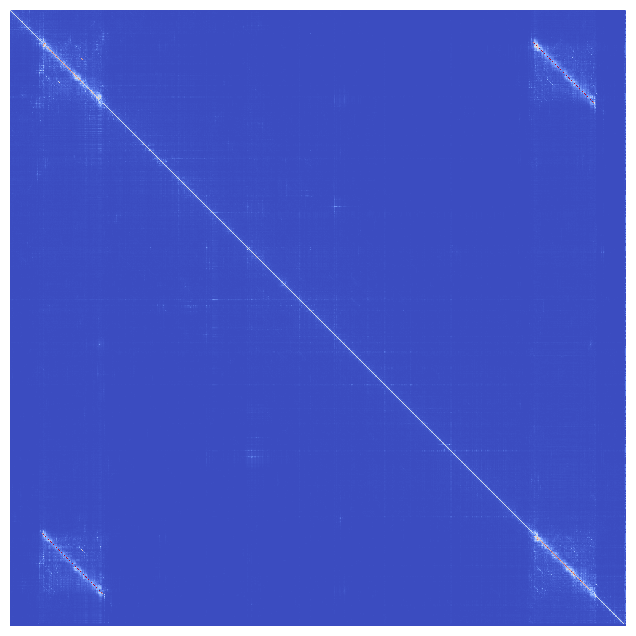

In [145]:
ci_matrix, all_seq = compute_ci_matrix_random_repeat(gene_seq, p1 = 50, p2 = 850, repeat_length=100, return_gene_seq=True)
plot_ci_matrix(ci_matrix, vmax=8, fig_size=8)

In [147]:
ci_matrix_zero_diag =ci_matrix.copy()
ci_matrix_zero_diag[np.arange(ci_matrix_zero_diag.shape[0]), np.arange(ci_matrix_zero_diag.shape[0])] = 0


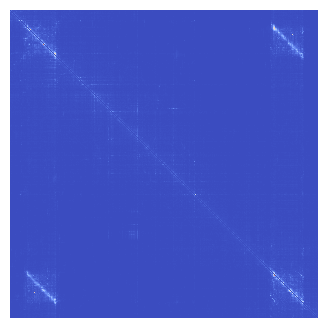

In [153]:
plot_ci_matrix(ci_matrix_zero_diag[:-3,:-3], vmax=8, fig_size=4, savefig=True)

In [ ]:
all_seq

'TTATAGGAAAAGGAATTAATCTAGATTATATTAGTCGCAATGCCATTGTCACACAGCGCCCTCCCGAGATCTGGCTTCACATCGGACGGGTCGGTGTGGCACTTTTTCCCTCCCTCACATCAGGTGCATACAATCTACAGTGATCTGCCAGTAGCATGTCGTCAACTGGGTTAACTTATTTCACATTGACTTTAATGGGAATATCTAACATAGTAAATGGAACGTTAGACGGTAGTATATACCCCCCTTAGGGAGCTCATATTGCAGAGGTATAGAAAAATACAAACAACTAATATATAGGATACCAACAAGAGATTAGACTTTCAAAGTTATAAAAGCTAACCGGAATAGAGAGAGGAACGGTACTGGATTTCTGATAAAATTAGTCGTTGATGGAATTCAAACTAGACTATAAAGGGTTTAAAACGGTAAGTCGAAAAACAACCCCACAAACTAATATCCAAAGAATGTAAAAAACCAAGCTCTGGGAGCCTAACTATAGAGATGTGGATGAACGAAATTCGAAAGACTAATCATTACCGGCAGATTACCAAGTAAAAAAACCCAACATCGGTATTATCTAAAAATGTTATTCCGGCAGCTACATTGTAGCTTACAAGTGAGAAACTGTTAAAAGAAGAGCGTAGTTTATAATCGGGTTCAAATCTTCATAATAATACACTCACCAAAAGTTCTTACTGGACTTGCACTTGGAATGAACCGTTGAATTAATTCAAATGAGGAAAAGCGTATCGCAGTTGAGTCCAGAAATTATCGAGACAGGCATTCGCCCAGAAATAGCTAGATGTATTAATTGTTATATGTGAAGGGAGTGATTCTCACTGAGTGAACACAGCGCCCTCCCGAGATCTGGCTTCACATCGGACGGGTCGGTGTGGCACTTTTTCCCTCCCTCACATCAGGTGCATACAATCTACAGTGATCTGCCAGAACTACGGTCGTCGAATGAGCTAGAAAGCCGATTTTACCTTATGAGAA

In [158]:
with open(os.path.join(data_path, 'artificial_repeat_sequence.txt'), 'w') as file:
    # Write the string to the file
    file.write(all_seq)

## Plot reconstruction

In [11]:
import torch 
from datasets import Dataset
import matplotlib.pyplot as plt
import torch.nn as nn

In [65]:
from transformers import AutoTokenizer
from transformers import BertConfig
from transformers import AutoModelForSequenceClassification, DefaultDataCollator
from flash_attn.models.bert import BertModel, BertForPreTraining
model_path = 'species_upstream_1000_k1/'
tokenizer = AutoTokenizer.from_pretrained(model_path)
config = BertConfig.from_pretrained(model_path)
model = BertForPreTraining.from_pretrained(model_path, config)

In [66]:
proxy_species = 'kazachstania_africana_cbs_2517_gca_000304475'
# assert proxy_species in tokenizer.get_vocab()    
assert proxy_species in tokenizer.get_vocab()

In [67]:
device = "cuda"
model.to(device)
model.eval()

BertForPreTraining(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(1408, 768, padding_idx=0)
      (position_embeddings): Embedding(1024, 768)
      (token_type_embeddings): Embedding(2, 768)
    )
    (emb_drop): Dropout(p=0.1, inplace=False)
    (emb_ln): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (encoder): BertEncoder(
      (layers): ModuleList(
        (0): Block(
          (mixer): MHA(
            (Wqkv): FusedDense(in_features=768, out_features=2304, bias=True)
            (inner_attn): FlashSelfAttention(
              (drop): Dropout(p=0.1, inplace=False)
            )
            (inner_cross_attn): FlashCrossAttention(
              (drop): Dropout(p=0.1, inplace=False)
            )
            (out_proj): FusedDense(in_features=768, out_features=768, bias=True)
          )
          (dropout1): Dropout(p=0.1, inplace=False)
          (drop_path1): StochasticDepth(p=0.0, mode=row)
          (norm1): LayerNorm((768,

### Model class wrapper

In [162]:
import contextlib
from torch.amp import autocast
import itertools
import tqdm
import math

class ReconstructionModel(nn.Module):
    
    def __init__(self, lm, tokenizer, device=device, 
                 kmer_size = 1, 
                 left_special_tokens = 2,
                 right_special_tokens = 1,
                 return_logits = False,
                 require_lm_grad = False):
        super().__init__()
        self.lm = lm
        self.tokenizer = tokenizer
        # mode
        if kmer_size > 1:
            assert not return_logits, "Not implemented"
        self.return_logits = return_logits
        self.require_lm_grad = require_lm_grad
        # constants
        self.kmer_size = kmer_size
        self.device = device
        self.left_special_tokens = left_special_tokens
        self.right_special_tokens = right_special_tokens
        # extra layers for the probability computation
        self.create_prb_filter()
        # components for the backward
        self.word_embeddings = None
        self.hook_dict = {}
        
    def set_lm_grad_computation(self, switch):
        self.require_lm_grad = switch
        
    def set_word_embedding_hook(self):
        def getHook():
            def hook(model, input, output):
                output.retain_grad()
                self.word_embeddings = output
            return hook
        self.hook_dict["words"] = self.lm.bert.embeddings.word_embeddings.register_forward_hook(getHook())
        
    def create_prb_filter(self):
        """make a convolutional filter for each nt
        The way this works:
        Take the kmer ACGTGC which maps to token 739, its last nt is C
        This would be the prediction for the masked nucleotide from this kmer, if the kmer is the first in a masked span
        So the first row of column 739 searches for C, in other words filter_xyz = 1 for x = 0, y = 739, z = 2
        Equally, the second row of column 739 searches for G etc..."""
        vocab = tokenizer.get_vocab()
        kmer_list = ["".join(x) for x in itertools.product("ACGT",repeat=self.kmer_size)]
        nt_mapping = {"A":0,"C":1,"G":2,"T":3}
        prb_filter = np.zeros((self.kmer_size, 4**self.kmer_size, 4))
        for kmer in kmer_list:
            token = vocab[kmer] - 5 # there are 5 special tokens
            for idx, nt in enumerate(kmer):
                nt_idx = nt_mapping[nt]
                prb_filter[(self.kmer_size-1)-idx, token, nt_idx] = 1
        prb_filter = torch.from_numpy(prb_filter)
        self.prb_filter = prb_filter.to(self.device).float() # k, 4**k, 
    
    @autocast(device)
    def forward(self, tokens):
        grad_context = contextlib.nullcontext() if self.require_lm_grad else torch.no_grad() 
        with grad_context:
            logits = self._get_lm_output(tokens) # n_masked, 4**k
            # reshape to b, k, 4**k (assumes at most one span is masked, so n_masked = b*k)
            logits = logits.reshape(tokens.shape[0], self.kmer_size, logits.shape[1])
            if self.return_logits:
                logits = logits.sum(axis=(1)) # b * 4
                # reorder from A T C G to A C G T
                #logits_reord = torch.zeros_like(logits)
                #logits_reord[:,:,0] = logits[:,:,0] # A
                #logits_reord[:,:,1] = logits[:,:,2] # C
                #logits_reord[:,:,2] = logits[:,:,3] # G
                #logits_reord[:,:,3] = logits[:,:,1] # T
                #logits = logits_reord
                return logits#_reord
            else:
                # softmax to get probabilities
                kmer_prbs = torch.softmax(logits,dim=2) # b, k, 4**k
                # average over the span and the kmer in each span
                nt_prbs = (kmer_prbs.unsqueeze(-1) * self.prb_filter)
                nt_prbs = nt_prbs.sum(axis=(1,2)) # B, 4
                nt_prbs = nt_prbs/self.kmer_size
                return nt_prbs
        
    def _get_lm_output(self, tokens):
        # get masked tokens
        labels = (tokens == 4).to(torch.int64).to(self.device) # 4 is the mask token
        # this automatically extracts only predictions for masked tokens
        #predictions = self.lm(tokens, labels = labels)["prediction_logits"] # Dim: n_masked_tokens, vocab_size
        predictions = self.lm(tokens)["prediction_logits"] # B, L_in, vocab_size
        predictions = predictions[labels.bool()] # n_masked, vocab_size
        logits = predictions[:,5:(5+self.prb_filter.shape[1])] # remove any non k-mer dims (there are 5 special tokens)
        return logits
    
    def mask_tokens(self, tokens):
        # create diagonal identity matrix of the same shape as basis for the masking
        diag_matrix = torch.eye(tokens.shape[1]).numpy()
        # propagate the ones to kmer-sized spans
        masked_indices = np.apply_along_axis(lambda m : np.convolve(m, [1] * self.kmer_size, mode = 'same'),axis = 1, arr = diag_matrix).astype(bool)
        masked_indices = torch.from_numpy(masked_indices)
        # do not mask special tokens and do not repeat at edges (this math works for k = 6, unclear if it generalizes)
        masked_indices = masked_indices[(math.ceil(self.kmer_size/2) - 1)+self.left_special_tokens:-((self.kmer_size//2)+self.right_special_tokens)]
        masked_tokens = tokens.unsqueeze(1).expand(tokens.shape[0],masked_indices.shape[0],tokens.shape[1]).clone() # reshape
        masked_tokens[:,masked_indices] = 4 # mask
        return masked_tokens
    
    def predict_all_from_dataloader(self, 
                                    data_loader,
                                    batch_size = 128):
        all_preds = []
        for i, group in tqdm.tqdm(enumerate(data_loader)):
            output_arrays = []
            # get some tokenized sequences (B, L_in)
            tokens = group['input_ids']
            # mask them
            masked_tokens = self.mask_tokens(tokens)
            # remember the number of sequences (shape[0] = B) and number of maskings (shape[1] = n_masked)
            group_shape = masked_tokens.shape
            # reshape to B*n_masked, L_in
            masked_tokens = masked_tokens.reshape(masked_tokens.shape[0]*masked_tokens.shape[1], masked_tokens.shape[2])
            token_loader = torch.utils.data.DataLoader(masked_tokens, batch_size=batch_size, 
                                                       num_workers = 4, shuffle = False, collate_fn = None)
            # predict
            for j, batch in enumerate(token_loader):
                outputs = self(batch.to(self.device)) # b, 4
                output_arrays.append(outputs.cpu()) # send to cpu to conserve memory
            # rebuild to B*n_masked, 4
            predictions = torch.concat(output_arrays, axis=0)
            # reshape to B, n_masked, 4
            predictions = predictions.reshape((group_shape[0],group_shape[1],predictions.shape[1]))
            all_preds.append(predictions)
        predictions = torch.concat(all_preds, axis=0)
        return predictions

reconstructor = ReconstructionModel(model, tokenizer, require_lm_grad=False)
reconstructor.eval()
print("Done")

Done


In [163]:
def create_dataloader(dataset, batch_size=64):

    ds = Dataset.from_pandas(dataset[['seq']]) 
    tok_ds = ds.map(tok_func_species, batched=False,  num_proc=20)
    rem_tok_ds = tok_ds.remove_columns('seq')

    data_collator = DefaultDataCollator()

    data_loader = torch.utils.data.DataLoader(rem_tok_ds, batch_size=batch_size, num_workers = 4, shuffle = False, collate_fn=data_collator)

    return data_loader

def tok_func_species(x, proxy_species=proxy_species):
    res = tokenizer(proxy_species + " ".join(list(x['seq'])))
    return res

In [164]:
genes_of_interest = ['YNR064C']
dataset = s_cer_seqs_df[s_cer_seqs_df.gene_id.isin(genes_of_interest)].rename({'five_prime_seq':'seq'},axis=1).loc[:, ['gene_id', 'seq']].copy().reset_index(drop=True)
artificial_repeat_row = {'gene_id': 'artificial_repeat', 'seq': all_seq}

dataset = pd.concat([dataset, pd.DataFrame(artificial_repeat_row, index=[1])], axis=0)
dataset

gene_id                                                seq
0            YNR064C  ATCGAAAAATTCCCTTATCAACCTGTAAAGGTGGGCTGAAATTGGA...
1  artificial_repeat  TTATAGGAAAAGGAATTAATCTAGATTATATTAGTCGCAATGCCAT...

In [165]:
dl = create_dataloader(dataset, batch_size=1)

all_prbs = reconstructor.predict_all_from_dataloader(dl, batch_size=128)

num_proc must be <= 2. Reducing num_proc to 2 for dataset of size 2.


Map (num_proc=2):   0%|          | 0/2 [00:00<?, ? examples/s]

2it [00:07,  3.64s/it]


In [166]:
all_prbs.shape

torch.Size([2, 1003, 4])

In [167]:
# save probs
np.save(os.path.join(data_path, 'repeat_and_promoter_reconstruction.npy'), all_prbs.numpy())

# Visualization

In [175]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


def ic_scale(pwm,background):
    odds_ratio = ((pwm+0.001)/(1.004))/(background[None,:])
    ic = ((np.log((pwm+0.001)/(1.004))/np.log(2))*pwm -\
            (np.log(background)*background/np.log(2))[None,:])
    return pwm*(np.sum(ic,axis=1)[:,None])


def plot_a(ax, base, left_edge, height, color):
    a_polygon_coords = [
        np.array([
           [0.0, 0.0],
           [0.5, 1.0],
           [0.5, 0.8],
           [0.2, 0.0],
        ]),
        np.array([
           [1.0, 0.0],
           [0.5, 1.0],
           [0.5, 0.8],
           [0.8, 0.0],
        ]),
        np.array([
           [0.225, 0.45],
           [0.775, 0.45],
           [0.85, 0.3],
           [0.15, 0.3],
        ])
    ]
    for polygon_coords in a_polygon_coords:
        ax.add_patch(
            matplotlib.patches.Polygon(
                (np.array([1,height])[None,:]*polygon_coords
                 + np.array([left_edge,base])[None,:]),
                facecolor=color, edgecolor=color))


def plot_c(ax, base, left_edge, height, color):
    ax.add_patch(matplotlib.patches.Ellipse(
        xy=[left_edge+0.65, base+0.5*height], width=1.3, height=height,
        facecolor=color, edgecolor=color))
    ax.add_patch(matplotlib.patches.Ellipse(
        xy=[left_edge+0.65, base+0.5*height], width=0.7*1.3, height=0.7*height,
        facecolor='white', edgecolor='white'))
    ax.add_patch(matplotlib.patches.Rectangle(
        xy=[left_edge+1, base], width=1.0, height=height,
        facecolor='white', edgecolor='white', fill=True))


def plot_g(ax, base, left_edge, height, color):
    ax.add_patch(matplotlib.patches.Ellipse(
        xy=[left_edge+0.65, base+0.5*height], width=1.3, height=height,
        facecolor=color, edgecolor=color))
    ax.add_patch(matplotlib.patches.Ellipse(
        xy=[left_edge+0.65, base+0.5*height], width=0.7*1.3, height=0.7*height,
        facecolor='white', edgecolor='white'))
    ax.add_patch(matplotlib.patches.Rectangle(
        xy=[left_edge+1, base], width=1.0, height=height,
        facecolor='white', edgecolor='white', fill=True))
    ax.add_patch(matplotlib.patches.Rectangle(
        xy=[left_edge+0.825, base+0.085*height],
        width=0.174, height=0.415*height,
        facecolor=color, edgecolor=color, fill=True))
    ax.add_patch(matplotlib.patches.Rectangle(
        xy=[left_edge+0.625, base+0.35*height],
        width=0.374, height=0.15*height,
        facecolor=color, edgecolor=color, fill=True))


def plot_t(ax, base, left_edge, height, color):
    ax.add_patch(
        matplotlib.patches.Rectangle(xy=[left_edge+0.4, base],
        width=0.2, height=height, facecolor=color, edgecolor=color, fill=True))
    ax.add_patch(
        matplotlib.patches.Rectangle(xy=[left_edge, base+0.8*height],
        width=1.0, height=0.2*height, facecolor=color,
        edgecolor=color, fill=True))

    
def plot_u(ax, base, left_edge, height, color):
    ax.add_patch(matplotlib.patches.Ellipse(
        xy=[left_edge+0.5, base+0.4*height], width=0.95, height=0.8*height,
        facecolor=color, edgecolor=color))
    ax.add_patch(matplotlib.patches.Rectangle(
        xy=[left_edge+0.025, base+0.4*height], width=0.95, height=0.6*height,
        facecolor=color, edgecolor=color, fill=True))
    ax.add_patch(matplotlib.patches.Ellipse(
        xy=[left_edge+0.5, base+0.4*height], width=0.6175, height=0.52*height,
        facecolor='white', edgecolor='white'))
    ax.add_patch(matplotlib.patches.Rectangle(
        xy=[left_edge+0.19125, base+0.4*height], width=0.6175, height=0.6*height,
        facecolor='white', edgecolor='white', fill=True))
    """ax.add_patch(matplotlib.patches.Ellipse(
        xy=[left_edge+0.65, base+0.5*height], width=0.7*1.3, height=0.7*height,
        facecolor='white', edgecolor='white'))
    ax.add_patch(matplotlib.patches.Rectangle(
        xy=[left_edge+1, base], width=1.0, height=height,
        facecolor='white', edgecolor='white', fill=True))"""
    

default_colors = {0:'green', 1:'blue', 2:'orange', 3:'red'}
dna_plot_funcs = {0:plot_a, 1:plot_c, 2:plot_g, 3:plot_t}
rna_plot_funcs = {0:plot_a, 1:plot_c, 2:plot_g, 3:plot_u}


def plot_weights_given_ax(ax, array,          
                 height_padding_factor=0.2,
                 length_padding=1.0,
                 subticks_frequency="auto",
                 colors=default_colors,
                 plot_funcs=dna_plot_funcs,
                 highlight={},
                 ylabel=""):
    if len(array.shape)==3:
        array = np.squeeze(array)
    assert len(array.shape)==2, array.shape
    if (array.shape[0]==4 and array.shape[1] != 4):
        array = array.transpose(1,0)
    assert array.shape[1]==4
    if (subticks_frequency=="auto"):
        subticks_frequency = 1.0 if len(array) <= 40 else int(len(array)/40)
    max_pos_height = 0.0
    min_neg_height = 0.0
    heights_at_positions = []
    depths_at_positions = []
    for i in range(array.shape[0]):
        #sort from smallest to highest magnitude
        acgt_vals = sorted(enumerate(array[i,:]), key=lambda x: abs(x[1]))
        positive_height_so_far = 0.0
        negative_height_so_far = 0.0
        for letter in acgt_vals:
            plot_func = plot_funcs[letter[0]]
            color=colors[letter[0]]
            if (letter[1] > 0):
                height_so_far = positive_height_so_far
                positive_height_so_far += letter[1]                
            else:
                height_so_far = negative_height_so_far
                negative_height_so_far += letter[1]
            plot_func(ax=ax, base=height_so_far,
                      left_edge=i+0.5, height=letter[1], color=color)
        max_pos_height = max(max_pos_height, positive_height_so_far)
        min_neg_height = min(min_neg_height, negative_height_so_far)
        heights_at_positions.append(positive_height_so_far)
        depths_at_positions.append(negative_height_so_far)

    #now highlight any desired positions; the key of
    #the highlight dict should be the color
    for color in highlight:
        for start_pos, end_pos in highlight[color]:
            assert start_pos >= 0.0 and end_pos <= array.shape[0]
            min_depth = np.min(depths_at_positions[start_pos:end_pos])
            max_height = np.max(heights_at_positions[start_pos:end_pos])
            ax.add_patch(
                matplotlib.patches.Rectangle(xy=[start_pos,min_depth],
                    width=end_pos-start_pos,
                    height=max_height-min_depth,
                    edgecolor=color, fill=False))
            
    ax.set_xlim(0.5-length_padding, 0.5+array.shape[0]+length_padding)
    ax.xaxis.set_ticks(np.arange(1.0, array.shape[0]+1, subticks_frequency))
    height_padding = max(abs(min_neg_height)*(height_padding_factor),
                         abs(max_pos_height)*(height_padding_factor))
    ax.set_ylim(min_neg_height-height_padding, max_pos_height+height_padding)
    ax.set_ylabel(ylabel)
    ax.yaxis.label.set_fontsize(15)


def plot_weights(array,
                 figsize=(20,2),
                 ax_transform_func=lambda x: x, savefigpath=None,
                 **kwargs):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111) 
    ax_transform_func(ax)
    plot_weights_given_ax(ax=ax,
        array=array,
        **kwargs)
    if savefigpath is not None:
        plt.savefig(savefigpath, dpi=400)
    plt.show()
    
    
def dna_plot_weights(array, **kwargs):
  plot_weights(array=array, plot_funcs=dna_plot_funcs, **kwargs)


def rna_plot_weights(array, **kwargs):
  plot_weights(array=array, plot_funcs=rna_plot_funcs, **kwargs)

In [169]:
def compute_log_ratio(nuc_probs):
    nucs_mean = nuc_probs[:-3].mean(axis = 0)
    nucs_normed = nuc_probs * np.log2(nuc_probs/nucs_mean)
    return nucs_normed

In [170]:
import torch
def compute_per_position_ic(ppm, 
                            background=torch.tensor([0.325, 0.176, 0.175, 0.324]),#torch.tensor([0.25, 0.25, 0.25, 0.25]), 
                            pseudocount=0):
    ppm = ppm.clone().detach()
    alphabet_len = len(background)
    bg = torch.log2(background)*background
    pseudocounted_ppm = (ppm+pseudocount)/(1 + pseudocount*alphabet_len)
    ic = torch.log2(pseudocounted_ppm)*ppm - bg.unsqueeze(0)
    return torch.sum(ic,axis=2)

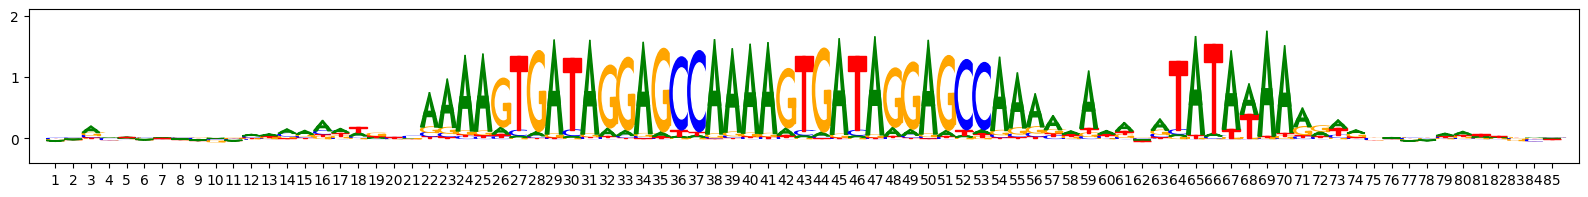

In [171]:
plot_weights((all_prbs[0] *compute_per_position_ic(all_prbs[0].unsqueeze(0)).swapaxes(0,1)).numpy()[865:950], subticks_frequency=1)

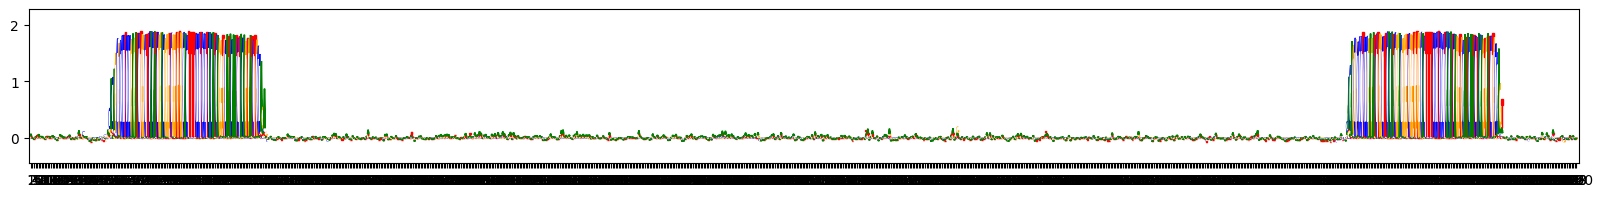

In [176]:
plot_weights((all_prbs[1] *compute_per_position_ic(all_prbs[1].unsqueeze(0)).swapaxes(0,1)).numpy()[:-3], subticks_frequency=1, 
             savefigpath='fig6_artificial_repeat_reconstruction.png'))

In [178]:
rec = (all_prbs[1] *compute_per_position_ic(all_prbs[1].unsqueeze(0)).swapaxes(0,1)).numpy()[:-3]

## Compute average nuc dependency vs repeat length

In [12]:
import random


def insert_random_repeat(seq, random_seq_length = 14):

    seq_length = len(seq)

    if seq_length < random_seq_length:
        raise ValueError("Gene sequence is too short for the random sequence")

    # randomly select p1
    p1 = random.randint(0, seq_length - random_seq_length)

    # define ranges for p2 selection, excluding the region occupied by p1 and its random sequence
    p2_range1 = range(0, p1-random_seq_length) 
    p2_range2 = range(p1 + random_seq_length, seq_length - random_seq_length) 

    combined_ranges = list(p2_range1) + list(p2_range2)
    if not combined_ranges:
        raise ValueError("No suitable position found for p2")
    p2 = random.choice(combined_ranges)

    random_seq = ''.join(random.choices('ACGT', k=random_seq_length))

    
    seq = seq[:p1] + random_seq + seq[p1+random_seq_length:]
    seq = seq[:p2] + random_seq + seq[p2+random_seq_length:]
    
    return p1, p2, seq

In [13]:
insert_random_repeat('ATGTGTGTGAGAGGA',random_seq_length=5)

(7, 0, 'GGTCGTGGGTCGGGA')

In [14]:
def shuffle_sequence_sample_window(seq, window_size):
    seq = list(seq)
    random.shuffle(seq)

    if window_size > len(seq):
        raise ValueError("Window size cannot be larger than the sequence length")

    # select a random start point for the window
    start_point = random.randint(0, len(seq) - window_size)

    window = seq[start_point:(start_point + window_size)]

    return ''.join(window), ''.join(seq), start_point

Now we check if inputing the full 1000bp window or the smaller median_tRNA length window influences the nuc dependencies

In [35]:
window_seq, full_seq, start_point = shuffle_sequence_sample_window(s_cer_seqs_df[s_cer_seqs_df.gene_id=='YJR055W']['five_prime_seq'].values[0], window_size = 100)
full_seq

'CATTGTGCTACTCTTAAATATTATACGACTTTTTGGGTAAAAACAAGTTGGACTGCCTTTTTTACAAGATCAACCTTTATTTCACAATATTAAAGTTATTGAGATGACATAGTCTCATACTCGTATATTAAGATAGCACAACAGTGCGAAGCCTATCATACAGATTTACGGAATAAGTAATCGTAATATTTGTTGACGTTTGACGGTTACACTACCAAAACTTACATGGTCAGAGTACAAGTTTTTGGCTTTATGAGTTAATCTCTATGACCATTTAACCTCTGAATGTACGGTTATGTATTAAATTGATCAACGTTCAAGTTGTAAATCCAATTGGTGTTTTATTGTAGCCTGAGCTTAATTTAACTTGCAGTGTTAACTAAATTATAAGTAAATAATCGTTATTTAGTACGTTCCACAAAATTACAATGAAGATTCTTGGAGTTCAGCGAATAATTTACGATTGTTAGTTTACAACCTTACAACCAAGACGAATAAATGTGGTTTTAGTGATGTAAAGTGTACAATCATCACATAATTATGTCTTGGGTTAACAACAATATACCATGGTTCCCTCTAGTCTGTTTCACATAGTTGACAGTTTAACAACTTTAAAATTTCGATCCGCTAAGATGCATAAAATGACTTTAAGGCTGTAAAATTATATCGTAAACTAGAAGTTGACATATAGTCTACACTAAATCATATCCAATATCAAGGAAAGAAATTGTGAACTGCAGATACTCGCTTGTTCTTACGTAATCACCTTAAGATATTGAATACCGCTTCGGTAAAATTGGTAGACTGTAGTACTGTACAAGATTTGGATTCTGAATGATTTCAAACGGATTCATTGGATAATGTAGTTTGTGGGTTTTTGAAGGCAGCTTATCTAACAATTGGACAACCTTGGAACTATATATTAATAAATTAGACATTTGAAATTTTTTAAGTATAGTCCCTTACATATCTGCTGTATTAACCCGATGACTATTGACC

59 29 TACAATCATCACATAATTATGTCTTGGGTCCTGATGGGTATACCATGGTTCCCTCTAGTCCTGATGGGATAGTTGACAGTTTAACAACTTTAAAATTTCG


Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

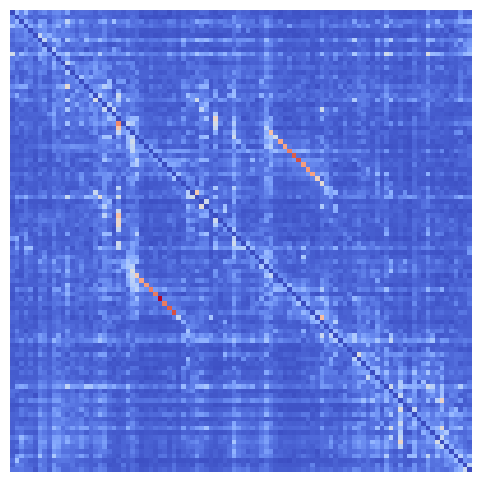

In [39]:
n=9
p1,p2,a_seq = insert_random_repeat(window_seq, random_seq_length=n)
print(p1,p2,a_seq)
ci_matrix = compute_ci_matrix(a_seq, proxy_species=proxy_species)
#plot_ci_matrix(ci_matrix, display_values=True, fig_size=20, annot_size=5)
ci_matrix[np.arange(ci_matrix.shape[0]), np.arange(ci_matrix.shape[0])]=0
plot_ci_matrix(ci_matrix)

In [40]:
np.concatenate((ci_matrix[np.arange(p1, p1+n), np.arange(p2, p2+n)], 
                ci_matrix[np.arange(p2, p2+n), np.arange(p1, p1+n)])).mean()

11.415338900354174

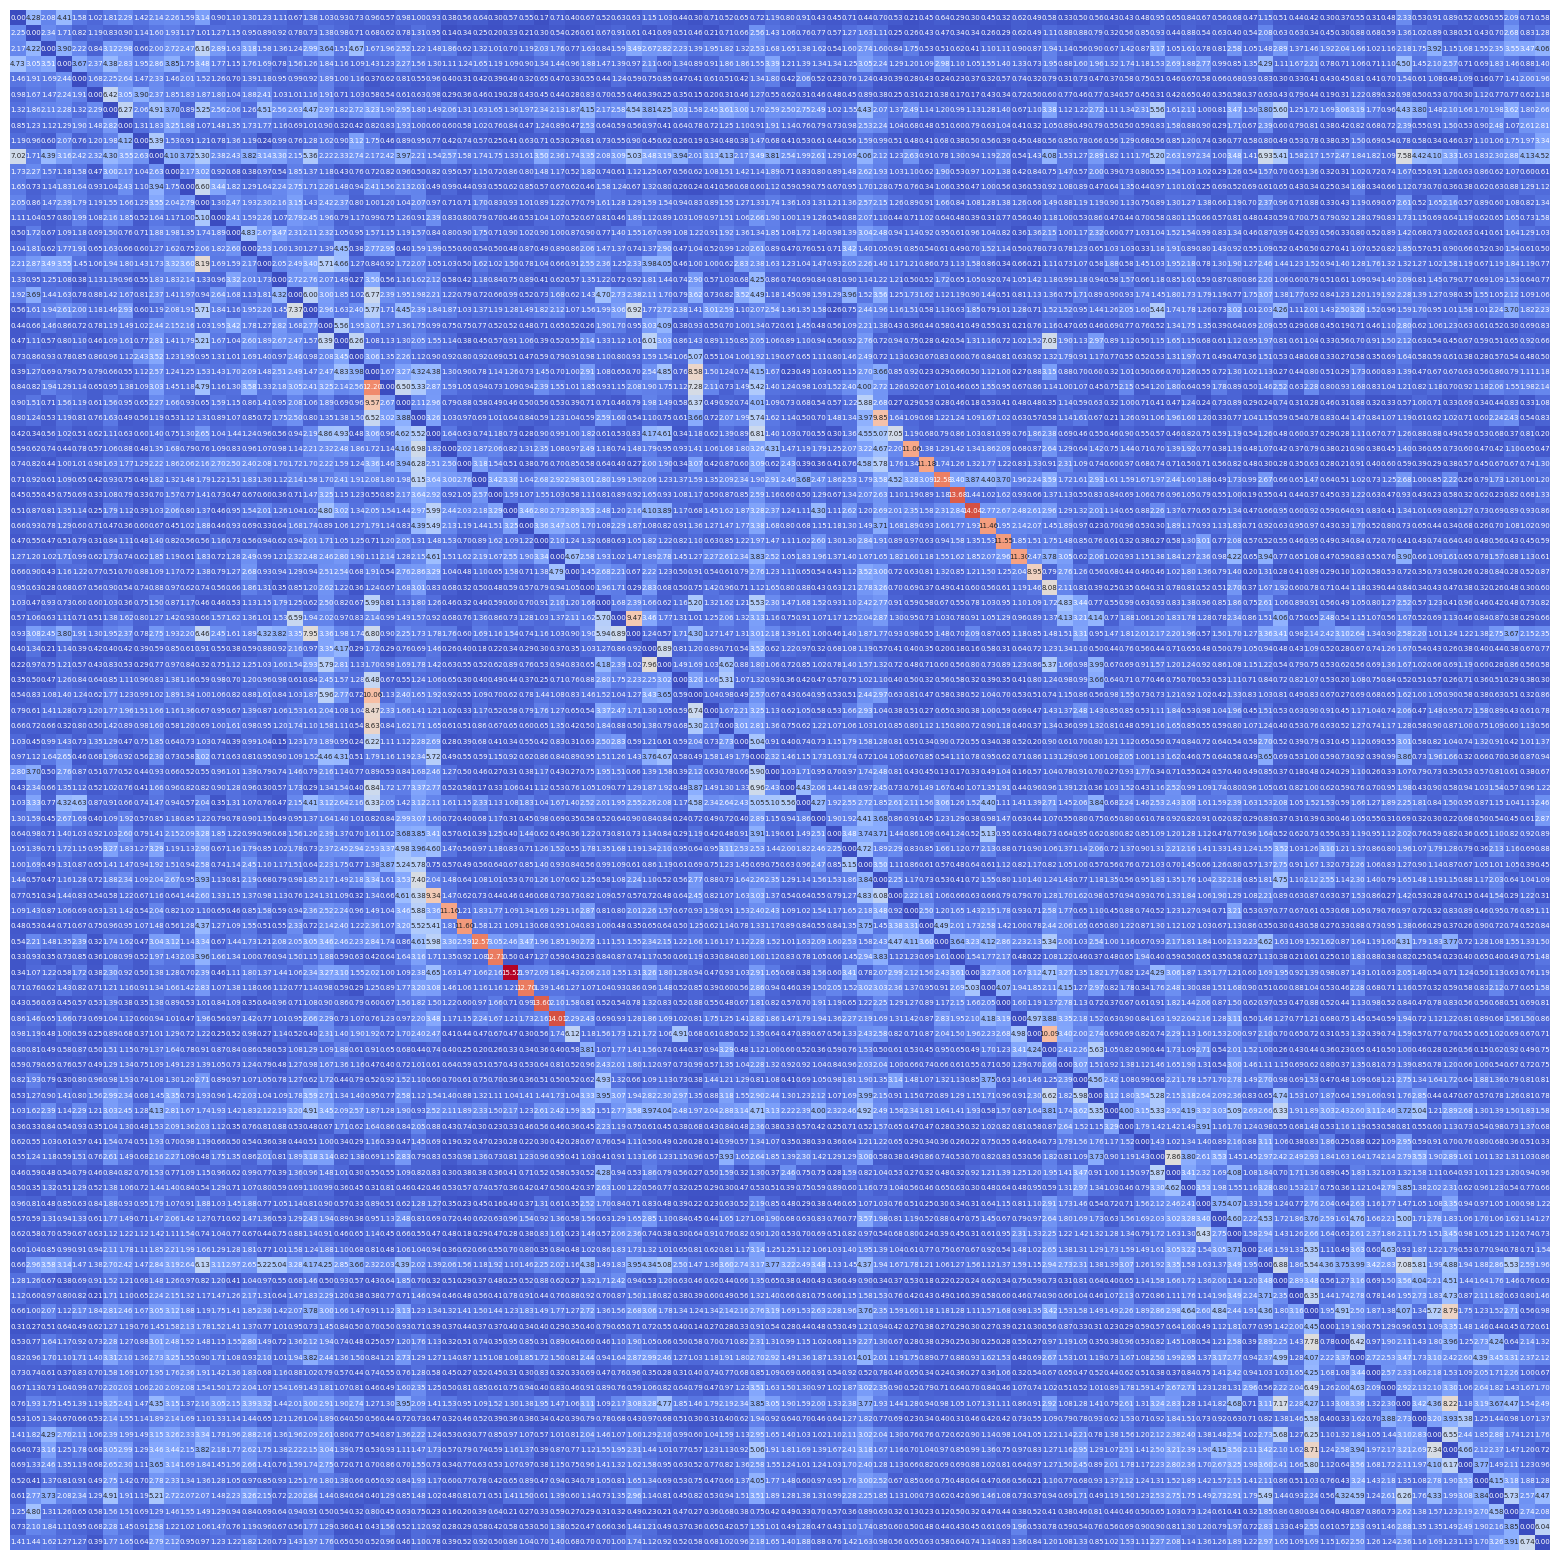

In [41]:
plot_ci_matrix(ci_matrix, display_values=True, fig_size=20, annot_size=5)

In [42]:
ci_matrix[np.arange(p1, p1+n), np.arange(p2, p2+n)]

array([11.60144997, 12.57475948, 12.71283245, 15.52362061, 12.70047188,
       13.59597397, 14.00845337,  6.12126637,  3.80859685])

In [43]:
p1, p2

(59, 29)

In [44]:
ci_matrix[np.arange(p1, p1+n), np.arange(p2, p2+n)]

array([11.60144997, 12.57475948, 12.71283245, 15.52362061, 12.70047188,
       13.59597397, 14.00845337,  6.12126637,  3.80859685])

In [45]:
ci_matrix[np.arange(p2, p2+n), np.arange(p1, p1+n)]

array([11.18205547, 12.57823372, 13.68260384, 14.0432148 , 11.46084213,
       11.55212116, 11.29718399,  8.9543581 ,  8.07806206])

In [46]:
n_natural_seqs_to_sample = 20
n_windows_to_sample = 5

In [53]:
from tqdm import tqdm

seq_length = 100
n_natural_seqs_to_sample = 20
n_windows_to_sample = 5
len_repeats_to_check = np.arange(2,21)
avg_occurences_list = []
avg_interaction_values_list = []
natural_seqs = list(s_cer_seqs_df['five_prime_seq'].dropna().sample(n_natural_seqs_to_sample).values)
avg_interaction_values_df = pd.DataFrame(index=np.arange(n_natural_seqs_to_sample*n_windows_to_sample))

for n in len_repeats_to_check:

    print('n ', n)
    n_rev_comps_list = []
    avg_interaction_values_n_list = []

    for l in tqdm(range(n_natural_seqs_to_sample)):
        
        for k in range(n_windows_to_sample):

            window_seq, _, _ = shuffle_sequence_sample_window(natural_seqs[l], window_size=seq_length)
            p1, p2, window_seq_w_revcomp = insert_random_repeat(window_seq, random_seq_length=n)
            ci_matrix = compute_ci_matrix(window_seq_w_revcomp, proxy_species=proxy_species)

            avg_ci_value = np.concatenate((ci_matrix[np.arange(p1, p1+n), np.arange(p2, p2+n)], 
                ci_matrix[np.arange(p2, p2+n), np.arange(p1, p1+n)])).mean() # take the average of the two diagonals

            avg_interaction_values_n_list.append(avg_ci_value)

    avg_interaction_values_df[f'{n}'] = avg_interaction_values_n_list



n  2


  0%|          | 0/20 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

  5%|▌         | 1/20 [00:08<02:45,  8.73s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 10%|█         | 2/20 [00:17<02:37,  8.75s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 15%|█▌        | 3/20 [00:26<02:30,  8.86s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 20%|██        | 4/20 [00:35<02:20,  8.76s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 25%|██▌       | 5/20 [00:43<02:11,  8.77s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 30%|███       | 6/20 [00:52<02:02,  8.73s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 35%|███▌      | 7/20 [01:01<01:53,  8.73s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 40%|████      | 8/20 [01:10<01:45,  8.78s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 45%|████▌     | 9/20 [01:19<01:36,  8.81s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 50%|█████     | 10/20 [01:28<01:28,  8.87s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 55%|█████▌    | 11/20 [01:37<01:21,  9.03s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 60%|██████    | 12/20 [01:46<01:12,  9.10s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 65%|██████▌   | 13/20 [01:55<01:02,  8.97s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 70%|███████   | 14/20 [02:04<00:53,  8.91s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 75%|███████▌  | 15/20 [02:12<00:44,  8.90s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 80%|████████  | 16/20 [02:21<00:35,  8.90s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 85%|████████▌ | 17/20 [02:30<00:26,  8.84s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 90%|█████████ | 18/20 [02:39<00:17,  8.87s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 95%|█████████▌| 19/20 [02:48<00:08,  8.82s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

100%|██████████| 20/20 [02:57<00:00,  8.85s/it]


n  3


  0%|          | 0/20 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

  5%|▌         | 1/20 [00:08<02:49,  8.91s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 10%|█         | 2/20 [00:17<02:41,  8.95s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 15%|█▌        | 3/20 [00:26<02:31,  8.93s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 20%|██        | 4/20 [00:35<02:22,  8.91s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 25%|██▌       | 5/20 [00:44<02:13,  8.93s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 30%|███       | 6/20 [00:53<02:04,  8.87s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 35%|███▌      | 7/20 [01:02<01:54,  8.83s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 40%|████      | 8/20 [01:10<01:45,  8.79s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 45%|████▌     | 9/20 [01:19<01:36,  8.78s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 50%|█████     | 10/20 [01:28<01:28,  8.86s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 55%|█████▌    | 11/20 [01:37<01:19,  8.81s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 60%|██████    | 12/20 [01:45<01:10,  8.76s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 65%|██████▌   | 13/20 [01:55<01:01,  8.85s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 70%|███████   | 14/20 [02:03<00:52,  8.83s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 75%|███████▌  | 15/20 [02:12<00:44,  8.80s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 80%|████████  | 16/20 [02:21<00:35,  8.89s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 85%|████████▌ | 17/20 [02:30<00:26,  8.82s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 90%|█████████ | 18/20 [02:39<00:17,  8.82s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 95%|█████████▌| 19/20 [02:47<00:08,  8.81s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

100%|██████████| 20/20 [02:56<00:00,  8.83s/it]


n  4


  0%|          | 0/20 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

  5%|▌         | 1/20 [00:09<02:51,  9.04s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 10%|█         | 2/20 [00:17<02:40,  8.90s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 15%|█▌        | 3/20 [00:26<02:29,  8.81s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 20%|██        | 4/20 [00:35<02:21,  8.82s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 25%|██▌       | 5/20 [00:44<02:11,  8.78s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 30%|███       | 6/20 [00:52<02:03,  8.80s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 35%|███▌      | 7/20 [01:01<01:54,  8.80s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 40%|████      | 8/20 [01:10<01:45,  8.77s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 45%|████▌     | 9/20 [01:19<01:37,  8.87s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 50%|█████     | 10/20 [01:28<01:29,  8.96s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 55%|█████▌    | 11/20 [01:37<01:19,  8.88s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 60%|██████    | 12/20 [01:46<01:10,  8.84s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 65%|██████▌   | 13/20 [01:55<01:02,  8.95s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 70%|███████   | 14/20 [02:04<00:53,  8.89s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 75%|███████▌  | 15/20 [02:12<00:44,  8.86s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 80%|████████  | 16/20 [02:21<00:35,  8.86s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 85%|████████▌ | 17/20 [02:30<00:26,  8.88s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 90%|█████████ | 18/20 [02:39<00:17,  8.90s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 95%|█████████▌| 19/20 [02:48<00:08,  8.89s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

100%|██████████| 20/20 [02:57<00:00,  8.86s/it]


n  5


  0%|          | 0/20 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

  5%|▌         | 1/20 [00:08<02:47,  8.80s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 10%|█         | 2/20 [00:17<02:37,  8.75s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 15%|█▌        | 3/20 [00:26<02:28,  8.75s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 20%|██        | 4/20 [00:35<02:23,  8.95s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 25%|██▌       | 5/20 [00:44<02:14,  8.95s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 30%|███       | 6/20 [00:53<02:04,  8.93s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 35%|███▌      | 7/20 [01:02<01:56,  8.95s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 40%|████      | 8/20 [01:11<01:47,  8.93s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 45%|████▌     | 9/20 [01:20<01:38,  8.96s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 50%|█████     | 10/20 [01:29<01:29,  8.91s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 55%|█████▌    | 11/20 [01:37<01:19,  8.86s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 60%|██████    | 12/20 [01:47<01:11,  9.00s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 65%|██████▌   | 13/20 [01:57<01:06,  9.44s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 70%|███████   | 14/20 [02:06<00:56,  9.37s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 75%|███████▌  | 15/20 [02:15<00:46,  9.23s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 80%|████████  | 16/20 [02:24<00:36,  9.13s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 85%|████████▌ | 17/20 [02:33<00:27,  9.05s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 90%|█████████ | 18/20 [02:42<00:18,  9.04s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 95%|█████████▌| 19/20 [02:51<00:09,  9.04s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

100%|██████████| 20/20 [03:00<00:00,  9.02s/it]


n  6


  0%|          | 0/20 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

  5%|▌         | 1/20 [00:08<02:49,  8.91s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 10%|█         | 2/20 [00:18<02:42,  9.02s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 15%|█▌        | 3/20 [00:26<02:32,  8.97s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 20%|██        | 4/20 [00:35<02:24,  9.00s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 25%|██▌       | 5/20 [00:45<02:15,  9.04s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 30%|███       | 6/20 [00:54<02:07,  9.09s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 35%|███▌      | 7/20 [01:03<01:59,  9.16s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 40%|████      | 8/20 [01:12<01:48,  9.04s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 45%|████▌     | 9/20 [01:21<01:38,  8.98s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 50%|█████     | 10/20 [01:30<01:30,  9.03s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 55%|█████▌    | 11/20 [01:39<01:22,  9.11s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 60%|██████    | 12/20 [01:48<01:12,  9.05s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 65%|██████▌   | 13/20 [01:57<01:03,  9.08s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 70%|███████   | 14/20 [02:06<00:54,  9.04s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 75%|███████▌  | 15/20 [02:15<00:45,  9.02s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 80%|████████  | 16/20 [02:24<00:35,  8.99s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 85%|████████▌ | 17/20 [02:33<00:26,  8.96s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 90%|█████████ | 18/20 [02:42<00:17,  8.93s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 95%|█████████▌| 19/20 [02:51<00:09,  9.04s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

100%|██████████| 20/20 [03:00<00:00,  9.02s/it]


n  7


  0%|          | 0/20 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

  5%|▌         | 1/20 [00:08<02:47,  8.84s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 10%|█         | 2/20 [00:17<02:39,  8.85s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 15%|█▌        | 3/20 [00:26<02:31,  8.89s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 20%|██        | 4/20 [00:35<02:22,  8.90s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 25%|██▌       | 5/20 [00:44<02:13,  8.92s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 30%|███       | 6/20 [00:53<02:05,  8.95s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 35%|███▌      | 7/20 [01:02<01:57,  9.02s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 40%|████      | 8/20 [01:11<01:48,  9.01s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 45%|████▌     | 9/20 [01:20<01:38,  8.98s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 50%|█████     | 10/20 [01:29<01:29,  8.99s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 55%|█████▌    | 11/20 [01:38<01:20,  8.94s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 60%|██████    | 12/20 [01:47<01:11,  8.98s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 65%|██████▌   | 13/20 [01:56<01:03,  9.07s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 70%|███████   | 14/20 [02:05<00:54,  9.04s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 75%|███████▌  | 15/20 [02:14<00:45,  9.07s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 80%|████████  | 16/20 [02:23<00:36,  9.04s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 85%|████████▌ | 17/20 [02:32<00:27,  9.00s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 90%|█████████ | 18/20 [02:41<00:18,  9.01s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 95%|█████████▌| 19/20 [02:51<00:09,  9.08s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

100%|██████████| 20/20 [03:00<00:00,  9.02s/it]


n  8


  0%|          | 0/20 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

  5%|▌         | 1/20 [00:08<02:50,  8.96s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 10%|█         | 2/20 [00:18<02:42,  9.02s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 15%|█▌        | 3/20 [00:27<02:33,  9.05s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 20%|██        | 4/20 [00:36<02:24,  9.03s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 25%|██▌       | 5/20 [00:45<02:16,  9.08s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 30%|███       | 6/20 [00:54<02:07,  9.12s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 35%|███▌      | 7/20 [01:03<01:58,  9.13s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 40%|████      | 8/20 [01:12<01:49,  9.14s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 45%|████▌     | 9/20 [01:21<01:40,  9.11s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 50%|█████     | 10/20 [01:30<01:31,  9.13s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 55%|█████▌    | 11/20 [01:40<01:21,  9.10s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 60%|██████    | 12/20 [01:49<01:12,  9.11s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 65%|██████▌   | 13/20 [01:58<01:03,  9.10s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 70%|███████   | 14/20 [02:07<00:54,  9.06s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 75%|███████▌  | 15/20 [02:16<00:44,  8.99s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 80%|████████  | 16/20 [02:24<00:35,  8.94s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 85%|████████▌ | 17/20 [02:33<00:26,  8.94s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 90%|█████████ | 18/20 [02:42<00:17,  8.96s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 95%|█████████▌| 19/20 [02:52<00:09,  9.12s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

100%|██████████| 20/20 [03:01<00:00,  9.08s/it]


n  9


  0%|          | 0/20 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

  5%|▌         | 1/20 [00:08<02:49,  8.91s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 10%|█         | 2/20 [00:17<02:39,  8.87s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 15%|█▌        | 3/20 [00:26<02:30,  8.83s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 20%|██        | 4/20 [00:35<02:22,  8.89s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 25%|██▌       | 5/20 [00:44<02:13,  8.89s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 30%|███       | 6/20 [00:53<02:04,  8.93s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 35%|███▌      | 7/20 [01:02<01:55,  8.87s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 40%|████      | 8/20 [01:10<01:46,  8.86s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 45%|████▌     | 9/20 [01:19<01:37,  8.85s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 50%|█████     | 10/20 [01:28<01:28,  8.86s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 55%|█████▌    | 11/20 [01:37<01:19,  8.86s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 60%|██████    | 12/20 [01:46<01:10,  8.87s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 65%|██████▌   | 13/20 [01:55<01:02,  8.94s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 70%|███████   | 14/20 [02:04<00:53,  8.98s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 75%|███████▌  | 15/20 [02:14<00:45,  9.12s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 80%|████████  | 16/20 [02:23<00:36,  9.07s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 85%|████████▌ | 17/20 [02:32<00:27,  9.04s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 90%|█████████ | 18/20 [02:40<00:17,  8.99s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 95%|█████████▌| 19/20 [02:49<00:08,  9.00s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

100%|██████████| 20/20 [02:58<00:00,  8.95s/it]


n  10


  0%|          | 0/20 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

  5%|▌         | 1/20 [00:08<02:50,  8.97s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 10%|█         | 2/20 [00:18<02:43,  9.11s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 15%|█▌        | 3/20 [00:27<02:32,  8.98s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 20%|██        | 4/20 [00:35<02:23,  8.95s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 25%|██▌       | 5/20 [00:45<02:15,  9.04s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 30%|███       | 6/20 [00:54<02:06,  9.04s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 35%|███▌      | 7/20 [01:03<01:57,  9.04s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 40%|████      | 8/20 [01:12<01:48,  9.03s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 45%|████▌     | 9/20 [01:21<01:40,  9.10s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 50%|█████     | 10/20 [01:30<01:30,  9.07s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 55%|█████▌    | 11/20 [01:39<01:21,  9.01s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 60%|██████    | 12/20 [01:48<01:11,  9.00s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 65%|██████▌   | 13/20 [01:57<01:03,  9.01s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 70%|███████   | 14/20 [02:06<00:53,  8.98s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 75%|███████▌  | 15/20 [02:15<00:44,  8.97s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 80%|████████  | 16/20 [02:24<00:36,  9.02s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 85%|████████▌ | 17/20 [02:33<00:27,  9.03s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 90%|█████████ | 18/20 [02:42<00:18,  9.01s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 95%|█████████▌| 19/20 [02:51<00:08,  8.97s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

100%|██████████| 20/20 [03:00<00:00,  9.01s/it]


n  11


  0%|          | 0/20 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

  5%|▌         | 1/20 [00:09<02:53,  9.15s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 10%|█         | 2/20 [00:18<02:41,  9.00s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 15%|█▌        | 3/20 [00:27<02:34,  9.08s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 20%|██        | 4/20 [00:36<02:26,  9.14s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 25%|██▌       | 5/20 [00:45<02:15,  9.05s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 30%|███       | 6/20 [00:54<02:07,  9.07s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 35%|███▌      | 7/20 [01:03<01:57,  9.07s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 40%|████      | 8/20 [01:12<01:48,  9.03s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 45%|████▌     | 9/20 [01:21<01:39,  9.07s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 50%|█████     | 10/20 [01:34<01:41, 10.14s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 55%|█████▌    | 11/20 [01:45<01:33, 10.38s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 60%|██████    | 12/20 [01:54<01:19,  9.98s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 65%|██████▌   | 13/20 [02:03<01:07,  9.70s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 70%|███████   | 14/20 [02:13<00:59,  9.87s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 75%|███████▌  | 15/20 [02:22<00:48,  9.64s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 80%|████████  | 16/20 [02:31<00:37,  9.46s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 85%|████████▌ | 17/20 [02:40<00:27,  9.31s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 90%|█████████ | 18/20 [02:49<00:18,  9.27s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 95%|█████████▌| 19/20 [03:00<00:09,  9.74s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

100%|██████████| 20/20 [03:10<00:00,  9.50s/it]


n  12


  0%|          | 0/20 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

  5%|▌         | 1/20 [00:09<02:53,  9.12s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 10%|█         | 2/20 [00:18<02:42,  9.05s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 15%|█▌        | 3/20 [00:27<02:33,  9.03s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 20%|██        | 4/20 [00:36<02:24,  9.00s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 25%|██▌       | 5/20 [00:45<02:15,  9.01s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 30%|███       | 6/20 [00:54<02:06,  9.04s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 35%|███▌      | 7/20 [01:03<01:58,  9.11s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 40%|████      | 8/20 [01:12<01:49,  9.09s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 45%|████▌     | 9/20 [01:21<01:39,  9.07s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 50%|█████     | 10/20 [01:30<01:30,  9.02s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 55%|█████▌    | 11/20 [01:39<01:20,  8.99s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 60%|██████    | 12/20 [01:48<01:11,  8.96s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 65%|██████▌   | 13/20 [01:57<01:02,  8.92s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 70%|███████   | 14/20 [02:05<00:53,  8.87s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 75%|███████▌  | 15/20 [02:14<00:44,  8.89s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 80%|████████  | 16/20 [02:23<00:35,  8.97s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 85%|████████▌ | 17/20 [02:32<00:26,  8.95s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 90%|█████████ | 18/20 [02:41<00:17,  8.91s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 95%|█████████▌| 19/20 [02:50<00:08,  8.96s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

100%|██████████| 20/20 [03:00<00:00,  9.00s/it]


n  13


  0%|          | 0/20 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

  5%|▌         | 1/20 [00:09<02:54,  9.21s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 10%|█         | 2/20 [00:18<02:42,  9.05s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 15%|█▌        | 3/20 [00:27<02:32,  8.97s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 20%|██        | 4/20 [00:35<02:22,  8.91s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 25%|██▌       | 5/20 [00:45<02:17,  9.19s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 30%|███       | 6/20 [00:54<02:09,  9.24s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 35%|███▌      | 7/20 [01:04<01:59,  9.23s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 40%|████      | 8/20 [01:14<01:54,  9.51s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 45%|████▌     | 9/20 [01:23<01:43,  9.44s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 50%|█████     | 10/20 [01:32<01:33,  9.34s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 55%|█████▌    | 11/20 [01:41<01:22,  9.19s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 60%|██████    | 12/20 [01:50<01:13,  9.15s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 65%|██████▌   | 13/20 [01:59<01:03,  9.08s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 70%|███████   | 14/20 [02:10<00:58,  9.77s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 75%|███████▌  | 15/20 [02:23<00:52, 10.54s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 80%|████████  | 16/20 [02:32<00:40, 10.24s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 85%|████████▌ | 17/20 [02:41<00:29,  9.85s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 90%|█████████ | 18/20 [02:50<00:19,  9.59s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 95%|█████████▌| 19/20 [02:59<00:09,  9.41s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

100%|██████████| 20/20 [03:08<00:00,  9.44s/it]


n  14


  0%|          | 0/20 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

  5%|▌         | 1/20 [00:12<04:06, 12.99s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 10%|█         | 2/20 [00:24<03:36, 12.01s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 15%|█▌        | 3/20 [00:33<03:00, 10.62s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 20%|██        | 4/20 [00:42<02:38,  9.93s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 25%|██▌       | 5/20 [00:53<02:34, 10.31s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 30%|███       | 6/20 [01:05<02:34, 11.06s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 35%|███▌      | 7/20 [01:15<02:20, 10.77s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 40%|████      | 8/20 [01:24<02:02, 10.18s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 45%|████▌     | 9/20 [01:34<01:48,  9.89s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 50%|█████     | 10/20 [01:43<01:36,  9.69s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 55%|█████▌    | 11/20 [01:52<01:25,  9.47s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 60%|██████    | 12/20 [02:01<01:14,  9.32s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 65%|██████▌   | 13/20 [02:10<01:05,  9.32s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 70%|███████   | 14/20 [02:19<00:55,  9.29s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 75%|███████▌  | 15/20 [02:28<00:46,  9.20s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 80%|████████  | 16/20 [02:37<00:36,  9.14s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 85%|████████▌ | 17/20 [02:46<00:27,  9.09s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 90%|█████████ | 18/20 [02:55<00:18,  9.09s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 95%|█████████▌| 19/20 [03:04<00:09,  9.08s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

100%|██████████| 20/20 [03:13<00:00,  9.70s/it]


n  15


  0%|          | 0/20 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

  5%|▌         | 1/20 [00:09<02:54,  9.16s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 10%|█         | 2/20 [00:18<02:43,  9.11s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 15%|█▌        | 3/20 [00:27<02:34,  9.08s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 20%|██        | 4/20 [00:36<02:24,  9.01s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 25%|██▌       | 5/20 [00:45<02:14,  8.98s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 30%|███       | 6/20 [00:54<02:06,  9.03s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 35%|███▌      | 7/20 [01:03<01:57,  9.03s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 40%|████      | 8/20 [01:12<01:48,  9.02s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 45%|████▌     | 9/20 [01:21<01:39,  9.06s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 50%|█████     | 10/20 [01:30<01:30,  9.04s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 55%|█████▌    | 11/20 [01:39<01:21,  9.06s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 60%|██████    | 12/20 [01:48<01:12,  9.01s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 65%|██████▌   | 13/20 [01:57<01:02,  8.99s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 70%|███████   | 14/20 [02:06<00:54,  9.02s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 75%|███████▌  | 15/20 [02:15<00:45,  9.08s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 80%|████████  | 16/20 [02:25<00:36,  9.18s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 85%|████████▌ | 17/20 [02:34<00:27,  9.18s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 90%|█████████ | 18/20 [02:43<00:18,  9.17s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 95%|█████████▌| 19/20 [02:52<00:09,  9.07s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

100%|██████████| 20/20 [03:01<00:00,  9.08s/it]


n  16


  0%|          | 0/20 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

  5%|▌         | 1/20 [00:08<02:50,  8.95s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 10%|█         | 2/20 [00:17<02:41,  8.96s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 15%|█▌        | 3/20 [00:26<02:33,  9.01s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 20%|██        | 4/20 [00:36<02:24,  9.03s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 25%|██▌       | 5/20 [00:45<02:15,  9.02s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 30%|███       | 6/20 [00:54<02:06,  9.01s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 35%|███▌      | 7/20 [01:03<01:57,  9.06s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 40%|████      | 8/20 [01:12<01:48,  9.04s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 45%|████▌     | 9/20 [01:21<01:39,  9.04s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 50%|█████     | 10/20 [01:30<01:30,  9.04s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 55%|█████▌    | 11/20 [01:39<01:21,  9.09s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 60%|██████    | 12/20 [01:48<01:12,  9.05s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 65%|██████▌   | 13/20 [01:57<01:03,  9.01s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 70%|███████   | 14/20 [02:06<00:55,  9.20s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 75%|███████▌  | 15/20 [02:16<00:45,  9.15s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 80%|████████  | 16/20 [02:25<00:36,  9.13s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 85%|████████▌ | 17/20 [02:34<00:27,  9.18s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 90%|█████████ | 18/20 [02:43<00:18,  9.15s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 95%|█████████▌| 19/20 [02:52<00:09,  9.12s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

100%|██████████| 20/20 [03:01<00:00,  9.08s/it]


n  17


  0%|          | 0/20 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

  5%|▌         | 1/20 [00:09<02:53,  9.11s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 10%|█         | 2/20 [00:18<02:42,  9.01s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 15%|█▌        | 3/20 [00:27<02:33,  9.04s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 20%|██        | 4/20 [00:36<02:24,  9.02s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 25%|██▌       | 5/20 [00:45<02:15,  9.05s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 30%|███       | 6/20 [00:54<02:06,  9.04s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 35%|███▌      | 7/20 [01:03<01:57,  9.04s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 40%|████      | 8/20 [01:12<01:48,  9.07s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 45%|████▌     | 9/20 [01:21<01:39,  9.04s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 50%|█████     | 10/20 [01:30<01:30,  9.01s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 55%|█████▌    | 11/20 [01:39<01:21,  9.01s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 60%|██████    | 12/20 [01:48<01:11,  8.99s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 65%|██████▌   | 13/20 [01:57<01:03,  9.04s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 70%|███████   | 14/20 [02:06<00:54,  9.15s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 75%|███████▌  | 15/20 [02:16<00:46,  9.31s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 80%|████████  | 16/20 [02:25<00:37,  9.32s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 85%|████████▌ | 17/20 [02:35<00:27,  9.27s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 90%|█████████ | 18/20 [02:44<00:18,  9.23s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 95%|█████████▌| 19/20 [02:53<00:09,  9.24s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

100%|██████████| 20/20 [03:02<00:00,  9.13s/it]


n  18


  0%|          | 0/20 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

  5%|▌         | 1/20 [00:09<02:51,  9.04s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 10%|█         | 2/20 [00:18<02:43,  9.07s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 15%|█▌        | 3/20 [00:27<02:35,  9.13s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 20%|██        | 4/20 [00:36<02:25,  9.09s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 25%|██▌       | 5/20 [00:45<02:16,  9.08s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 30%|███       | 6/20 [00:54<02:07,  9.09s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 35%|███▌      | 7/20 [01:03<01:58,  9.15s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 40%|████      | 8/20 [01:12<01:49,  9.16s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 45%|████▌     | 9/20 [01:22<01:40,  9.14s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 50%|█████     | 10/20 [01:31<01:32,  9.25s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 55%|█████▌    | 11/20 [01:40<01:22,  9.21s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 60%|██████    | 12/20 [01:49<01:13,  9.18s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 65%|██████▌   | 13/20 [01:58<01:03,  9.11s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 70%|███████   | 14/20 [02:07<00:54,  9.10s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 75%|███████▌  | 15/20 [02:16<00:45,  9.07s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 80%|████████  | 16/20 [02:25<00:36,  9.05s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 85%|████████▌ | 17/20 [02:35<00:27,  9.19s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 90%|█████████ | 18/20 [02:44<00:18,  9.22s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 95%|█████████▌| 19/20 [02:53<00:09,  9.22s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

100%|██████████| 20/20 [03:03<00:00,  9.16s/it]


n  19


  0%|          | 0/20 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

  5%|▌         | 1/20 [00:09<02:55,  9.22s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 10%|█         | 2/20 [00:18<02:46,  9.25s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 15%|█▌        | 3/20 [00:27<02:38,  9.31s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 20%|██        | 4/20 [00:37<02:28,  9.28s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 25%|██▌       | 5/20 [00:47<02:22,  9.52s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 30%|███       | 6/20 [00:56<02:11,  9.40s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 35%|███▌      | 7/20 [01:05<02:01,  9.35s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 40%|████      | 8/20 [01:14<01:51,  9.30s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 45%|████▌     | 9/20 [01:23<01:41,  9.26s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 50%|█████     | 10/20 [01:33<01:32,  9.28s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 55%|█████▌    | 11/20 [01:42<01:24,  9.34s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 60%|██████    | 12/20 [01:52<01:15,  9.41s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 65%|██████▌   | 13/20 [02:01<01:06,  9.44s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 70%|███████   | 14/20 [02:10<00:56,  9.37s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 75%|███████▌  | 15/20 [02:20<00:46,  9.30s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 80%|████████  | 16/20 [02:29<00:37,  9.27s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 85%|████████▌ | 17/20 [02:38<00:27,  9.29s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 90%|█████████ | 18/20 [02:48<00:18,  9.39s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 95%|█████████▌| 19/20 [02:57<00:09,  9.42s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

100%|██████████| 20/20 [03:07<00:00,  9.37s/it]


n  20


  0%|          | 0/20 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

  5%|▌         | 1/20 [00:09<02:59,  9.42s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 10%|█         | 2/20 [00:18<02:46,  9.26s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 15%|█▌        | 3/20 [00:27<02:38,  9.34s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 20%|██        | 4/20 [00:37<02:29,  9.36s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 25%|██▌       | 5/20 [00:46<02:19,  9.33s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 30%|███       | 6/20 [00:55<02:09,  9.23s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 35%|███▌      | 7/20 [01:04<01:59,  9.18s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 40%|████      | 8/20 [01:13<01:49,  9.12s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 45%|████▌     | 9/20 [01:22<01:40,  9.13s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 50%|█████     | 10/20 [01:32<01:33,  9.32s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 55%|█████▌    | 11/20 [01:42<01:23,  9.33s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 60%|██████    | 12/20 [01:51<01:14,  9.30s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 65%|██████▌   | 13/20 [02:00<01:04,  9.25s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 70%|███████   | 14/20 [02:09<00:54,  9.13s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 75%|███████▌  | 15/20 [02:18<00:45,  9.14s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 80%|████████  | 16/20 [02:27<00:36,  9.16s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 85%|████████▌ | 17/20 [02:36<00:27,  9.11s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 90%|█████████ | 18/20 [02:45<00:18,  9.08s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 95%|█████████▌| 19/20 [02:54<00:09,  9.05s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

100%|██████████| 20/20 [03:03<00:00,  9.19s/it]


In [51]:
avg_interaction_values_df

2         3         4         5         6         7          8  \
0  1.407040  1.362541  2.573417  2.200735  9.795516  3.065450   2.396945   
1  1.042266  1.571722  2.142699  0.873135  2.926773  3.217641   4.734640   
2  1.964248  3.296391  1.815283  1.808937  2.831052  3.468627   7.121940   
3  1.219610  0.584034  2.487146  0.740426  5.219031  3.162255  10.775429   
4  0.875296  1.714251  2.517136  4.013739  6.612949  7.855142   6.669504   

          9        10        11         12         13         14         15  \
0  3.839819  1.309714  6.949001   9.065062  11.683452   9.585903  11.381318   
1  5.588526  8.259587  8.828676  10.439406  11.739538  12.219378  10.776160   
2  9.453993  7.210457  7.181096   7.270728   4.990621   9.991883  10.855239   
3  3.443402  3.827592  5.599599   9.740120   8.031781   7.690587  12.424654   
4  9.591236  8.734855  9.257005  11.498128   9.214578   5.152551  11.311092   

          16         17         18         19         20  
0   5.406893  11.486910   9.069465   9.425310  10.634603  
1   7.924842  13.696451  11.926637  13.071456  11.729431  
2  13.596636  12.210681   9.634586  11.004739  11.327581  
3  11.424498  10.876734  10.019154  12.072882  14.101725  
4  11.927834  11.535832   9.308892  11.185560  11.475785

In [54]:
avg_interaction_values_df.to_csv(os.path.join(data_path, 'avg_dependency_vs_repeat_length_all_sims.tsv'), sep='\t', index=False)

## Reverse complemment and Wobble

In [15]:
import random
import string

complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}

def compute_ci_matrix_random_revcomp(gene_seq, proxy_species=proxy_species, repeat_length = 14, p1 = 10, p2 = 910, return_gene_seq=False):

    random_repeat = ''.join(random.choices('ACGT', k=repeat_length))
    reverse_complement = ''.join(complement[base] for base in random_repeat[::-1])
    
    gene_seq = gene_seq[:p1] + random_repeat + gene_seq[p1+repeat_length:]
    gene_seq = gene_seq[:p2] + reverse_complement + gene_seq[p2+repeat_length:]
    #assert len(gene_seq) == 1003

    ci_matrix = compute_ci_matrix(gene_seq, proxy_species=proxy_species)

    if not return_gene_seq:
        return ci_matrix
    else:
        return ci_matrix, gene_seq

Introducing random reverse complement

Map (num_proc=20):   0%|          | 0/3010 [00:00<?, ? examples/s]

/scratch/tmp/tomazdas/ipykernel_1761374/490551356.py:116: RuntimeWarning: divide by zero encountered in log2
/scratch/tmp/tomazdas/ipykernel_1761374/490551356.py:117: RuntimeWarning: divide by zero encountered in log2
/scratch/tmp/tomazdas/ipykernel_1761374/490551356.py:116: RuntimeWarning: invalid value encountered in add


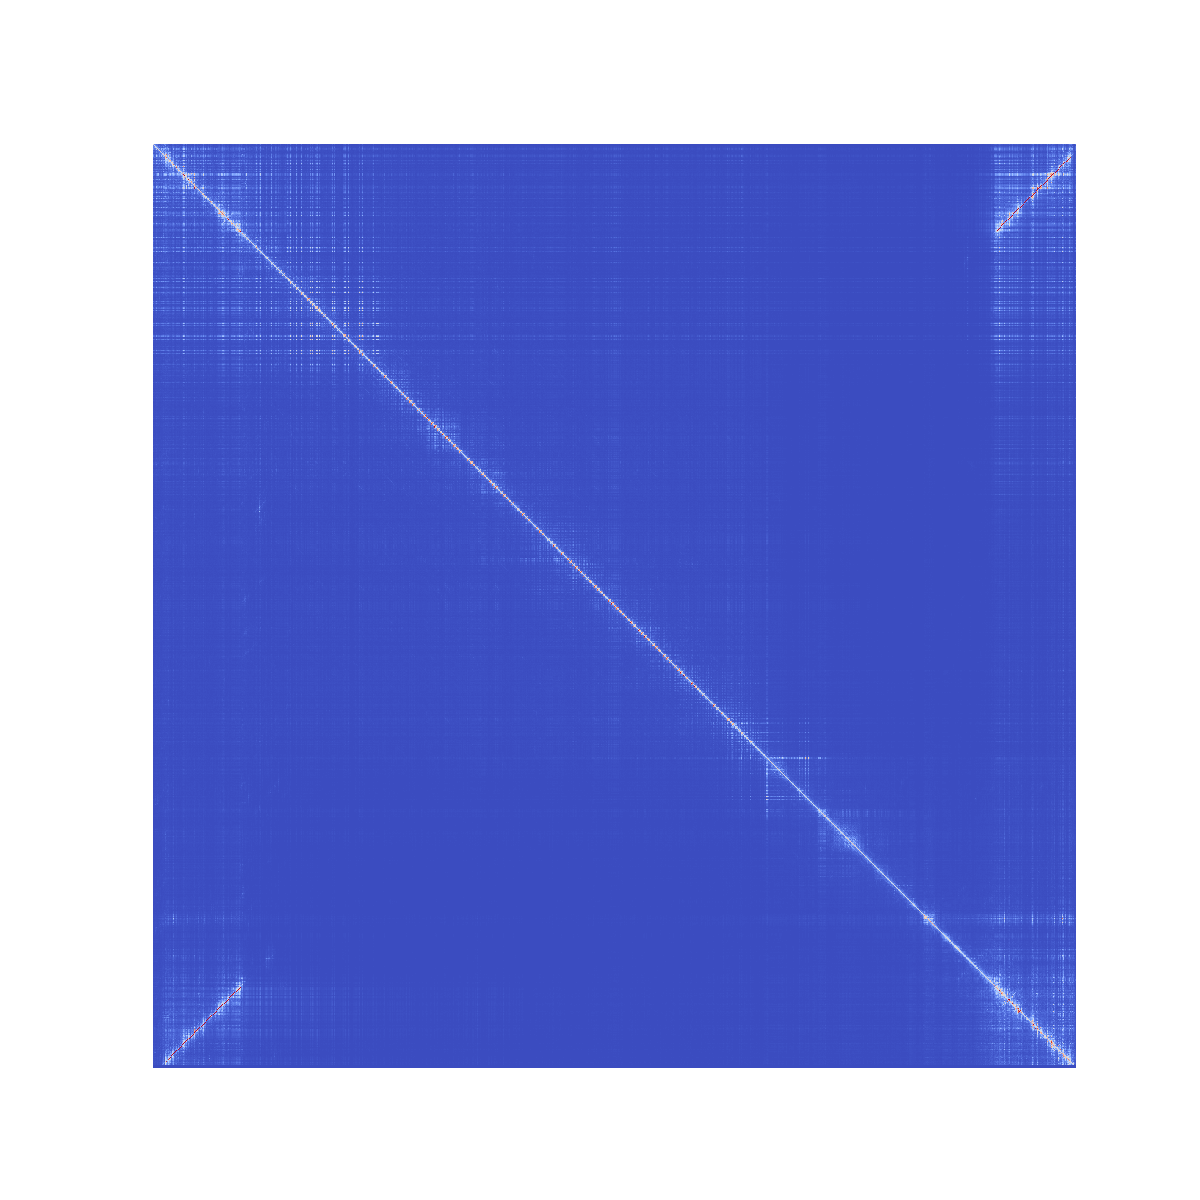

In [79]:
gene_id = 'YMR194W' 
gene_seq = s_cer_seqs_df[s_cer_seqs_df.gene_id==gene_id]['five_prime_seq'].values[0]
ci_matrix = compute_ci_matrix_random_revcomp(gene_seq,  repeat_length=90)
plot_ci_matrix(ci_matrix, vmax=8)

Map (num_proc=20):   0%|          | 0/3010 [00:00<?, ? examples/s]

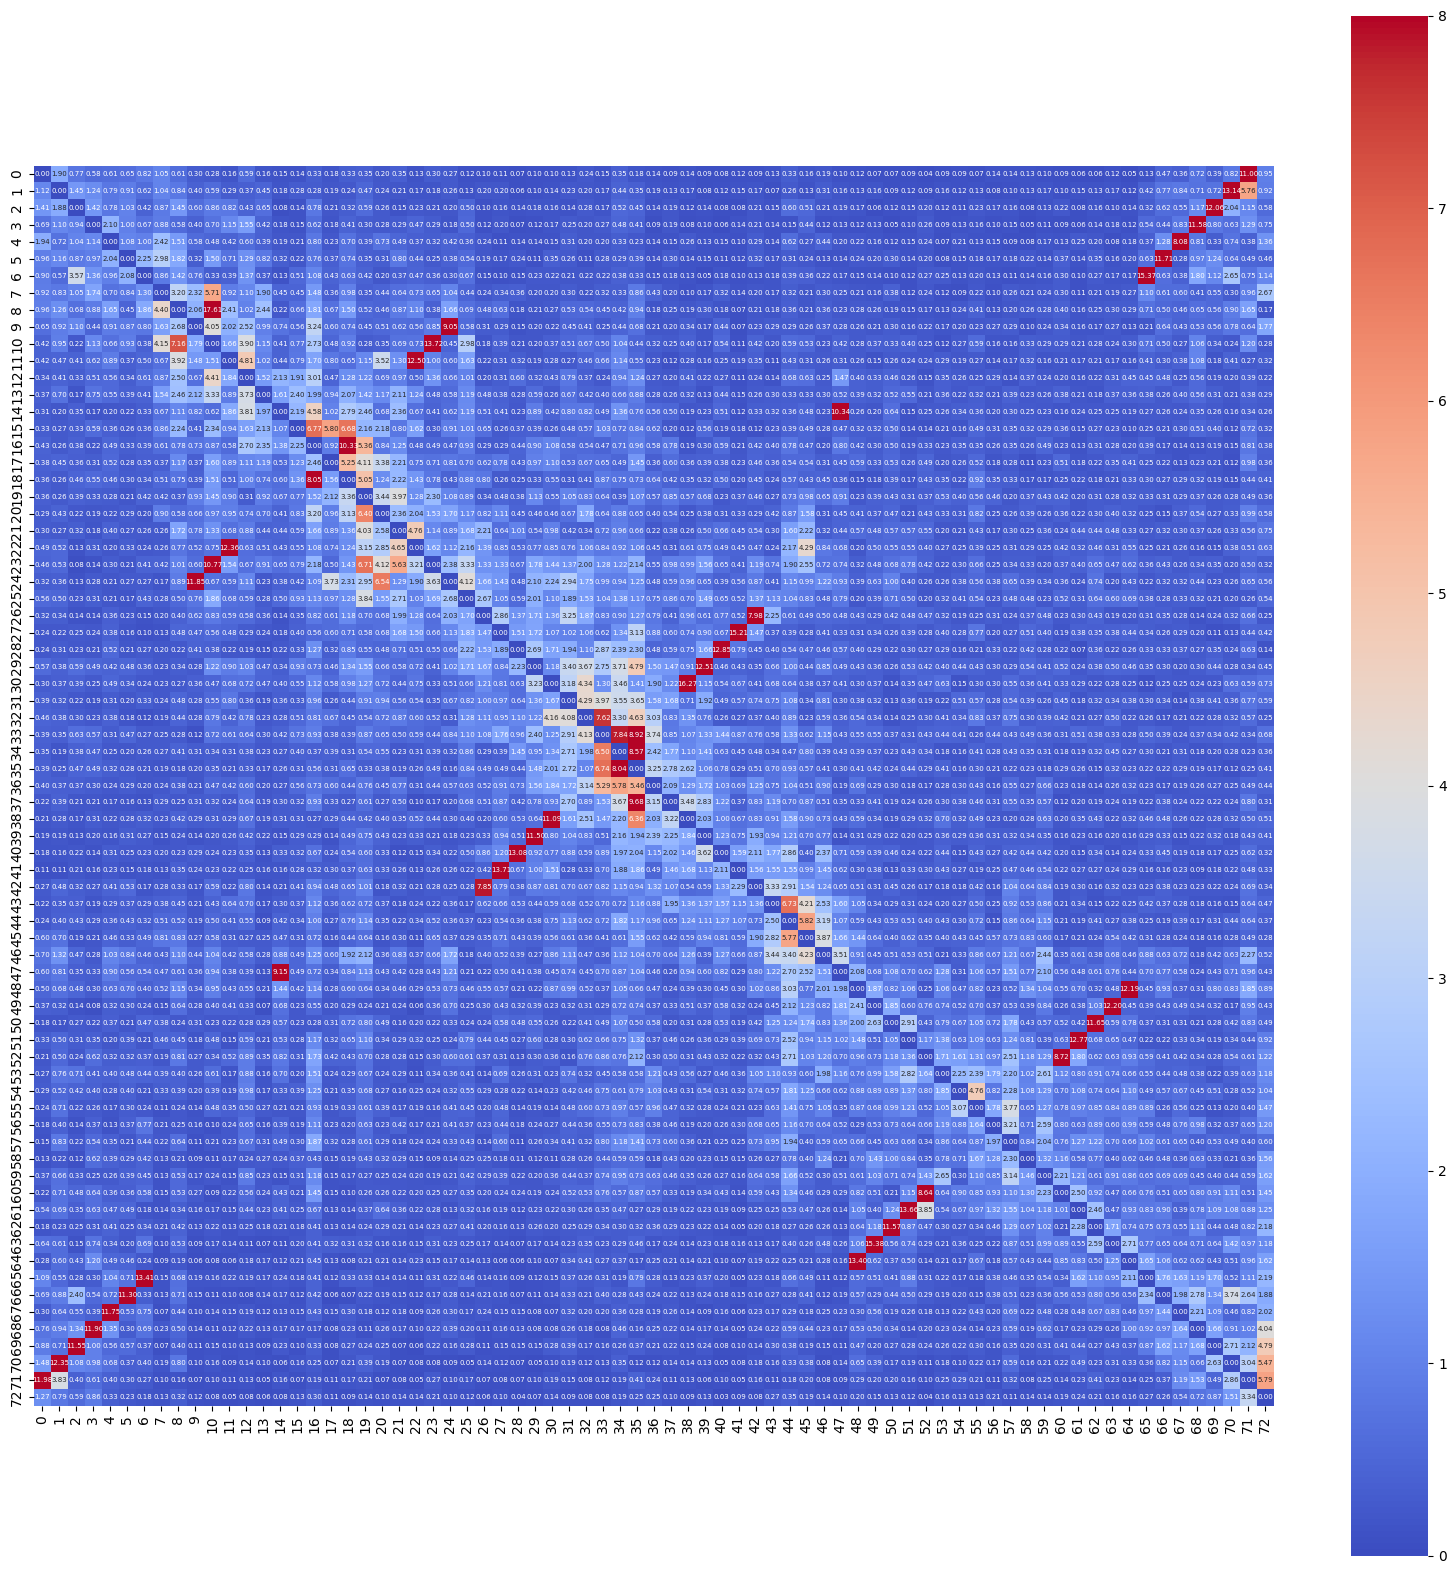

In [16]:
gene_id = 'YOR007C' 
gene_seq = s_cer_seqs_df[s_cer_seqs_df.gene_id==gene_id]['five_prime_seq'].values[0]
ci_matrix = compute_ci_matrix(gene_seq, proxy_species=proxy_species)
ci_matrix[np.arange(ci_matrix.shape[0]),np.arange(ci_matrix.shape[0])] = 0 
plot_ci_matrix(ci_matrix[607: 680, 607: 680], display_values=True, fig_size=20, annot_size=5, vmax=8)

## Compute probability of getting base pairing sequences by chance on a random sequence

In [16]:
import random
import string

def is_rev_comp(seq1, seq2, allow_wobble=True):
    for el in zip(seq1, seq2[::-1]):
        if el[0] == 'A' and el[1] == 'T':
            continue
        elif el[0] == 'T' and el[1] == 'A':
            continue
        elif el[0] == 'C' and el[1] == 'G':
            continue
        elif el[0] == 'G' and el[1] == 'C':
            continue
        elif allow_wobble and el[0] == 'G' and el[1] == 'T':
            continue
        elif allow_wobble and el[0] == 'T' and el[1] == 'G':
            continue
        else:
            return False
    
    return True

In [ ]:
seq = gene_seq[783: 855]
n=5
seq_length = len(seq)
n_rev_comps = 0
for i in range(seq_length-n+1):
    subseq = seq[i:i+n]
    for j in range(seq_length-n+1):
        if (j>=(i-n)) and (j<(i+n)): # sequences overlap
            continue
        subseq2 = seq[j:j+n]
        
        assert len(subseq) == len(subseq2)
        if is_rev_comp(subseq, subseq2):
            print(f'{subseq} is reverse complement of {subseq2}')
            n_rev_comps += 1

In [19]:
import random
import string

wobble_complement = {
    'A': 'T',
    'C': 'G',
    'G': lambda: random.choice(['C', 'T']),  # G can pair with C or T(U)
    'T': lambda: random.choice(['A', 'G'])   # T(U) can pair with A or G
}

watson_crick_complemment = {
    'A': 'T',
    'C': 'G',
    'G': 'C',
    'T': 'A'
}

def insert_random_revcomp(seq, random_seq_length = 14, allow_wobble = True):

    seq_length = len(seq)

    if seq_length < random_seq_length:
        raise ValueError("Gene sequence is too short for the random sequence")

    # randomly select p1
    p1 = random.randint(0, seq_length - random_seq_length)

    # define ranges for p2 selection, excluding the region occupied by p1 and its random sequence
    p2_range1 = range(0, p1-random_seq_length) 
    p2_range2 = range(p1 + random_seq_length, seq_length - random_seq_length) 

    combined_ranges = list(p2_range1) + list(p2_range2)
    if not combined_ranges:
        raise ValueError("No suitable position found for p2")
    p2 = random.choice(combined_ranges)

    random_seq = ''.join(random.choices('ACGT', k=random_seq_length))

    reverse_complement = ''
    for base in random_seq[::-1]:
        complement = wobble_complement[base] if allow_wobble else watson_crick_complemment[base]
        reverse_complement += complement() if callable(complement) else complement # if the complement is a function, call it
    
    seq = seq[:p1] + random_seq + seq[p1+random_seq_length:]
    seq = seq[:p2] + reverse_complement + seq[p2+random_seq_length:]
    
    return p1, p2, seq

In [20]:
insert_random_revcomp('ATGTGTGTGAGAGGA',random_seq_length=5)

(10, 0, 'GGTGTTGTGAGTATT')

In [21]:
window_seq

NameError: name 'window_seq' is not defined

57 75 AGGTAGTGTCTAATTGGAGTAGTCCTCCTTTGTGTTATGTGTTCTGTAGGAGAATTTCAAGTGCAGCCACATATTATGTGGCTGCACTTGTGCCGAAATT


Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

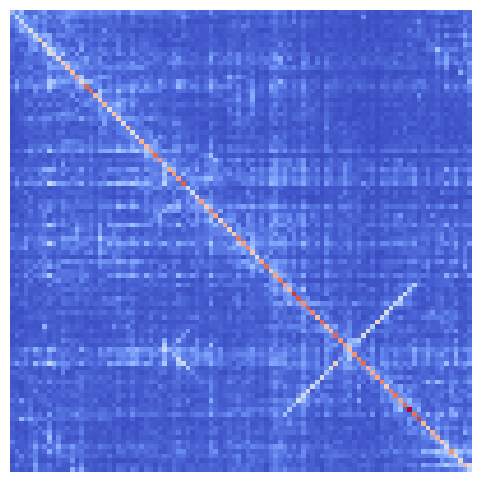

In [59]:
p1,p2,a_seq = insert_random_revcomp(window_seq, random_seq_length=15, allow_wobble=False)
print(p1,p2,a_seq)
ci_matrix = compute_ci_matrix(a_seq, proxy_species=proxy_species)
#plot_ci_matrix(ci_matrix, display_values=True, fig_size=20, annot_size=5)
plot_ci_matrix(ci_matrix)

In [72]:
from tqdm import tqdm

seq_length = 100
n_natural_seqs_to_sample = 20
n_windows_to_sample = 5
len_repeats_to_check = np.arange(2,21)
avg_occurences_list = []
avg_interaction_values_list = []
natural_seqs = list(s_cer_seqs_df['five_prime_seq'].dropna().sample(n_natural_seqs_to_sample).values)
avg_interaction_values_df = pd.DataFrame(index=np.arange(n_natural_seqs_to_sample*n_windows_to_sample))

for n in len_repeats_to_check:

    print('n ', n)
    n_rev_comps_list = []
    avg_interaction_values_n_list = []

    for l in tqdm(range(n_natural_seqs_to_sample)):
        
        for k in range(n_windows_to_sample):

            window_seq, _, _ = shuffle_sequence_sample_window(natural_seqs[l], window_size=seq_length)
            p1, p2, window_seq_w_revcomp = insert_random_revcomp(window_seq, random_seq_length=n, allow_wobble=False)
            ci_matrix = compute_ci_matrix(window_seq_w_revcomp, proxy_species=proxy_species)

            avg_ci_value = np.concatenate((ci_matrix[np.arange(p1, p1+n), np.arange(p2, p2+n)[::-1]], 
                ci_matrix[np.arange(p2, p2+n), np.arange(p1, p1+n)[::-1]])).mean() # take the average of the two diagonals

            avg_interaction_values_n_list.append(avg_ci_value)

    avg_interaction_values_df[f'{n}'] = avg_interaction_values_n_list

n  2


  0%|          | 0/20 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

  5%|▌         | 1/20 [00:08<02:50,  8.97s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 10%|█         | 2/20 [00:18<02:42,  9.04s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 15%|█▌        | 3/20 [00:27<02:33,  9.00s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 20%|██        | 4/20 [00:36<02:26,  9.13s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 25%|██▌       | 5/20 [00:45<02:16,  9.09s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 30%|███       | 6/20 [00:54<02:06,  9.00s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 35%|███▌      | 7/20 [01:03<01:57,  9.04s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 40%|████      | 8/20 [01:12<01:48,  9.01s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 45%|████▌     | 9/20 [01:21<01:39,  9.04s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 50%|█████     | 10/20 [01:30<01:29,  8.96s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 55%|█████▌    | 11/20 [01:38<01:20,  8.90s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 60%|██████    | 12/20 [01:47<01:11,  8.92s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 65%|██████▌   | 13/20 [01:56<01:02,  8.94s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 70%|███████   | 14/20 [02:06<00:54,  9.03s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 75%|███████▌  | 15/20 [02:14<00:44,  8.99s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 80%|████████  | 16/20 [02:23<00:35,  8.98s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 85%|████████▌ | 17/20 [02:32<00:26,  8.99s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 90%|█████████ | 18/20 [02:42<00:18,  9.19s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 95%|█████████▌| 19/20 [02:51<00:09,  9.16s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

100%|██████████| 20/20 [03:00<00:00,  9.04s/it]


n  3


  0%|          | 0/20 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

  5%|▌         | 1/20 [00:09<02:55,  9.24s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 10%|█         | 2/20 [00:18<02:44,  9.13s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 15%|█▌        | 3/20 [00:27<02:34,  9.09s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 20%|██        | 4/20 [00:36<02:23,  8.99s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 25%|██▌       | 5/20 [00:45<02:15,  9.02s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 30%|███       | 6/20 [00:54<02:05,  9.00s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 35%|███▌      | 7/20 [01:03<01:56,  8.97s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 40%|████      | 8/20 [01:12<01:48,  9.06s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 45%|████▌     | 9/20 [01:21<01:39,  9.06s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 50%|█████     | 10/20 [01:30<01:30,  9.05s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 55%|█████▌    | 11/20 [01:39<01:21,  9.06s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 60%|██████    | 12/20 [01:48<01:12,  9.02s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 65%|██████▌   | 13/20 [01:57<01:03,  9.02s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 70%|███████   | 14/20 [02:06<00:54,  9.00s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 75%|███████▌  | 15/20 [02:15<00:44,  8.99s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 80%|████████  | 16/20 [02:24<00:35,  8.99s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 85%|████████▌ | 17/20 [02:33<00:27,  9.04s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 90%|█████████ | 18/20 [02:42<00:18,  9.04s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 95%|█████████▌| 19/20 [02:51<00:09,  9.03s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

100%|██████████| 20/20 [03:00<00:00,  9.03s/it]


n  4


  0%|          | 0/20 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

  5%|▌         | 1/20 [00:09<02:51,  9.02s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 10%|█         | 2/20 [00:17<02:41,  8.98s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 15%|█▌        | 3/20 [00:26<02:33,  9.00s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 20%|██        | 4/20 [00:36<02:25,  9.07s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 25%|██▌       | 5/20 [00:45<02:17,  9.15s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 30%|███       | 6/20 [00:54<02:07,  9.11s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 35%|███▌      | 7/20 [01:03<01:57,  9.05s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 40%|████      | 8/20 [01:12<01:48,  9.00s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 45%|████▌     | 9/20 [01:21<01:39,  9.00s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 50%|█████     | 10/20 [01:30<01:30,  9.06s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 55%|█████▌    | 11/20 [01:39<01:21,  9.04s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 60%|██████    | 12/20 [01:48<01:12,  9.02s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 65%|██████▌   | 13/20 [01:57<01:02,  9.00s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 70%|███████   | 14/20 [02:06<00:53,  8.99s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 75%|███████▌  | 15/20 [02:15<00:44,  8.97s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 80%|████████  | 16/20 [02:24<00:35,  9.00s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 85%|████████▌ | 17/20 [02:33<00:27,  9.03s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 90%|█████████ | 18/20 [02:42<00:18,  9.07s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 95%|█████████▌| 19/20 [02:51<00:09,  9.07s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

100%|██████████| 20/20 [03:00<00:00,  9.04s/it]


n  5


  0%|          | 0/20 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

  5%|▌         | 1/20 [00:09<02:51,  9.00s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 10%|█         | 2/20 [00:17<02:40,  8.92s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 15%|█▌        | 3/20 [00:26<02:32,  8.95s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 20%|██        | 4/20 [00:35<02:24,  9.01s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 25%|██▌       | 5/20 [00:45<02:16,  9.08s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 30%|███       | 6/20 [00:54<02:06,  9.04s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 35%|███▌      | 7/20 [01:03<01:57,  9.02s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 40%|████      | 8/20 [01:11<01:47,  8.98s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 45%|████▌     | 9/20 [01:20<01:38,  8.95s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 50%|█████     | 10/20 [01:29<01:29,  8.97s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 55%|█████▌    | 11/20 [01:38<01:20,  8.95s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 60%|██████    | 12/20 [01:48<01:12,  9.09s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 65%|██████▌   | 13/20 [01:57<01:03,  9.14s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 70%|███████   | 14/20 [02:06<00:54,  9.09s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 75%|███████▌  | 15/20 [02:15<00:45,  9.03s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 80%|████████  | 16/20 [02:24<00:36,  9.02s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 85%|████████▌ | 17/20 [02:33<00:27,  9.06s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 90%|█████████ | 18/20 [02:42<00:17,  8.99s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 95%|█████████▌| 19/20 [02:51<00:09,  9.04s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

100%|██████████| 20/20 [03:00<00:00,  9.03s/it]


n  6


  0%|          | 0/20 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

  5%|▌         | 1/20 [00:09<02:55,  9.25s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 10%|█         | 2/20 [00:19<02:55,  9.76s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 15%|█▌        | 3/20 [00:28<02:42,  9.53s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 20%|██        | 4/20 [00:37<02:30,  9.39s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 25%|██▌       | 5/20 [00:47<02:20,  9.33s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 30%|███       | 6/20 [00:56<02:11,  9.36s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 35%|███▌      | 7/20 [01:05<02:01,  9.32s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 40%|████      | 8/20 [01:14<01:51,  9.28s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 45%|████▌     | 9/20 [01:24<01:41,  9.24s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 50%|█████     | 10/20 [01:33<01:32,  9.23s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 55%|█████▌    | 11/20 [01:42<01:23,  9.27s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 60%|██████    | 12/20 [01:51<01:13,  9.20s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 65%|██████▌   | 13/20 [02:00<01:04,  9.19s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 70%|███████   | 14/20 [02:09<00:55,  9.19s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 75%|███████▌  | 15/20 [02:19<00:45,  9.16s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 80%|████████  | 16/20 [02:28<00:36,  9.12s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 85%|████████▌ | 17/20 [02:37<00:27,  9.12s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 90%|█████████ | 18/20 [02:46<00:18,  9.14s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 95%|█████████▌| 19/20 [02:55<00:09,  9.13s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

100%|██████████| 20/20 [03:04<00:00,  9.25s/it]


n  7


  0%|          | 0/20 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

  5%|▌         | 1/20 [00:09<02:56,  9.30s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 10%|█         | 2/20 [00:18<02:44,  9.12s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 15%|█▌        | 3/20 [00:27<02:34,  9.08s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 20%|██        | 4/20 [00:36<02:26,  9.16s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 25%|██▌       | 5/20 [00:45<02:16,  9.08s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 30%|███       | 6/20 [00:54<02:07,  9.09s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 35%|███▌      | 7/20 [01:03<01:58,  9.11s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 40%|████      | 8/20 [01:13<01:50,  9.22s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 45%|████▌     | 9/20 [01:22<01:41,  9.19s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 50%|█████     | 10/20 [01:32<01:33,  9.37s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 55%|█████▌    | 11/20 [01:41<01:23,  9.26s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 60%|██████    | 12/20 [01:50<01:13,  9.21s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 65%|██████▌   | 13/20 [01:59<01:04,  9.28s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 70%|███████   | 14/20 [02:08<00:55,  9.24s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 75%|███████▌  | 15/20 [02:18<00:46,  9.30s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 80%|████████  | 16/20 [02:27<00:36,  9.22s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 85%|████████▌ | 17/20 [02:36<00:27,  9.23s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 90%|█████████ | 18/20 [02:46<00:18,  9.33s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 95%|█████████▌| 19/20 [02:55<00:09,  9.27s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

100%|██████████| 20/20 [03:04<00:00,  9.22s/it]


n  8


  0%|          | 0/20 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

  5%|▌         | 1/20 [00:09<02:58,  9.39s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 10%|█         | 2/20 [00:19<02:51,  9.53s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 15%|█▌        | 3/20 [00:28<02:44,  9.66s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 20%|██        | 4/20 [00:38<02:37,  9.83s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 25%|██▌       | 5/20 [00:48<02:28,  9.89s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 30%|███       | 6/20 [00:58<02:18,  9.91s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 35%|███▌      | 7/20 [01:08<02:09,  9.94s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 40%|████      | 8/20 [01:18<01:59,  9.98s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 45%|████▌     | 9/20 [01:28<01:49, 10.00s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 50%|█████     | 10/20 [01:38<01:39,  9.97s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 55%|█████▌    | 11/20 [01:48<01:29,  9.99s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 60%|██████    | 12/20 [01:58<01:18,  9.82s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 65%|██████▌   | 13/20 [02:07<01:07,  9.64s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 70%|███████   | 14/20 [02:16<00:56,  9.46s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 75%|███████▌  | 15/20 [02:25<00:47,  9.40s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 80%|████████  | 16/20 [02:35<00:37,  9.35s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 85%|████████▌ | 17/20 [02:44<00:27,  9.29s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 90%|█████████ | 18/20 [02:53<00:18,  9.26s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 95%|█████████▌| 19/20 [03:03<00:09,  9.53s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

100%|██████████| 20/20 [03:13<00:00,  9.68s/it]


n  9


  0%|          | 0/20 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

  5%|▌         | 1/20 [00:10<03:12, 10.12s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 10%|█         | 2/20 [00:20<03:01, 10.09s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 15%|█▌        | 3/20 [00:30<02:51, 10.09s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 20%|██        | 4/20 [00:40<02:41, 10.10s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 25%|██▌       | 5/20 [00:50<02:30, 10.00s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 30%|███       | 6/20 [01:00<02:19,  9.98s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 35%|███▌      | 7/20 [01:10<02:09, 10.00s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 40%|████      | 8/20 [01:21<02:03, 10.29s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 45%|████▌     | 9/20 [01:31<01:52, 10.25s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 50%|█████     | 10/20 [01:41<01:41, 10.17s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 55%|█████▌    | 11/20 [01:51<01:31, 10.14s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 60%|██████    | 12/20 [02:01<01:20, 10.09s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 65%|██████▌   | 13/20 [02:11<01:10, 10.04s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 70%|███████   | 14/20 [02:21<01:00, 10.02s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 75%|███████▌  | 15/20 [02:31<00:50, 10.06s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 80%|████████  | 16/20 [02:41<00:40, 10.09s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 85%|████████▌ | 17/20 [02:51<00:30, 10.07s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 90%|█████████ | 18/20 [03:01<00:20, 10.01s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 95%|█████████▌| 19/20 [03:11<00:09,  9.96s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

100%|██████████| 20/20 [03:21<00:00, 10.07s/it]


n  10


  0%|          | 0/20 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

  5%|▌         | 1/20 [00:10<03:11, 10.05s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 10%|█         | 2/20 [00:20<03:01, 10.11s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 15%|█▌        | 3/20 [00:30<02:51, 10.07s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 20%|██        | 4/20 [00:40<02:41, 10.09s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 25%|██▌       | 5/20 [00:50<02:30, 10.05s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 30%|███       | 6/20 [01:00<02:20, 10.04s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 35%|███▌      | 7/20 [01:10<02:10, 10.07s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 40%|████      | 8/20 [01:20<02:01, 10.10s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 45%|████▌     | 9/20 [01:30<01:51, 10.11s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 50%|█████     | 10/20 [01:40<01:40, 10.05s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 55%|█████▌    | 11/20 [01:51<01:31, 10.16s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 60%|██████    | 12/20 [02:01<01:20, 10.12s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 65%|██████▌   | 13/20 [02:10<01:10, 10.03s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 70%|███████   | 14/20 [02:20<01:00, 10.01s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 75%|███████▌  | 15/20 [02:31<00:50, 10.05s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 80%|████████  | 16/20 [02:41<00:40, 10.07s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 85%|████████▌ | 17/20 [02:51<00:30, 10.05s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 90%|█████████ | 18/20 [03:01<00:20, 10.02s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 95%|█████████▌| 19/20 [03:11<00:10, 10.03s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

100%|██████████| 20/20 [03:21<00:00, 10.06s/it]


n  11


  0%|          | 0/20 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

  5%|▌         | 1/20 [00:09<03:09,  9.97s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 10%|█         | 2/20 [00:19<02:59,  9.98s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 15%|█▌        | 3/20 [00:29<02:48,  9.90s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 20%|██        | 4/20 [00:39<02:37,  9.86s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 25%|██▌       | 5/20 [00:49<02:28,  9.87s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 30%|███       | 6/20 [00:59<02:18,  9.91s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 35%|███▌      | 7/20 [01:09<02:08,  9.90s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 40%|████      | 8/20 [01:19<01:59,  9.94s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 45%|████▌     | 9/20 [01:29<01:50, 10.05s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 50%|█████     | 10/20 [01:39<01:40, 10.01s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 55%|█████▌    | 11/20 [01:49<01:29,  9.98s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 60%|██████    | 12/20 [01:59<01:19,  9.98s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 65%|██████▌   | 13/20 [02:09<01:09,  9.99s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 70%|███████   | 14/20 [02:19<01:00, 10.01s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 75%|███████▌  | 15/20 [02:29<00:50, 10.00s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 80%|████████  | 16/20 [02:39<00:39,  9.96s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 85%|████████▌ | 17/20 [02:49<00:29,  9.98s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 90%|█████████ | 18/20 [02:59<00:19,  9.92s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 95%|█████████▌| 19/20 [03:08<00:09,  9.88s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

100%|██████████| 20/20 [03:18<00:00,  9.94s/it]


n  12


  0%|          | 0/20 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

  5%|▌         | 1/20 [00:10<03:10, 10.01s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 10%|█         | 2/20 [00:19<02:59,  9.96s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 15%|█▌        | 3/20 [00:29<02:48,  9.90s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 20%|██        | 4/20 [00:39<02:37,  9.87s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 25%|██▌       | 5/20 [00:49<02:28,  9.92s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 30%|███       | 6/20 [00:59<02:19,  9.96s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 35%|███▌      | 7/20 [01:09<02:09,  9.98s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 40%|████      | 8/20 [01:19<01:59,  9.93s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 45%|████▌     | 9/20 [01:29<01:49,  9.92s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 50%|█████     | 10/20 [01:39<01:38,  9.88s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 55%|█████▌    | 11/20 [01:49<01:28,  9.87s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 60%|██████    | 12/20 [01:58<01:18,  9.86s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 65%|██████▌   | 13/20 [02:08<01:09,  9.90s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 70%|███████   | 14/20 [02:18<00:59,  9.92s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 75%|███████▌  | 15/20 [02:28<00:49,  9.95s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 80%|████████  | 16/20 [02:38<00:39,  9.96s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 85%|████████▌ | 17/20 [02:48<00:29,  9.93s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 90%|█████████ | 18/20 [02:59<00:20, 10.18s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 95%|█████████▌| 19/20 [03:09<00:10, 10.14s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

100%|██████████| 20/20 [03:19<00:00,  9.98s/it]


n  13


  0%|          | 0/20 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

  5%|▌         | 1/20 [00:10<03:11, 10.08s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 10%|█         | 2/20 [00:19<02:59,  9.97s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 15%|█▌        | 3/20 [00:29<02:48,  9.90s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 20%|██        | 4/20 [00:39<02:37,  9.87s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 25%|██▌       | 5/20 [00:49<02:28,  9.89s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 30%|███       | 6/20 [00:59<02:18,  9.89s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 35%|███▌      | 7/20 [01:09<02:08,  9.88s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 40%|████      | 8/20 [01:18<01:56,  9.69s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 45%|████▌     | 9/20 [01:27<01:45,  9.57s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 50%|█████     | 10/20 [01:36<01:33,  9.40s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 55%|█████▌    | 11/20 [01:45<01:23,  9.25s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 60%|██████    | 12/20 [01:55<01:13,  9.25s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 65%|██████▌   | 13/20 [02:04<01:04,  9.27s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 70%|███████   | 14/20 [02:13<00:55,  9.22s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 75%|███████▌  | 15/20 [02:22<00:46,  9.28s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 80%|████████  | 16/20 [02:31<00:36,  9.21s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 85%|████████▌ | 17/20 [02:41<00:27,  9.19s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 90%|█████████ | 18/20 [02:50<00:18,  9.12s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 95%|█████████▌| 19/20 [02:59<00:09,  9.08s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

100%|██████████| 20/20 [03:07<00:00,  9.39s/it]


n  14


  0%|          | 0/20 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

  5%|▌         | 1/20 [00:08<02:48,  8.88s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 10%|█         | 2/20 [00:17<02:42,  9.01s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 15%|█▌        | 3/20 [00:27<02:34,  9.06s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 20%|██        | 4/20 [00:36<02:26,  9.13s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 25%|██▌       | 5/20 [00:45<02:16,  9.07s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 30%|███       | 6/20 [00:54<02:06,  9.05s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 35%|███▌      | 7/20 [01:03<01:57,  9.07s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 40%|████      | 8/20 [01:12<01:48,  9.08s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 45%|████▌     | 9/20 [01:21<01:39,  9.08s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 50%|█████     | 10/20 [01:30<01:30,  9.08s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 55%|█████▌    | 11/20 [01:39<01:21,  9.06s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 60%|██████    | 12/20 [01:48<01:12,  9.02s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 65%|██████▌   | 13/20 [01:57<01:03,  9.04s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 70%|███████   | 14/20 [02:06<00:54,  9.04s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 75%|███████▌  | 15/20 [02:15<00:45,  9.05s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 80%|████████  | 16/20 [02:24<00:36,  9.06s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 85%|████████▌ | 17/20 [02:34<00:27,  9.08s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 90%|█████████ | 18/20 [02:43<00:18,  9.11s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 95%|█████████▌| 19/20 [02:52<00:09,  9.19s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

100%|██████████| 20/20 [03:01<00:00,  9.08s/it]


n  15


  0%|          | 0/20 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

  5%|▌         | 1/20 [00:09<02:53,  9.15s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 10%|█         | 2/20 [00:18<02:44,  9.13s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 15%|█▌        | 3/20 [00:27<02:34,  9.12s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 20%|██        | 4/20 [00:36<02:25,  9.11s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 25%|██▌       | 5/20 [00:45<02:16,  9.09s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 30%|███       | 6/20 [00:54<02:06,  9.07s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 35%|███▌      | 7/20 [01:03<01:57,  9.03s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 40%|████      | 8/20 [01:12<01:48,  9.05s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 45%|████▌     | 9/20 [01:21<01:40,  9.15s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 50%|█████     | 10/20 [01:31<01:31,  9.12s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 55%|█████▌    | 11/20 [01:40<01:21,  9.09s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 60%|██████    | 12/20 [01:49<01:12,  9.07s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 65%|██████▌   | 13/20 [01:58<01:03,  9.04s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 70%|███████   | 14/20 [02:07<00:54,  9.16s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 75%|███████▌  | 15/20 [02:16<00:45,  9.13s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 80%|████████  | 16/20 [02:25<00:36,  9.12s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 85%|████████▌ | 17/20 [02:34<00:27,  9.07s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 90%|█████████ | 18/20 [02:43<00:18,  9.06s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 95%|█████████▌| 19/20 [02:52<00:09,  9.08s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

100%|██████████| 20/20 [03:01<00:00,  9.10s/it]


n  16


  0%|          | 0/20 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

  5%|▌         | 1/20 [00:09<02:52,  9.10s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 10%|█         | 2/20 [00:18<02:44,  9.15s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 15%|█▌        | 3/20 [00:27<02:34,  9.11s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 20%|██        | 4/20 [00:36<02:25,  9.10s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 25%|██▌       | 5/20 [00:45<02:15,  9.04s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 30%|███       | 6/20 [00:54<02:07,  9.10s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 35%|███▌      | 7/20 [01:03<01:58,  9.09s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 40%|████      | 8/20 [01:12<01:49,  9.13s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 45%|████▌     | 9/20 [01:22<01:40,  9.15s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 50%|█████     | 10/20 [01:31<01:31,  9.17s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 55%|█████▌    | 11/20 [01:41<01:24,  9.43s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 60%|██████    | 12/20 [01:50<01:14,  9.32s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 65%|██████▌   | 13/20 [01:59<01:04,  9.26s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 70%|███████   | 14/20 [02:08<00:55,  9.21s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 75%|███████▌  | 15/20 [02:17<00:46,  9.21s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 80%|████████  | 16/20 [02:26<00:36,  9.18s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 85%|████████▌ | 17/20 [02:36<00:27,  9.20s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 90%|█████████ | 18/20 [02:45<00:18,  9.22s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 95%|█████████▌| 19/20 [02:54<00:09,  9.17s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

100%|██████████| 20/20 [03:03<00:00,  9.18s/it]


n  17


  0%|          | 0/20 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

  5%|▌         | 1/20 [00:09<02:52,  9.06s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 10%|█         | 2/20 [00:18<02:44,  9.11s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 15%|█▌        | 3/20 [00:27<02:36,  9.22s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 20%|██        | 4/20 [00:36<02:26,  9.18s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 25%|██▌       | 5/20 [00:45<02:17,  9.16s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 30%|███       | 6/20 [00:55<02:08,  9.19s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 35%|███▌      | 7/20 [01:04<01:58,  9.11s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 40%|████      | 8/20 [01:13<01:49,  9.11s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 45%|████▌     | 9/20 [01:22<01:40,  9.13s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 50%|█████     | 10/20 [01:31<01:31,  9.11s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 55%|█████▌    | 11/20 [01:40<01:21,  9.10s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 60%|██████    | 12/20 [01:49<01:12,  9.10s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 65%|██████▌   | 13/20 [01:58<01:03,  9.08s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 70%|███████   | 14/20 [02:07<00:54,  9.09s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 75%|███████▌  | 15/20 [02:16<00:45,  9.06s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 80%|████████  | 16/20 [02:25<00:36,  9.02s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 85%|████████▌ | 17/20 [02:34<00:27,  9.02s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 90%|█████████ | 18/20 [02:43<00:17,  8.95s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 95%|█████████▌| 19/20 [02:52<00:08,  8.93s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

100%|██████████| 20/20 [03:01<00:00,  9.07s/it]


n  18


  0%|          | 0/20 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

  5%|▌         | 1/20 [00:08<02:50,  8.99s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 10%|█         | 2/20 [00:18<02:43,  9.08s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 15%|█▌        | 3/20 [00:27<02:34,  9.10s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 20%|██        | 4/20 [00:36<02:25,  9.08s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 25%|██▌       | 5/20 [00:45<02:16,  9.11s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 30%|███       | 6/20 [00:54<02:07,  9.12s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 35%|███▌      | 7/20 [01:03<01:58,  9.09s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 40%|████      | 8/20 [01:12<01:49,  9.10s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 45%|████▌     | 9/20 [01:21<01:40,  9.09s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 50%|█████     | 10/20 [01:30<01:30,  9.09s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 55%|█████▌    | 11/20 [01:39<01:21,  9.07s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 60%|██████    | 12/20 [01:49<01:12,  9.10s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 65%|██████▌   | 13/20 [01:58<01:04,  9.15s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 70%|███████   | 14/20 [02:07<00:55,  9.19s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 75%|███████▌  | 15/20 [02:16<00:45,  9.11s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 80%|████████  | 16/20 [02:25<00:36,  9.10s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 85%|████████▌ | 17/20 [02:34<00:27,  9.13s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 90%|█████████ | 18/20 [02:43<00:18,  9.12s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 95%|█████████▌| 19/20 [02:52<00:09,  9.09s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

100%|██████████| 20/20 [03:02<00:00,  9.11s/it]


n  19


  0%|          | 0/20 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

  5%|▌         | 1/20 [00:09<02:52,  9.10s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 10%|█         | 2/20 [00:18<02:43,  9.08s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 15%|█▌        | 3/20 [00:27<02:35,  9.13s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 20%|██        | 4/20 [00:36<02:26,  9.13s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 25%|██▌       | 5/20 [00:45<02:16,  9.10s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 30%|███       | 6/20 [00:54<02:07,  9.09s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 35%|███▌      | 7/20 [01:03<01:59,  9.19s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 40%|████      | 8/20 [01:13<01:50,  9.25s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 45%|████▌     | 9/20 [01:22<01:41,  9.22s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 50%|█████     | 10/20 [01:31<01:31,  9.13s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 55%|█████▌    | 11/20 [01:40<01:22,  9.14s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 60%|██████    | 12/20 [01:49<01:13,  9.13s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 65%|██████▌   | 13/20 [01:58<01:03,  9.12s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 70%|███████   | 14/20 [02:08<00:55,  9.17s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 75%|███████▌  | 15/20 [02:17<00:45,  9.16s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 80%|████████  | 16/20 [02:26<00:36,  9.14s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 85%|████████▌ | 17/20 [02:35<00:27,  9.18s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 90%|█████████ | 18/20 [02:44<00:18,  9.15s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 95%|█████████▌| 19/20 [02:53<00:09,  9.14s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

100%|██████████| 20/20 [03:02<00:00,  9.15s/it]


n  20


  0%|          | 0/20 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

  5%|▌         | 1/20 [00:09<02:59,  9.43s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 10%|█         | 2/20 [00:18<02:47,  9.28s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 15%|█▌        | 3/20 [00:27<02:36,  9.19s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 20%|██        | 4/20 [00:37<02:29,  9.34s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 25%|██▌       | 5/20 [00:46<02:18,  9.26s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 30%|███       | 6/20 [00:55<02:11,  9.36s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 35%|███▌      | 7/20 [01:06<02:04,  9.59s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 40%|████      | 8/20 [01:17<02:00, 10.06s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 45%|████▌     | 9/20 [01:27<01:50, 10.04s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 50%|█████     | 10/20 [01:36<01:39, 10.00s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 55%|█████▌    | 11/20 [01:46<01:30, 10.00s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 60%|██████    | 12/20 [01:56<01:19,  9.95s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 65%|██████▌   | 13/20 [02:06<01:09,  9.95s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 70%|███████   | 14/20 [02:16<01:00, 10.01s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 75%|███████▌  | 15/20 [02:26<00:50, 10.02s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 80%|████████  | 16/20 [02:37<00:40, 10.08s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 85%|████████▌ | 17/20 [02:47<00:30, 10.10s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 90%|█████████ | 18/20 [02:57<00:20, 10.05s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 95%|█████████▌| 19/20 [03:07<00:10, 10.01s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

100%|██████████| 20/20 [03:17<00:00,  9.86s/it]


In [73]:
avg_interaction_values_df

2         3         4         5         6         7         8  \
0   1.722519  1.291030  2.117786  0.915530  1.327380  1.619039  2.262984   
1   1.172115  3.516274  2.097752  0.906373  3.115925  1.307191  1.552360   
2   1.275788  0.964044  1.406271  0.754906  1.705138  2.408390  3.552665   
3   1.098235  0.909494  1.459831  0.668806  1.467932  2.352404  4.143651   
4   1.662266  0.992497  0.546114  1.117166  2.134413  1.945663  1.512806   
..       ...       ...       ...       ...       ...       ...       ...   
95  0.866131  1.226338  1.966877  1.189208  1.949942  5.691111  4.124378   
96  1.032364  0.688609  1.663250  1.785860  1.640336  2.935274  3.372568   
97  1.138017  1.824802  1.086052  1.021321  2.035827  1.448207  3.881218   
98  0.771994  0.749371  0.973555  1.196363  0.776086  0.907664  1.497210   
99  0.474205  1.595821  0.769440  1.518974  1.401642  0.892550  1.669932   

           9        10        11        12        13        14        15  \
0   4.456310  4.716319  2.940939  4.248519  5.987659  4.941097  6.991610   
1   6.447309  3.608654  7.024693  6.780746  3.690278  5.524987  7.613335   
2   1.482481  3.815901  5.187861  6.151552  4.070304  4.657865  8.389236   
3   2.907290  1.767250  5.101863  9.212496  3.505959  5.582578  7.027212   
4   3.820429  5.939575  2.896973  5.204085  4.341557  4.863073  6.603554   
..       ...       ...       ...       ...       ...       ...       ...   
95  5.900083  3.363943  6.767784  3.033891  4.749861  6.480331  4.465023   
96  3.063739  2.131907  1.404902  5.755428  6.982783  6.730222  4.351110   
97  2.471336  4.583380  2.270982  9.445681  5.588371  3.465269  5.161538   
98  2.104542  2.745503  3.212307  4.946601  6.454554  5.918839  9.388673   
99  2.520694  1.976934  3.433517  3.930456  6.016445  6.829399  6.134960   

          16         17         18        19         20  
0   4.617537   4.539569  10.565178  9.149392   7.526243  
1   8.879550   6.466881   7.390843  7.463959   9.944187  
2   6.936475   9.240372   7.870777  7.956816   8.536524  
3   7.555647   7.990251   8.379143  6.062604   9.585476  
4   7.985245   7.946776   5.180141  8.388500   6.744212  
..       ...        ...        ...       ...        ...  
95  7.646875   6.946665   6.382630  6.498563   8.389770  
96  6.217852  10.406703   6.654349  8.184025  10.139683  
97  7.185549   7.276102   8.455939  7.857227   8.083749  
98  6.903180   8.106952   9.116546  6.457622   9.713408  
99  7.470872  10.225095   9.153306  8.058785   9.852668  

[100 rows x 19 columns]

In [74]:
avg_interaction_values_df.to_csv(os.path.join(data_path, 'avg_dependency_vs_revcomp_repeat_length_all_sims.tsv'), sep='\t', index=False)

In [22]:
cowplot_theme = lambda figure_size, font_size : theme(
    # Set the background to white and remove panel border
    panel_background=element_blank(),
    panel_border=element_blank(),

    # Light grey grid lines
    panel_grid_major=element_line(color='lightgrey', size=0.5),
    panel_grid_minor=element_line(color='lightgrey', size=0.5),

    # Minimize axis ticks
    #axis_ticks=element_blank(),
    #axis_text_x=element_text(rotation=45, hjust=1),

    # Simple font
    text=element_text(color='black'),
    #change x and y labels font size
    axis_text_x=element_text(size=font_size-2.5),
    axis_text_y=element_text(size=font_size-2.5),
    axis_title_x=element_text(size=font_size),
    axis_title_y=element_text(size=font_size),
    #change x and y axis ticks labels size
    figure_size = figure_size
)

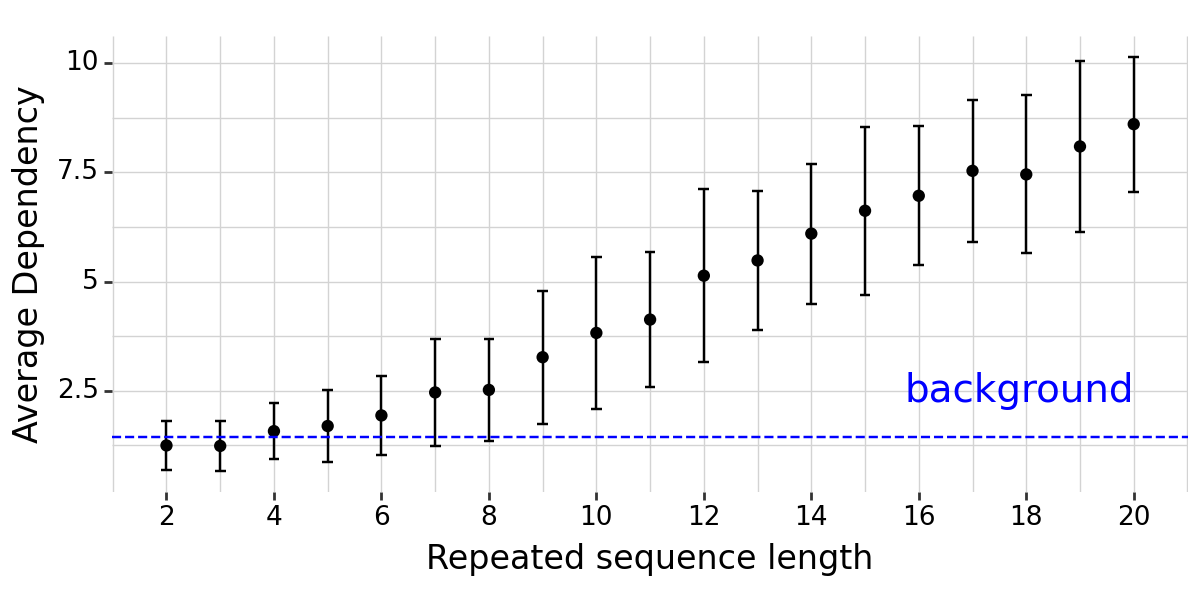

<Figure Size: (600 x 300)>

In [77]:
from plotnine import *

mean_values = avg_interaction_values_df.mean()
std_values = avg_interaction_values_df.std()

plot_df = pd.DataFrame({
    'k': mean_values.index.astype(int),
    'mean': mean_values.values,
    'std': std_values.values
})
mean_dependency = 1.44 # basepair notebook analysis provided this value as background_dependency
p = (
    ggplot(plot_df, aes(x='k', y='mean'))
    + geom_point()
    + geom_errorbar(aes(ymin='mean-std', ymax='mean+std'), width=0.2)
    + scale_x_continuous(breaks=list(range(2, 21, 2)))
    + labs(x='Repeated sequence length', y='Average Dependency')
    +geom_hline(yintercept=mean_dependency, linetype="dashed", color="blue")
    + annotate('text', x=20, y=mean_dependency+1.5, label='background', ha='right', va='top', color='blue', size=14)
    + cowplot_theme((6, 3), 12)
)
p

### Get all tRNA sequences in S. cerevisiae

In [ ]:
tRNA_scan_file = os.path.join(data_path, 'sacCer3-tRNAs.ss.sort')

In [19]:
def create_contact_matrix(structure):
    stack = []
    matrix_size = len(structure)
    contact_matrix = torch.zeros((matrix_size, matrix_size), dtype=int)

    for i, char in enumerate(structure):
        if char == '>':
            stack.append(i)
        elif char == '<' and stack:
            j = stack.pop()
            contact_matrix[i,j] = contact_matrix[j,i] = 1

    return contact_matrix
def create_contact_matrix(structure):
    stack = []
    matrix_size = len(structure)
    contact_matrix = torch.zeros((matrix_size, matrix_size), dtype=int)

    for i, char in enumerate(structure):
        if char == '>':
            stack.append(i)
        elif char == '<' and stack:
            j = stack.pop()
            contact_matrix[i,j] = contact_matrix[j,i] = 1

    return contact_matrix
def parse_trna_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    trna_data = []
    trna_name, location = None, None
    possible_intron = False
    for i, line in enumerate(lines):
        
        if line.strip() and not line.startswith((' ', '\t', 'Seq', 'Str', 'Type','HMM','Possible intron')):
            trna_name = line.split()[0]
            trna_chromosome = trna_name.split('.')[0].strip('chr')
            trna_id = trna_name.split('.')[1]
            location = line.split('(')[1].split(')')[0]
            start = int(location.split('-')[0])
            end = int(location.split('-')[1])
            # star is not always smaller than end. Maybe negative strand tRNAs
            if start > end:
                start, end = end, start 
            start = start - 1 #adjust to 0-based coordinates
            assert end > start, f'end: {end} should be greater than start: {start}'

        elif line.startswith('Type:'):
            score = float(line.split('Score:')[1].strip())
        elif line.startswith('Seq:'):
            sequence = line.split(':')[1].strip().upper()
        elif line.startswith('Possible intron'):
            possible_intron = True
        elif line.startswith('Str:'):
            structure = line.split(':')[1].strip()
            contact_matrix = create_contact_matrix(structure)
            trna_data.append([trna_id, trna_chromosome, start, end, sequence, structure, score, possible_intron, contact_matrix])
            possible_intron = False

    return pd.DataFrame(trna_data, columns=['trna_scan_id', 'Chromosome', 'Start', 'End', 'tRNA_scan_sequence', 'structure_string', 'score', 'possible_intron', 'contact_matrix'])

In [20]:
tRNA_scan_df = parse_trna_file(tRNA_scan_file)
tRNA_scan_df

trna_scan_id Chromosome    Start      End  \
0          trna3         IV   410378   410451   
1          trna6         VI   204923   204996   
2         trna15        VII   774348   774421   
3          trna8       VIII   146241   146314   
4         trna22          X   197312   197385   
..           ...        ...      ...      ...   
270       trna16       XIII   372444   372518   
271       trna20         IV  1075471  1075544   
272        trna4       VIII   475705   475778   
273       trna12         II   326791   326865   
274       trna27         IV   488796   488870   

                                    tRNA_scan_sequence  \
0    GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGG...   
1    GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGG...   
2    GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGG...   
3    GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGG...   
4    GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGG...   
..                                                 ...   
270  GGTTTCGTGGTCTAGTCGGTTATGGCATCTGCTTAACACGCAGAAC...   
271  GTTCCAATAGTGTAGCGGCTATCACGTTGCCTTCACACGGCAAAGG...   
272  GTTCCAATAGTGTAGCGGCTATCACGTTGCCTTCACACGGCAAAGG...   
273  GGTCCAATGGTCCAGTGGTTCAAGACGTCGCCTTTACACGGCGAAG...   
274  GGTCCAATGGTCCAGTGGTTCAAGACGTCGCCTTTACACGGCGAAG...   

                                      structure_string  score  \
0    >>>>>.>..>>>>........<<<<.>>>>>.......<<<<<......   69.6   
1    >>>>>.>..>>>>........<<<<.>>>>>.......<<<<<......   69.6   
2    >>>>>.>..>>>>........<<<<.>>>>>.......<<<<<......   69.6   
3    >>>>>.>..>>>>........<<<<.>>>>>.......<<<<<......   69.6   
4    >>>>>.>..>>>>........<<<<.>>>>>.......<<<<<......   69.6   
..                                                 ...    ...   
270  >>>>>>>..>>>...........<<<.>>>>>.......<<<<<.....   67.6   
271  >>>>>>>..>>>..........<<<.>>>>>.......<<<<<......   70.5   
272  >>>>>>>..>>>..........<<<.>>>>>.......<<<<<......   70.5   
273  >>>>>>>..>>>...........<<<.>>>>>.......<<<<<.....   70.3   
274  >>>>>>>..>>>...........<<<.>>>>>.......<<<<<.....   70.3   

     possible_intron                                     contact_matrix  
0              False  [[tensor(0), tensor(0), tensor(0), tensor(0), ...  
1              False  [[tensor(0), tensor(0), tensor(0), tensor(0), ...  
2              False  [[tensor(0), tensor(0), tensor(0), tensor(0), ...  
3              False  [[tensor(0), tensor(0), tensor(0), tensor(0), ...  
4              False  [[tensor(0), tensor(0), tensor(0), tensor(0), ...  
..               ...                                                ...  
270            False  [[tensor(0), tensor(0), tensor(0), tensor(0), ...  
271            False  [[tensor(0), tensor(0), tensor(0), tensor(0), ...  
272            False  [[tensor(0), tensor(0), tensor(0), tensor(0), ...  
273            False  [[tensor(0), tensor(0), tensor(0), tensor(0), ...  
274            False  [[tensor(0), tensor(0), tensor(0), tensor(0), ...  

[275 rows x 9 columns]

In [21]:
def detect_all_stem_lengths(dot_bracket, only_consecutive=False):
    stems = []
    current_stem_length = 0
    skip_dot = False

    for i in range(len(dot_bracket)):
        if dot_bracket[i] == '>':
            if only_consecutive:
                if i > 0 and dot_bracket[i-1] == '>':
                    current_stem_length += 1
                else:
                    if current_stem_length > 0:
                        stems.append(current_stem_length)
                    current_stem_length = 1
            else:
                current_stem_length += 1
        elif dot_bracket[i] == '.':
            if not only_consecutive:
                if i > 0 and dot_bracket[i-1] == '>' and not skip_dot:
                    skip_dot = True
                else:
                    if current_stem_length > 0:
                        stems.append(current_stem_length)
                        current_stem_length = 0
                    skip_dot = False
            else:
                if current_stem_length > 0:
                    stems.append(current_stem_length)
                    current_stem_length = 0
        else:
            if current_stem_length > 0:
                stems.append(current_stem_length)
                current_stem_length = 0
            skip_dot = False

    if current_stem_length > 0:
        stems.append(current_stem_length)

    return np.array(list(set(stems)))


dot_bracket = '>.>>>..>>>...>>'
print(detect_all_stem_lengths(dot_bracket, only_consecutive=True))



dot_bracket = '>.>>>..>>>...>>'
print(detect_all_stem_lengths(dot_bracket))


[1 2 3]
[2 3 4]


In [22]:
tRNA_scan_df['len_unique_stems'] = tRNA_scan_df['structure_string'].apply(detect_all_stem_lengths)
tRNA_scan_df['len_unique_consecutive_stems'] = tRNA_scan_df['structure_string'].apply(detect_all_stem_lengths, only_consecutive=True)
tRNA_scan_df

trna_scan_id Chromosome    Start      End  \
0          trna3         IV   410378   410451   
1          trna6         VI   204923   204996   
2         trna15        VII   774348   774421   
3          trna8       VIII   146241   146314   
4         trna22          X   197312   197385   
..           ...        ...      ...      ...   
270       trna16       XIII   372444   372518   
271       trna20         IV  1075471  1075544   
272        trna4       VIII   475705   475778   
273       trna12         II   326791   326865   
274       trna27         IV   488796   488870   

                                    tRNA_scan_sequence  \
0    GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGG...   
1    GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGG...   
2    GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGG...   
3    GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGG...   
4    GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGG...   
..                                                 ...   
270  GGTTTCGTGGTCTAGTCGGTTATGGCATCTGCTTAACACGCAGAAC...   
271  GTTCCAATAGTGTAGCGGCTATCACGTTGCCTTCACACGGCAAAGG...   
272  GTTCCAATAGTGTAGCGGCTATCACGTTGCCTTCACACGGCAAAGG...   
273  GGTCCAATGGTCCAGTGGTTCAAGACGTCGCCTTTACACGGCGAAG...   
274  GGTCCAATGGTCCAGTGGTTCAAGACGTCGCCTTTACACGGCGAAG...   

                                      structure_string  score  \
0    >>>>>.>..>>>>........<<<<.>>>>>.......<<<<<......   69.6   
1    >>>>>.>..>>>>........<<<<.>>>>>.......<<<<<......   69.6   
2    >>>>>.>..>>>>........<<<<.>>>>>.......<<<<<......   69.6   
3    >>>>>.>..>>>>........<<<<.>>>>>.......<<<<<......   69.6   
4    >>>>>.>..>>>>........<<<<.>>>>>.......<<<<<......   69.6   
..                                                 ...    ...   
270  >>>>>>>..>>>...........<<<.>>>>>.......<<<<<.....   67.6   
271  >>>>>>>..>>>..........<<<.>>>>>.......<<<<<......   70.5   
272  >>>>>>>..>>>..........<<<.>>>>>.......<<<<<......   70.5   
273  >>>>>>>..>>>...........<<<.>>>>>.......<<<<<.....   70.3   
274  >>>>>>>..>>>...........<<<.>>>>>.......<<<<<.....   70.3   

     possible_intron                                     contact_matrix  \
0              False  [[tensor(0), tensor(0), tensor(0), tensor(0), ...   
1              False  [[tensor(0), tensor(0), tensor(0), tensor(0), ...   
2              False  [[tensor(0), tensor(0), tensor(0), tensor(0), ...   
3              False  [[tensor(0), tensor(0), tensor(0), tensor(0), ...   
4              False  [[tensor(0), tensor(0), tensor(0), tensor(0), ...   
..               ...                                                ...   
270            False  [[tensor(0), tensor(0), tensor(0), tensor(0), ...   
271            False  [[tensor(0), tensor(0), tensor(0), tensor(0), ...   
272            False  [[tensor(0), tensor(0), tensor(0), tensor(0), ...   
273            False  [[tensor(0), tensor(0), tensor(0), tensor(0), ...   
274            False  [[tensor(0), tensor(0), tensor(0), tensor(0), ...   

    len_unique_stems len_unique_consecutive_stems  
0          [4, 5, 6]                    [1, 4, 5]  
1          [4, 5, 6]                    [1, 4, 5]  
2          [4, 5, 6]                    [1, 4, 5]  
3          [4, 5, 6]                    [1, 4, 5]  
4          [4, 5, 6]                    [1, 4, 5]  
..               ...                          ...  
270        [3, 5, 7]                    [3, 5, 7]  
271        [3, 5, 7]                    [3, 5, 7]  
272        [3, 5, 7]                    [3, 5, 7]  
273        [3, 5, 7]                    [3, 5, 7]  
274        [3, 5, 7]                    [3, 5, 7]  

[275 rows x 11 columns]

In [23]:
np.unique(np.concatenate(tRNA_scan_df['len_unique_consecutive_stems'].values))

array([1, 2, 3, 4, 5, 7])

In [24]:
np.unique(np.concatenate(tRNA_scan_df['len_unique_stems'].values))

array([3, 4, 5, 6, 7])

In [25]:
trnaseq = tRNA_scan_df.iloc[0]['tRNA_scan_sequence']
trnaseq, len(trnaseq)

('GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGGTCTCCGGTTCGATTCCGGACTCGTCCA',
 73)

In [26]:
trnaseq = list(trnaseq)
random.shuffle(trnaseq)
trnaseq = ''.join(trnaseq)
trnaseq

'CAGGTCGAGTCCTTGTGATCTCAGAGCGGTCGGGGCGCCGGGAGGCGTCTCTCGCTCTGCTCTGGTGACTAGA'

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

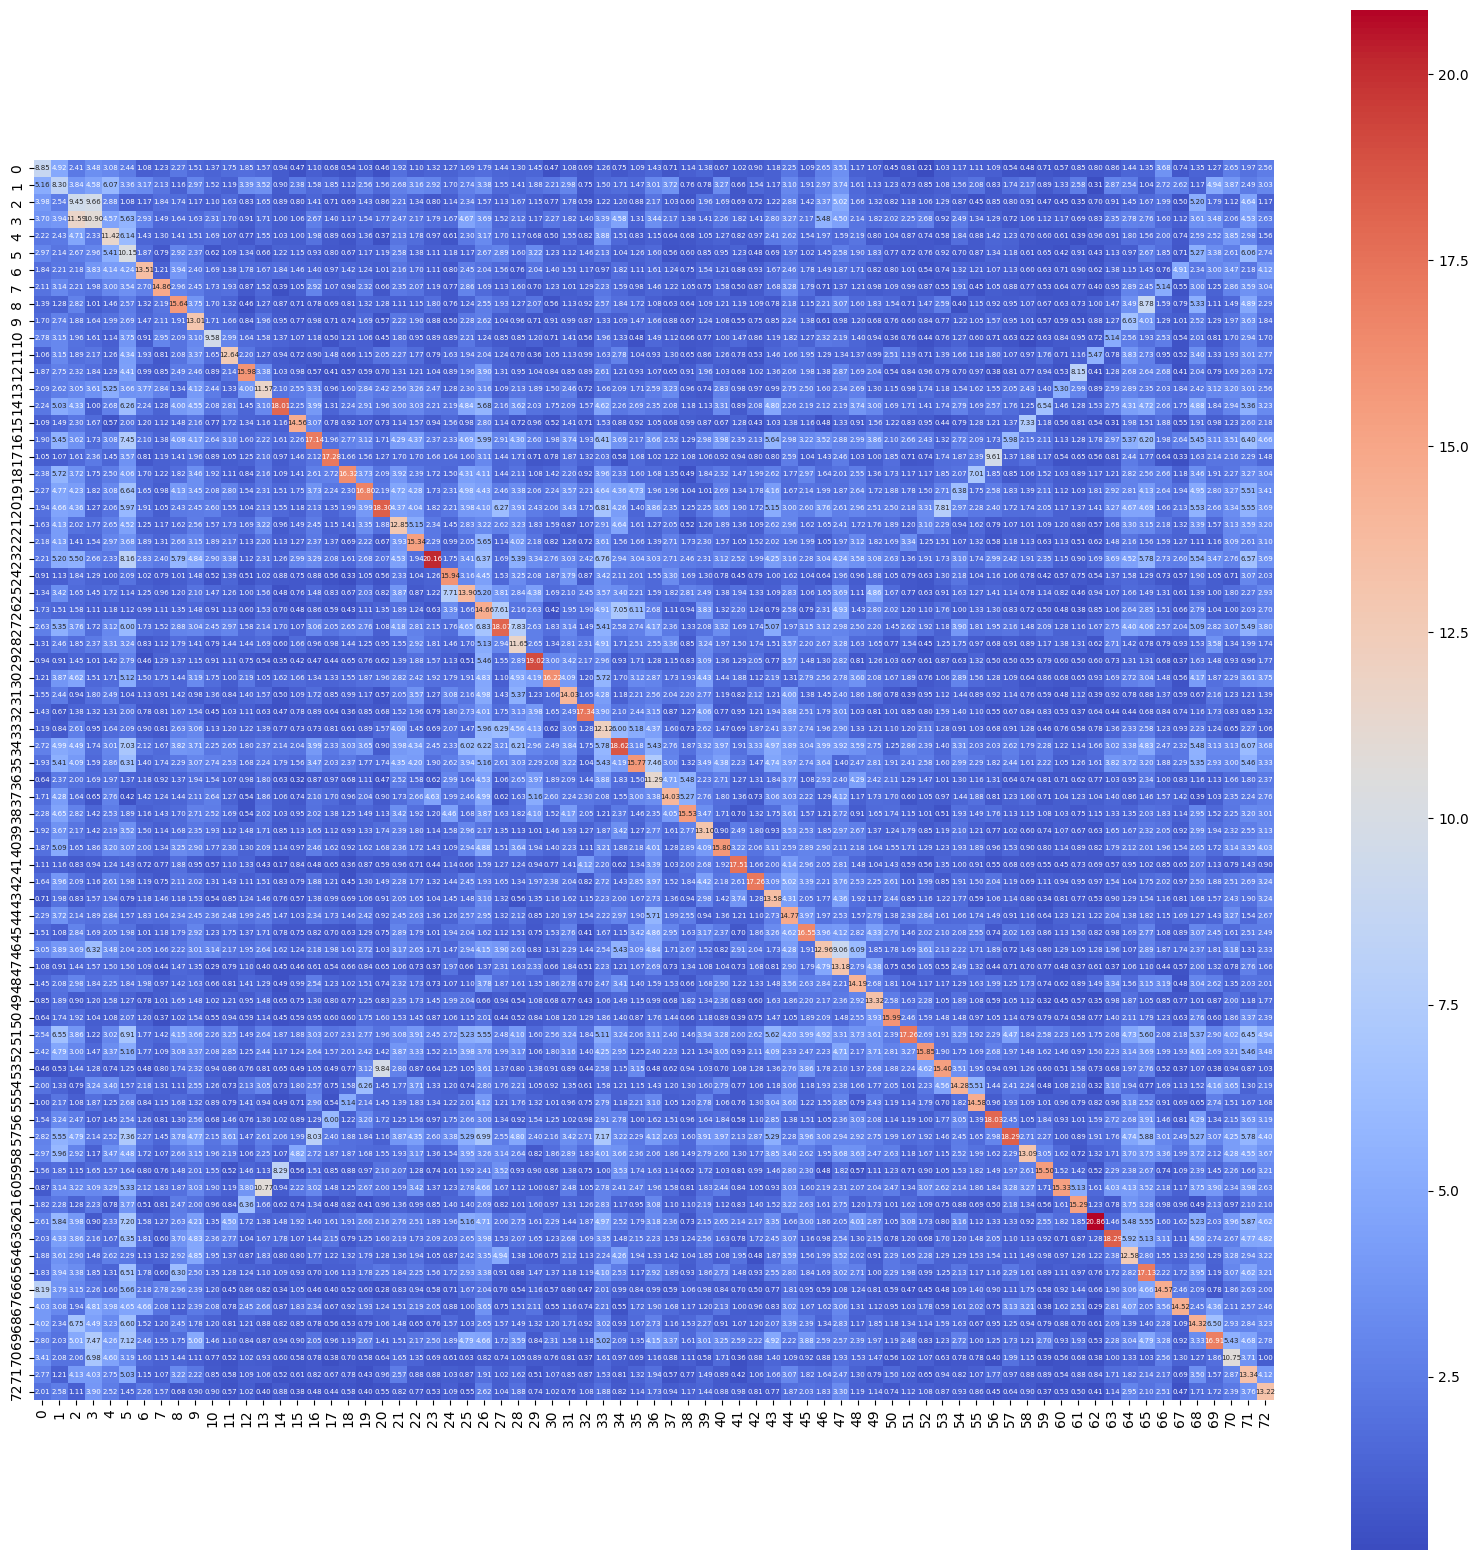

In [28]:
ci_matrix, seq = compute_ci_matrix_random_revcomp(trnaseq, proxy_species=proxy_species, repeat_length = 14, p1 = 10, p2 = 50, return_gene_seq=True)
plot_ci_matrix(ci_matrix, display_values=True, fig_size=20, annot_size=5)

In [90]:
n=14
i=10
j=50


In [91]:
np.arange(j, j+n)[::-1]

array([63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50])

In [92]:
np.arange(i, i+n)

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])

In [93]:
ci_matrix[np.arange(i, i+n), np.arange(j, j+n)[::-1]]

array([7.72917461, 7.6120019 , 9.88346767, 6.94561863, 6.138556  ,
       6.76026726, 6.42134809, 7.03550625, 6.98458719, 6.59607601,
       4.97798824, 7.95747471, 5.40269518, 3.3261013 ])

In [94]:
ci_matrix[np.arange(i, i+n)[::-1], np.arange(j, j+n)]

array([3.3261013 , 5.40269518, 7.95747471, 4.97798824, 6.59607601,
       6.98458719, 7.03550625, 6.42134809, 6.76026726, 6.138556  ,
       6.94561863, 9.88346767, 7.6120019 , 7.72917461])

In [31]:
from tqdm import tqdm
# check if there is any subsequence of length n with a reverse complement somewhere else in the sequence

n_windows_to_sample = 10
n_antidiags_to_check = np.arange(2,21)
avg_occurences_list = []
natural_seqs = tRNA_scan_df['tRNA_scan_sequence'].drop_duplicates().values

for n in tqdm(n_antidiags_to_check):
    print('n ', n)
    n_rev_comps_list = []
    
    for l in range(len(natural_seqs)):
       
        for k in range(n_windows_to_sample):
            trnaseq = list(natural_seqs[l])
            random.shuffle(trnaseq)
            random_seq = ''.join(trnaseq)
            n_rev_comps = 0
            for i in range(len(random_seq)-n+1):
                subseq = random_seq[i:i+n]
                for j in range(len(random_seq)-n+1):
                    if (j>=(i-n)) and (j<(i+n)): # sequences overlap
                        continue
                    subseq2 = random_seq[j:j+n]
                    assert len(subseq) == len(subseq2)
                    if is_rev_comp(subseq, subseq2, allow_wobble=False):
                        n_rev_comps += 1

            n_rev_comps_list.append(n_rev_comps/2) # divide by 2 because we count each pair twice

    avg_occurrences = sum(n_rev_comps_list)/len(n_rev_comps_list)
    avg_occurences_list.append(avg_occurrences)
    

n_anti_occ_df = pd.DataFrame({'n':n_antidiags_to_check, 'avg_occurrences':avg_occurences_list})

  0%|          | 0/19 [00:00<?, ?it/s]

n  2


  5%|▌         | 1/19 [00:04<01:20,  4.49s/it]

n  3


 11%|█         | 2/19 [00:08<01:16,  4.49s/it]

n  4


 16%|█▌        | 3/19 [00:13<01:10,  4.40s/it]

n  5


 21%|██        | 4/19 [00:17<01:04,  4.29s/it]

n  6


 26%|██▋       | 5/19 [00:21<00:58,  4.15s/it]

n  7


 32%|███▏      | 6/19 [00:25<00:52,  4.03s/it]

n  8


 37%|███▋      | 7/19 [00:28<00:46,  3.91s/it]

n  9


 42%|████▏     | 8/19 [00:32<00:41,  3.77s/it]

n  10


 47%|████▋     | 9/19 [00:35<00:36,  3.63s/it]

n  11


 53%|█████▎    | 10/19 [00:38<00:31,  3.49s/it]

n  12


 58%|█████▊    | 11/19 [00:41<00:26,  3.34s/it]

n  13


 63%|██████▎   | 12/19 [00:44<00:22,  3.21s/it]

n  14


 68%|██████▊   | 13/19 [00:47<00:18,  3.08s/it]

n  15


 74%|███████▎  | 14/19 [00:50<00:15,  3.01s/it]

n  16


 79%|███████▉  | 15/19 [00:52<00:11,  2.86s/it]

n  17


 84%|████████▍ | 16/19 [00:55<00:08,  2.71s/it]

n  18


 89%|████████▉ | 17/19 [00:57<00:05,  2.58s/it]

n  19


 95%|█████████▍| 18/19 [00:59<00:02,  2.44s/it]

n  20


100%|██████████| 19/19 [01:01<00:00,  3.24s/it]


In [36]:
from concurrent.futures import ProcessPoolExecutor

# Assuming tRNA_scan_df and is_rev_comp are already defined
# Replace this with the actual implementation of is_rev_comp function

def check_rev_comps(n, natural_seqs, n_windows_to_sample):
    n_rev_comps_list = []
    
    for l in tqdm(range(len(natural_seqs))):
        for k in range(n_windows_to_sample):
            trnaseq = list(natural_seqs[l])
            random.shuffle(trnaseq)
            random_seq = ''.join(trnaseq)
            n_rev_comps = 0
            for i in range(len(random_seq) - n + 1):
                subseq = random_seq[i:i+n]
                for j in range(len(random_seq) - n + 1):
                    if (j >= (i - n)) and (j < (i + n)):  # sequences overlap
                        continue
                    subseq2 = random_seq[j:j+n]
                    assert len(subseq) == len(subseq2)
                    if is_rev_comp(subseq, subseq2, allow_wobble=False):
                        n_rev_comps += 1
            n_rev_comps_list.append(n_rev_comps / 2)  # divide by 2 because we count each pair twice

    avg_occurrences = sum(n_rev_comps_list) / len(n_rev_comps_list)
    return avg_occurrences

n_windows_to_sample = 10000
n_antidiags_to_check = np.arange(2, 21)
avg_occurences_list = []
natural_seqs = tRNA_scan_df['tRNA_scan_sequence'].drop_duplicates().values

with ProcessPoolExecutor() as executor:
    results = list(tqdm(executor.map(check_rev_comps, n_antidiags_to_check, [natural_seqs] * len(n_antidiags_to_check), [n_windows_to_sample] * len(n_antidiags_to_check)), total=len(n_antidiags_to_check)))

n_anti_occ_df = pd.DataFrame({'n': n_antidiags_to_check, 'avg_occurrences': results})

print(n_anti_occ_df)

100%|██████████| 19/19 [1:57:01<00:00, 369.55s/it]   


     n  avg_occurrences
0    2       227.478119
1    3        54.729077
2    4        13.132793
3    5         3.151890
4    6         0.755064
5    7         0.180821
6    8         0.043004
7    9         0.010379
8   10         0.002419
9   11         0.000561
10  12         0.000161
11  13         0.000037
12  14         0.000009
13  15         0.000001
14  16         0.000000
15  17         0.000000
16  18         0.000000
17  19         0.000000
18  20         0.000000


In [39]:
n_anti_occ_df

n  avg_occurrences
0    2       227.478119
1    3        54.729077
2    4        13.132793
3    5         3.151890
4    6         0.755064
5    7         0.180821
6    8         0.043004
7    9         0.010379
8   10         0.002419
9   11         0.000561
10  12         0.000161
11  13         0.000037
12  14         0.000009
13  15         0.000001
14  16         0.000000
15  17         0.000000
16  18         0.000000
17  19         0.000000
18  20         0.000000

In [37]:
n_anti_occ_df.to_csv(os.path.join(data_path, 'avg_occurrences_rev_complement_no_wobble_trna_shuffled_10k.tsv'), sep='\t', index=False)

In [40]:
cowplot_theme = lambda figure_size : theme(
    # Set the background to white and remove panel border
    panel_background=element_blank(),
    panel_border=element_blank(),

    # Light grey grid lines
    panel_grid_major=element_line(color='lightgrey', size=0.5),
    panel_grid_minor=element_blank(),

    # Minimize axis ticks
    axis_ticks=element_blank(),
    #axis_text_x=element_text(rotation=45, hjust=1),

    # Simple font
    text=element_text(color='black', size=13),
    figure_size = figure_size
)

/opt/modules/i12g/anaconda/envs/flash2/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


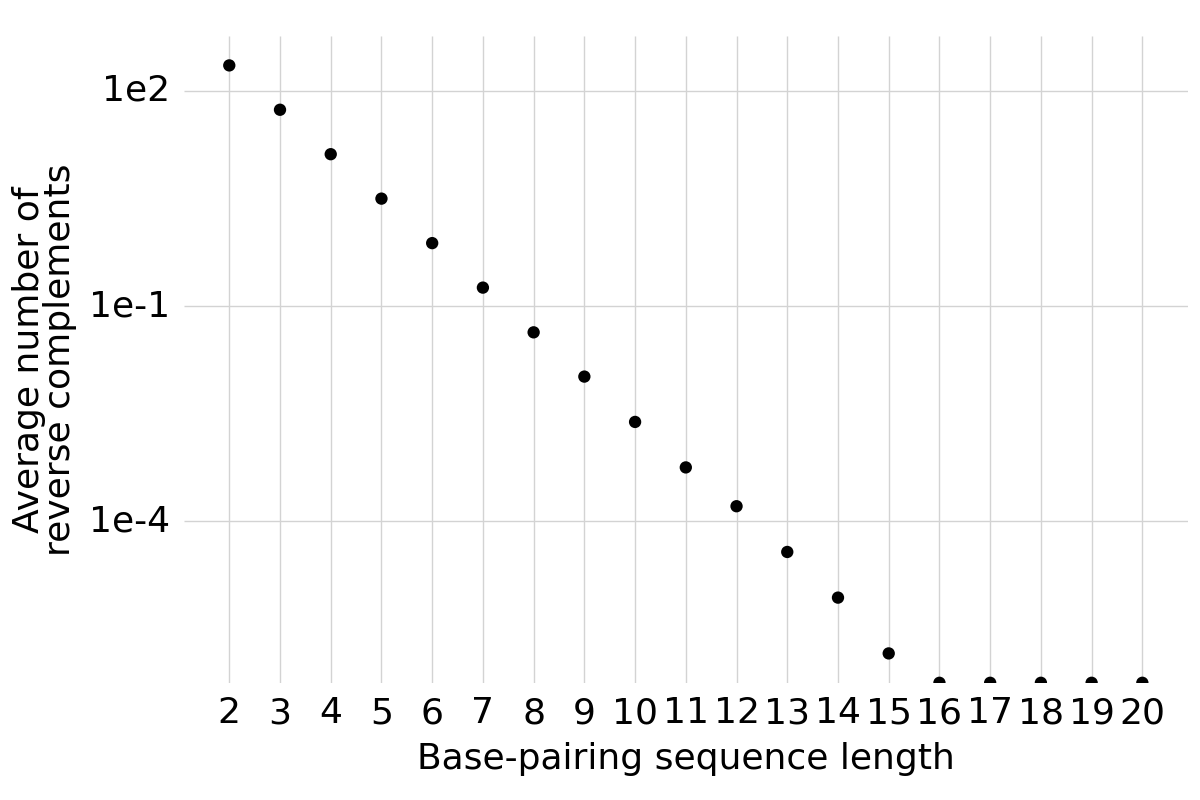

<Figure Size: (600 x 400)>

In [41]:
#plot n_anti_occ_df
from plotnine import *

# have a x axis with all integers labeled
(ggplot(n_anti_occ_df, aes(x='n', y='avg_occurrences')) + geom_point() +  scale_x_continuous(breaks=np.arange(2,21)) 
    + labs(x='Base-pairing sequence length', y='  Average number of\nreverse complements')
    + scale_y_log10() + cowplot_theme([6, 4]))

In [108]:
from tqdm import tqdm
# check if there is any subsequence of length n with a reverse complement somewhere else in the sequence
n_shuffles = 1
len_repeats_to_check = np.arange(2,21)
avg_occurences_list = []
avg_interaction_values_list = []
natural_seqs = tRNA_scan_df['tRNA_scan_sequence'].drop_duplicates().values
avg_interaction_values_df = pd.DataFrame(index=np.arange(len(natural_seqs)*n_shuffles))

for n in len_repeats_to_check:

    print('n ', n)
    n_rev_comps_list = []
    avg_interaction_values_n_list = []

    for l in tqdm(range(len(natural_seqs))):
        
        #for k in range(n_shuffles):

        trnaseq = list(natural_seqs[l])
        random.shuffle(trnaseq)
        random_seq = ''.join(trnaseq)
        p1, p2, seq_w_revcomp = insert_random_revcomp(random_seq, random_seq_length=n, allow_wobble=False)
        ci_matrix = compute_ci_matrix(seq_w_revcomp, proxy_species=proxy_species)

        avg_ci_value = np.concatenate((ci_matrix[np.arange(p1, p1+n), np.arange(p2, p2+n)[::-1]], 
            ci_matrix[np.arange(p2, p2+n), np.arange(p1, p1+n)[::-1]])).mean() # take the average of the two diagonals

        avg_interaction_values_n_list.append(avg_ci_value)

    avg_interaction_values_df[f'{n}'] = avg_interaction_values_n_list

n  2


  0%|          | 0/70 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  1%|▏         | 1/70 [00:01<02:15,  1.96s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  3%|▎         | 2/70 [00:04<02:19,  2.05s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  4%|▍         | 3/70 [00:06<02:18,  2.06s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  6%|▌         | 4/70 [00:08<02:14,  2.04s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

  7%|▋         | 5/70 [00:10<02:11,  2.02s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

  9%|▊         | 6/70 [00:12<02:06,  1.98s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 10%|█         | 7/70 [00:14<02:04,  1.98s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 11%|█▏        | 8/70 [00:15<02:01,  1.96s/it]

Map (num_proc=20):   0%|          | 0/214 [00:00<?, ? examples/s]

 13%|█▎        | 9/70 [00:17<02:01,  1.99s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 14%|█▍        | 10/70 [00:20<02:00,  2.01s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 16%|█▌        | 11/70 [00:22<01:57,  2.00s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 17%|█▋        | 12/70 [00:24<01:56,  2.00s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 19%|█▊        | 13/70 [00:25<01:52,  1.98s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 20%|██        | 14/70 [00:28<01:52,  2.00s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 21%|██▏       | 15/70 [00:29<01:49,  1.99s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 23%|██▎       | 16/70 [00:32<01:49,  2.02s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 24%|██▍       | 17/70 [00:34<01:47,  2.02s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 26%|██▌       | 18/70 [00:36<01:45,  2.04s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 27%|██▋       | 19/70 [00:38<01:44,  2.04s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 29%|██▊       | 20/70 [00:40<01:41,  2.02s/it]

Map (num_proc=20):   0%|          | 0/214 [00:00<?, ? examples/s]

 30%|███       | 21/70 [00:42<01:39,  2.02s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 31%|███▏      | 22/70 [00:44<01:36,  2.02s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 33%|███▎      | 23/70 [00:46<01:34,  2.01s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 34%|███▍      | 24/70 [00:48<01:32,  2.01s/it]

Map (num_proc=20):   0%|          | 0/400 [00:00<?, ? examples/s]

 36%|███▌      | 25/70 [00:50<01:35,  2.12s/it]

Map (num_proc=20):   0%|          | 0/400 [00:00<?, ? examples/s]

 37%|███▋      | 26/70 [00:52<01:35,  2.18s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 39%|███▊      | 27/70 [00:54<01:31,  2.13s/it]

Map (num_proc=20):   0%|          | 0/346 [00:00<?, ? examples/s]

 40%|████      | 28/70 [00:57<01:30,  2.15s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 41%|████▏     | 29/70 [00:59<01:28,  2.16s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 43%|████▎     | 30/70 [01:01<01:26,  2.16s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 44%|████▍     | 31/70 [01:03<01:24,  2.16s/it]

Map (num_proc=20):   0%|          | 0/346 [00:00<?, ? examples/s]

 46%|████▌     | 32/70 [01:05<01:22,  2.18s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 47%|████▋     | 33/70 [01:07<01:18,  2.11s/it]

Map (num_proc=20):   0%|          | 0/253 [00:00<?, ? examples/s]

 49%|████▊     | 34/70 [01:10<01:16,  2.13s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 50%|█████     | 35/70 [01:12<01:14,  2.13s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 51%|█████▏    | 36/70 [01:14<01:11,  2.12s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 53%|█████▎    | 37/70 [01:16<01:09,  2.09s/it]

Map (num_proc=20):   0%|          | 0/289 [00:00<?, ? examples/s]

 54%|█████▍    | 38/70 [01:18<01:07,  2.10s/it]

Map (num_proc=20):   0%|          | 0/289 [00:00<?, ? examples/s]

 56%|█████▌    | 39/70 [01:20<01:06,  2.13s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 57%|█████▋    | 40/70 [01:22<01:03,  2.10s/it]

Map (num_proc=20):   0%|          | 0/277 [00:00<?, ? examples/s]

 59%|█████▊    | 41/70 [01:24<01:01,  2.11s/it]

Map (num_proc=20):   0%|          | 0/277 [00:00<?, ? examples/s]

 60%|██████    | 42/70 [01:26<00:58,  2.10s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 61%|██████▏   | 43/70 [01:28<00:56,  2.09s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 63%|██████▎   | 44/70 [01:31<00:54,  2.10s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 64%|██████▍   | 45/70 [01:33<00:52,  2.09s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 66%|██████▌   | 46/70 [01:35<00:50,  2.09s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 67%|██████▋   | 47/70 [01:37<00:47,  2.07s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 69%|██████▊   | 48/70 [01:39<00:46,  2.10s/it]

Map (num_proc=20):   0%|          | 0/307 [00:00<?, ? examples/s]

 70%|███████   | 49/70 [01:41<00:44,  2.12s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 71%|███████▏  | 50/70 [01:43<00:42,  2.11s/it]

Map (num_proc=20):   0%|          | 0/307 [00:00<?, ? examples/s]

 73%|███████▎  | 51/70 [01:45<00:40,  2.13s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 74%|███████▍  | 52/70 [01:47<00:38,  2.12s/it]

Map (num_proc=20):   0%|          | 0/316 [00:00<?, ? examples/s]

 76%|███████▌  | 53/70 [01:50<00:36,  2.14s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 77%|███████▋  | 54/70 [01:52<00:33,  2.09s/it]

Map (num_proc=20):   0%|          | 0/250 [00:00<?, ? examples/s]

 79%|███████▊  | 55/70 [01:54<00:31,  2.09s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 80%|████████  | 56/70 [01:56<00:29,  2.08s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 81%|████████▏ | 57/70 [01:58<00:26,  2.07s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 83%|████████▎ | 58/70 [02:00<00:25,  2.09s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 84%|████████▍ | 59/70 [02:02<00:22,  2.06s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 86%|████████▌ | 60/70 [02:04<00:20,  2.03s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 87%|████████▋ | 61/70 [02:06<00:18,  2.02s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 89%|████████▊ | 62/70 [02:08<00:16,  2.01s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 90%|█████████ | 63/70 [02:10<00:14,  2.01s/it]

Map (num_proc=20):   0%|          | 0/319 [00:00<?, ? examples/s]

 91%|█████████▏| 64/70 [02:12<00:12,  2.04s/it]

Map (num_proc=20):   0%|          | 0/268 [00:00<?, ? examples/s]

 93%|█████████▎| 65/70 [02:14<00:10,  2.06s/it]

Map (num_proc=20):   0%|          | 0/268 [00:00<?, ? examples/s]

 94%|█████████▍| 66/70 [02:16<00:08,  2.08s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 96%|█████████▌| 67/70 [02:18<00:06,  2.06s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 97%|█████████▋| 68/70 [02:20<00:04,  2.03s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 99%|█████████▊| 69/70 [02:22<00:02,  2.04s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

100%|██████████| 70/70 [02:24<00:00,  2.07s/it]


n  3


  0%|          | 0/70 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  1%|▏         | 1/70 [00:02<02:21,  2.05s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  3%|▎         | 2/70 [00:04<02:19,  2.06s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  4%|▍         | 3/70 [00:06<02:13,  2.00s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  6%|▌         | 4/70 [00:08<02:11,  1.99s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

  7%|▋         | 5/70 [00:10<02:09,  1.99s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

  9%|▊         | 6/70 [00:12<02:08,  2.01s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 10%|█         | 7/70 [00:14<02:07,  2.03s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 11%|█▏        | 8/70 [00:16<02:04,  2.02s/it]

Map (num_proc=20):   0%|          | 0/214 [00:00<?, ? examples/s]

 13%|█▎        | 9/70 [00:18<02:03,  2.02s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 14%|█▍        | 10/70 [00:20<02:00,  2.00s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 16%|█▌        | 11/70 [00:22<01:59,  2.02s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 17%|█▋        | 12/70 [00:24<01:55,  2.00s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 19%|█▊        | 13/70 [00:26<01:54,  2.02s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 20%|██        | 14/70 [00:28<01:54,  2.04s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 21%|██▏       | 15/70 [00:30<01:51,  2.03s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 23%|██▎       | 16/70 [00:32<01:49,  2.03s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 24%|██▍       | 17/70 [00:34<01:48,  2.05s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 26%|██▌       | 18/70 [00:36<01:46,  2.05s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 27%|██▋       | 19/70 [00:38<01:44,  2.05s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 29%|██▊       | 20/70 [00:40<01:42,  2.05s/it]

Map (num_proc=20):   0%|          | 0/214 [00:00<?, ? examples/s]

 30%|███       | 21/70 [00:42<01:39,  2.02s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 31%|███▏      | 22/70 [00:44<01:36,  2.02s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 33%|███▎      | 23/70 [00:46<01:34,  2.00s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 34%|███▍      | 24/70 [00:48<01:32,  2.01s/it]

Map (num_proc=20):   0%|          | 0/400 [00:00<?, ? examples/s]

 36%|███▌      | 25/70 [00:50<01:34,  2.11s/it]

Map (num_proc=20):   0%|          | 0/400 [00:00<?, ? examples/s]

 37%|███▋      | 26/70 [00:53<01:35,  2.16s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 39%|███▊      | 27/70 [00:55<01:31,  2.14s/it]

Map (num_proc=20):   0%|          | 0/346 [00:00<?, ? examples/s]

 40%|████      | 28/70 [00:57<01:30,  2.16s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 41%|████▏     | 29/70 [00:59<01:30,  2.20s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 43%|████▎     | 30/70 [01:01<01:27,  2.19s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 44%|████▍     | 31/70 [01:04<01:26,  2.21s/it]

Map (num_proc=20):   0%|          | 0/346 [00:00<?, ? examples/s]

 46%|████▌     | 32/70 [01:06<01:26,  2.28s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 47%|████▋     | 33/70 [01:08<01:21,  2.22s/it]

Map (num_proc=20):   0%|          | 0/253 [00:00<?, ? examples/s]

 49%|████▊     | 34/70 [01:10<01:18,  2.19s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 50%|█████     | 35/70 [01:12<01:15,  2.16s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 51%|█████▏    | 36/70 [01:14<01:12,  2.14s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 53%|█████▎    | 37/70 [01:16<01:09,  2.10s/it]

Map (num_proc=20):   0%|          | 0/289 [00:00<?, ? examples/s]

 54%|█████▍    | 38/70 [01:19<01:07,  2.10s/it]

Map (num_proc=20):   0%|          | 0/289 [00:00<?, ? examples/s]

 56%|█████▌    | 39/70 [01:21<01:05,  2.11s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 57%|█████▋    | 40/70 [01:23<01:02,  2.09s/it]

Map (num_proc=20):   0%|          | 0/277 [00:00<?, ? examples/s]

 59%|█████▊    | 41/70 [01:25<01:00,  2.10s/it]

Map (num_proc=20):   0%|          | 0/277 [00:00<?, ? examples/s]

 60%|██████    | 42/70 [01:27<00:58,  2.08s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 61%|██████▏   | 43/70 [01:29<00:56,  2.11s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 63%|██████▎   | 44/70 [01:31<00:54,  2.11s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 64%|██████▍   | 45/70 [01:33<00:52,  2.09s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 66%|██████▌   | 46/70 [01:35<00:49,  2.08s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 67%|██████▋   | 47/70 [01:37<00:48,  2.09s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 69%|██████▊   | 48/70 [01:40<00:46,  2.13s/it]

Map (num_proc=20):   0%|          | 0/307 [00:00<?, ? examples/s]

 70%|███████   | 49/70 [01:42<00:44,  2.11s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 71%|███████▏  | 50/70 [01:44<00:42,  2.11s/it]

Map (num_proc=20):   0%|          | 0/307 [00:00<?, ? examples/s]

 73%|███████▎  | 51/70 [01:46<00:40,  2.13s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 74%|███████▍  | 52/70 [01:48<00:38,  2.14s/it]

Map (num_proc=20):   0%|          | 0/316 [00:00<?, ? examples/s]

 76%|███████▌  | 53/70 [01:50<00:36,  2.14s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 77%|███████▋  | 54/70 [01:52<00:33,  2.12s/it]

Map (num_proc=20):   0%|          | 0/250 [00:00<?, ? examples/s]

 79%|███████▊  | 55/70 [01:54<00:31,  2.11s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 80%|████████  | 56/70 [01:57<00:29,  2.11s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 81%|████████▏ | 57/70 [01:59<00:27,  2.12s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 83%|████████▎ | 58/70 [02:01<00:25,  2.15s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 84%|████████▍ | 59/70 [02:03<00:23,  2.11s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 86%|████████▌ | 60/70 [02:05<00:20,  2.08s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 87%|████████▋ | 61/70 [02:07<00:18,  2.06s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 89%|████████▊ | 62/70 [02:09<00:16,  2.04s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 90%|█████████ | 63/70 [02:11<00:14,  2.05s/it]

Map (num_proc=20):   0%|          | 0/319 [00:00<?, ? examples/s]

 91%|█████████▏| 64/70 [02:13<00:12,  2.05s/it]

Map (num_proc=20):   0%|          | 0/268 [00:00<?, ? examples/s]

 93%|█████████▎| 65/70 [02:15<00:10,  2.05s/it]

Map (num_proc=20):   0%|          | 0/268 [00:00<?, ? examples/s]

 94%|█████████▍| 66/70 [02:17<00:08,  2.05s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 96%|█████████▌| 67/70 [02:19<00:06,  2.04s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 97%|█████████▋| 68/70 [02:21<00:04,  2.05s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 99%|█████████▊| 69/70 [02:23<00:02,  2.04s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

100%|██████████| 70/70 [02:25<00:00,  2.08s/it]


n  4


  0%|          | 0/70 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  1%|▏         | 1/70 [00:02<02:20,  2.03s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  3%|▎         | 2/70 [00:03<02:14,  1.98s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  4%|▍         | 3/70 [00:06<02:14,  2.01s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  6%|▌         | 4/70 [00:08<02:16,  2.07s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

  7%|▋         | 5/70 [00:10<02:13,  2.05s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

  9%|▊         | 6/70 [00:12<02:10,  2.04s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 10%|█         | 7/70 [00:14<02:10,  2.06s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 11%|█▏        | 8/70 [00:18<02:39,  2.58s/it]

Map (num_proc=20):   0%|          | 0/214 [00:00<?, ? examples/s]

 13%|█▎        | 9/70 [00:19<02:24,  2.37s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 14%|█▍        | 10/70 [00:21<02:13,  2.23s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 16%|█▌        | 11/70 [00:23<02:06,  2.15s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 17%|█▋        | 12/70 [00:25<02:02,  2.11s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 19%|█▊        | 13/70 [00:27<01:57,  2.07s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 20%|██        | 14/70 [00:29<01:55,  2.06s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 21%|██▏       | 15/70 [00:31<01:52,  2.04s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 23%|██▎       | 16/70 [00:33<01:49,  2.03s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 24%|██▍       | 17/70 [00:35<01:47,  2.02s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 26%|██▌       | 18/70 [00:37<01:44,  2.01s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 27%|██▋       | 19/70 [00:39<01:41,  2.00s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 29%|██▊       | 20/70 [00:41<01:40,  2.01s/it]

Map (num_proc=20):   0%|          | 0/214 [00:00<?, ? examples/s]

 30%|███       | 21/70 [00:43<01:38,  2.00s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 31%|███▏      | 22/70 [00:45<01:35,  2.00s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 33%|███▎      | 23/70 [00:47<01:34,  2.00s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 34%|███▍      | 24/70 [00:49<01:31,  2.00s/it]

Map (num_proc=20):   0%|          | 0/400 [00:00<?, ? examples/s]

 36%|███▌      | 25/70 [00:52<01:33,  2.09s/it]

Map (num_proc=20):   0%|          | 0/400 [00:00<?, ? examples/s]

 37%|███▋      | 26/70 [00:54<01:35,  2.17s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 39%|███▊      | 27/70 [00:56<01:30,  2.10s/it]

Map (num_proc=20):   0%|          | 0/346 [00:00<?, ? examples/s]

 40%|████      | 28/70 [00:58<01:29,  2.12s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 41%|████▏     | 29/70 [01:00<01:27,  2.13s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 43%|████▎     | 30/70 [01:02<01:25,  2.13s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 44%|████▍     | 31/70 [01:05<01:23,  2.13s/it]

Map (num_proc=20):   0%|          | 0/346 [00:00<?, ? examples/s]

 46%|████▌     | 32/70 [01:07<01:23,  2.21s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 47%|████▋     | 33/70 [01:09<01:19,  2.15s/it]

Map (num_proc=20):   0%|          | 0/253 [00:00<?, ? examples/s]

 49%|████▊     | 34/70 [01:11<01:15,  2.11s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 50%|█████     | 35/70 [01:13<01:13,  2.09s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 51%|█████▏    | 36/70 [01:15<01:11,  2.10s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 53%|█████▎    | 37/70 [01:17<01:08,  2.08s/it]

Map (num_proc=20):   0%|          | 0/289 [00:00<?, ? examples/s]

 54%|█████▍    | 38/70 [01:19<01:06,  2.07s/it]

Map (num_proc=20):   0%|          | 0/289 [00:00<?, ? examples/s]

 56%|█████▌    | 39/70 [01:21<01:04,  2.07s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 57%|█████▋    | 40/70 [01:23<01:01,  2.06s/it]

Map (num_proc=20):   0%|          | 0/277 [00:00<?, ? examples/s]

 59%|█████▊    | 41/70 [01:25<00:59,  2.05s/it]

Map (num_proc=20):   0%|          | 0/277 [00:00<?, ? examples/s]

 60%|██████    | 42/70 [01:27<00:57,  2.06s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 61%|██████▏   | 43/70 [01:29<00:55,  2.06s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 63%|██████▎   | 44/70 [01:32<00:54,  2.09s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 64%|██████▍   | 45/70 [01:34<00:51,  2.06s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 66%|██████▌   | 46/70 [01:36<00:48,  2.04s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 67%|██████▋   | 47/70 [01:38<00:48,  2.11s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 69%|██████▊   | 48/70 [01:40<00:46,  2.11s/it]

Map (num_proc=20):   0%|          | 0/307 [00:00<?, ? examples/s]

 70%|███████   | 49/70 [01:42<00:44,  2.12s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 71%|███████▏  | 50/70 [01:44<00:42,  2.13s/it]

Map (num_proc=20):   0%|          | 0/307 [00:00<?, ? examples/s]

 73%|███████▎  | 51/70 [01:46<00:40,  2.13s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 74%|███████▍  | 52/70 [01:48<00:38,  2.12s/it]

Map (num_proc=20):   0%|          | 0/316 [00:00<?, ? examples/s]

 76%|███████▌  | 53/70 [01:51<00:36,  2.14s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 77%|███████▋  | 54/70 [01:53<00:33,  2.11s/it]

Map (num_proc=20):   0%|          | 0/250 [00:00<?, ? examples/s]

 79%|███████▊  | 55/70 [01:55<00:32,  2.15s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 80%|████████  | 56/70 [01:57<00:29,  2.13s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 81%|████████▏ | 57/70 [01:59<00:27,  2.13s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 83%|████████▎ | 58/70 [02:01<00:25,  2.14s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 84%|████████▍ | 59/70 [02:03<00:23,  2.11s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 86%|████████▌ | 60/70 [02:06<00:21,  2.11s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 87%|████████▋ | 61/70 [02:08<00:18,  2.10s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 89%|████████▊ | 62/70 [02:10<00:16,  2.09s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 90%|█████████ | 63/70 [02:12<00:14,  2.10s/it]

Map (num_proc=20):   0%|          | 0/319 [00:00<?, ? examples/s]

 91%|█████████▏| 64/70 [02:14<00:12,  2.11s/it]

Map (num_proc=20):   0%|          | 0/268 [00:00<?, ? examples/s]

 93%|█████████▎| 65/70 [02:16<00:10,  2.09s/it]

Map (num_proc=20):   0%|          | 0/268 [00:00<?, ? examples/s]

 94%|█████████▍| 66/70 [02:18<00:08,  2.11s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 96%|█████████▌| 67/70 [02:20<00:06,  2.08s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 97%|█████████▋| 68/70 [02:22<00:04,  2.05s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 99%|█████████▊| 69/70 [02:24<00:02,  2.05s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

100%|██████████| 70/70 [02:26<00:00,  2.09s/it]


n  5


  0%|          | 0/70 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  1%|▏         | 1/70 [00:02<02:20,  2.04s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  3%|▎         | 2/70 [00:04<02:16,  2.00s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  4%|▍         | 3/70 [00:05<02:13,  1.99s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  6%|▌         | 4/70 [00:08<02:12,  2.01s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

  7%|▋         | 5/70 [00:10<02:10,  2.01s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

  9%|▊         | 6/70 [00:12<02:08,  2.00s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 10%|█         | 7/70 [00:14<02:05,  2.00s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 11%|█▏        | 8/70 [00:16<02:03,  1.99s/it]

Map (num_proc=20):   0%|          | 0/214 [00:00<?, ? examples/s]

 13%|█▎        | 9/70 [00:17<02:01,  1.99s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 14%|█▍        | 10/70 [00:19<01:59,  1.99s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 16%|█▌        | 11/70 [00:21<01:57,  2.00s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 17%|█▋        | 12/70 [00:23<01:55,  2.00s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 19%|█▊        | 13/70 [00:26<01:55,  2.02s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 20%|██        | 14/70 [00:28<01:53,  2.03s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 21%|██▏       | 15/70 [00:30<01:50,  2.01s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 23%|██▎       | 16/70 [00:32<01:47,  1.99s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 24%|██▍       | 17/70 [00:34<01:46,  2.01s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 26%|██▌       | 18/70 [00:36<01:45,  2.02s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 27%|██▋       | 19/70 [00:38<01:43,  2.03s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 29%|██▊       | 20/70 [00:40<01:41,  2.03s/it]

Map (num_proc=20):   0%|          | 0/214 [00:00<?, ? examples/s]

 30%|███       | 21/70 [00:42<01:41,  2.06s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 31%|███▏      | 22/70 [00:44<01:39,  2.06s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 33%|███▎      | 23/70 [00:46<01:36,  2.05s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 34%|███▍      | 24/70 [00:48<01:34,  2.05s/it]

Map (num_proc=20):   0%|          | 0/400 [00:00<?, ? examples/s]

 36%|███▌      | 25/70 [00:50<01:36,  2.15s/it]

Map (num_proc=20):   0%|          | 0/400 [00:00<?, ? examples/s]

 37%|███▋      | 26/70 [00:53<01:37,  2.20s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 39%|███▊      | 27/70 [00:56<01:48,  2.52s/it]

Map (num_proc=20):   0%|          | 0/346 [00:00<?, ? examples/s]

 40%|████      | 28/70 [00:58<01:42,  2.43s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 41%|████▏     | 29/70 [01:00<01:36,  2.36s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 43%|████▎     | 30/70 [01:03<01:32,  2.31s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 44%|████▍     | 31/70 [01:05<01:29,  2.29s/it]

Map (num_proc=20):   0%|          | 0/346 [00:00<?, ? examples/s]

 46%|████▌     | 32/70 [01:07<01:26,  2.27s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 47%|████▋     | 33/70 [01:09<01:21,  2.20s/it]

Map (num_proc=20):   0%|          | 0/253 [00:00<?, ? examples/s]

 49%|████▊     | 34/70 [01:11<01:17,  2.16s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 50%|█████     | 35/70 [01:13<01:14,  2.14s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 51%|█████▏    | 36/70 [01:15<01:13,  2.15s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 53%|█████▎    | 37/70 [01:17<01:09,  2.11s/it]

Map (num_proc=20):   0%|          | 0/289 [00:00<?, ? examples/s]

 54%|█████▍    | 38/70 [01:19<01:07,  2.10s/it]

Map (num_proc=20):   0%|          | 0/289 [00:00<?, ? examples/s]

 56%|█████▌    | 39/70 [01:22<01:04,  2.09s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 57%|█████▋    | 40/70 [01:24<01:01,  2.06s/it]

Map (num_proc=20):   0%|          | 0/277 [00:00<?, ? examples/s]

 59%|█████▊    | 41/70 [01:26<01:00,  2.08s/it]

Map (num_proc=20):   0%|          | 0/277 [00:00<?, ? examples/s]

 60%|██████    | 42/70 [01:28<00:58,  2.08s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 61%|██████▏   | 43/70 [01:30<00:56,  2.11s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 63%|██████▎   | 44/70 [01:32<00:54,  2.10s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 64%|██████▍   | 45/70 [01:34<00:52,  2.11s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 66%|██████▌   | 46/70 [01:36<00:50,  2.09s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 67%|██████▋   | 47/70 [01:38<00:48,  2.11s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 69%|██████▊   | 48/70 [01:40<00:46,  2.11s/it]

Map (num_proc=20):   0%|          | 0/307 [00:00<?, ? examples/s]

 70%|███████   | 49/70 [01:43<00:44,  2.11s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 71%|███████▏  | 50/70 [01:45<00:42,  2.13s/it]

Map (num_proc=20):   0%|          | 0/307 [00:00<?, ? examples/s]

 73%|███████▎  | 51/70 [01:47<00:40,  2.15s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 74%|███████▍  | 52/70 [01:49<00:38,  2.15s/it]

Map (num_proc=20):   0%|          | 0/316 [00:00<?, ? examples/s]

 76%|███████▌  | 53/70 [01:51<00:36,  2.14s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 77%|███████▋  | 54/70 [01:53<00:33,  2.11s/it]

Map (num_proc=20):   0%|          | 0/250 [00:00<?, ? examples/s]

 79%|███████▊  | 55/70 [01:55<00:31,  2.09s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 80%|████████  | 56/70 [01:57<00:29,  2.11s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 81%|████████▏ | 57/70 [02:00<00:27,  2.12s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 83%|████████▎ | 58/70 [02:02<00:25,  2.12s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 84%|████████▍ | 59/70 [02:04<00:23,  2.11s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 86%|████████▌ | 60/70 [02:06<00:20,  2.09s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 87%|████████▋ | 61/70 [02:08<00:18,  2.08s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 89%|████████▊ | 62/70 [02:10<00:16,  2.07s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 90%|█████████ | 63/70 [02:12<00:14,  2.07s/it]

Map (num_proc=20):   0%|          | 0/319 [00:00<?, ? examples/s]

 91%|█████████▏| 64/70 [02:14<00:12,  2.11s/it]

Map (num_proc=20):   0%|          | 0/268 [00:00<?, ? examples/s]

 93%|█████████▎| 65/70 [02:16<00:10,  2.14s/it]

Map (num_proc=20):   0%|          | 0/268 [00:00<?, ? examples/s]

 94%|█████████▍| 66/70 [02:18<00:08,  2.12s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 96%|█████████▌| 67/70 [02:21<00:06,  2.11s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 97%|█████████▋| 68/70 [02:23<00:04,  2.08s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 99%|█████████▊| 69/70 [02:25<00:02,  2.06s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

100%|██████████| 70/70 [02:27<00:00,  2.10s/it]


n  6


  0%|          | 0/70 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  1%|▏         | 1/70 [00:02<02:20,  2.04s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  3%|▎         | 2/70 [00:04<02:19,  2.05s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  4%|▍         | 3/70 [00:06<02:14,  2.00s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  6%|▌         | 4/70 [00:08<02:13,  2.03s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

  7%|▋         | 5/70 [00:10<02:11,  2.02s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

  9%|▊         | 6/70 [00:12<02:09,  2.03s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 10%|█         | 7/70 [00:14<02:07,  2.02s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 11%|█▏        | 8/70 [00:16<02:04,  2.01s/it]

Map (num_proc=20):   0%|          | 0/214 [00:00<?, ? examples/s]

 13%|█▎        | 9/70 [00:18<02:02,  2.01s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 14%|█▍        | 10/70 [00:20<02:00,  2.01s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 16%|█▌        | 11/70 [00:22<02:00,  2.04s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 17%|█▋        | 12/70 [00:24<01:59,  2.05s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 19%|█▊        | 13/70 [00:26<01:56,  2.05s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 20%|██        | 14/70 [00:28<01:54,  2.05s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 21%|██▏       | 15/70 [00:30<01:52,  2.04s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 23%|██▎       | 16/70 [00:32<01:50,  2.04s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 24%|██▍       | 17/70 [00:34<01:49,  2.06s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 26%|██▌       | 18/70 [00:36<01:46,  2.05s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 27%|██▋       | 19/70 [00:38<01:44,  2.06s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 29%|██▊       | 20/70 [00:40<01:41,  2.04s/it]

Map (num_proc=20):   0%|          | 0/214 [00:00<?, ? examples/s]

 30%|███       | 21/70 [00:42<01:39,  2.03s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 31%|███▏      | 22/70 [00:44<01:38,  2.05s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 33%|███▎      | 23/70 [00:46<01:36,  2.05s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 34%|███▍      | 24/70 [00:48<01:34,  2.05s/it]

Map (num_proc=20):   0%|          | 0/400 [00:00<?, ? examples/s]

 36%|███▌      | 25/70 [00:51<01:37,  2.16s/it]

Map (num_proc=20):   0%|          | 0/400 [00:00<?, ? examples/s]

 37%|███▋      | 26/70 [00:53<01:37,  2.21s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 39%|███▊      | 27/70 [00:55<01:33,  2.18s/it]

Map (num_proc=20):   0%|          | 0/346 [00:00<?, ? examples/s]

 40%|████      | 28/70 [00:57<01:32,  2.20s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 41%|████▏     | 29/70 [01:00<01:30,  2.21s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 43%|████▎     | 30/70 [01:02<01:28,  2.21s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 44%|████▍     | 31/70 [01:04<01:25,  2.20s/it]

Map (num_proc=20):   0%|          | 0/346 [00:00<?, ? examples/s]

 46%|████▌     | 32/70 [01:06<01:24,  2.23s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 47%|████▋     | 33/70 [01:08<01:20,  2.17s/it]

Map (num_proc=20):   0%|          | 0/253 [00:00<?, ? examples/s]

 49%|████▊     | 34/70 [01:11<01:16,  2.13s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 50%|█████     | 35/70 [01:13<01:14,  2.13s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 51%|█████▏    | 36/70 [01:15<01:12,  2.14s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 53%|█████▎    | 37/70 [01:17<01:10,  2.13s/it]

Map (num_proc=20):   0%|          | 0/289 [00:00<?, ? examples/s]

 54%|█████▍    | 38/70 [01:19<01:08,  2.14s/it]

Map (num_proc=20):   0%|          | 0/289 [00:00<?, ? examples/s]

 56%|█████▌    | 39/70 [01:21<01:05,  2.11s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 57%|█████▋    | 40/70 [01:23<01:03,  2.10s/it]

Map (num_proc=20):   0%|          | 0/277 [00:00<?, ? examples/s]

 59%|█████▊    | 41/70 [01:25<01:01,  2.12s/it]

Map (num_proc=20):   0%|          | 0/277 [00:00<?, ? examples/s]

 60%|██████    | 42/70 [01:28<00:59,  2.14s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 61%|██████▏   | 43/70 [01:30<00:57,  2.13s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 63%|██████▎   | 44/70 [01:32<00:55,  2.13s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 64%|██████▍   | 45/70 [01:34<00:53,  2.15s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 66%|██████▌   | 46/70 [01:36<00:50,  2.12s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 67%|██████▋   | 47/70 [01:38<00:49,  2.14s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 69%|██████▊   | 48/70 [01:40<00:46,  2.13s/it]

Map (num_proc=20):   0%|          | 0/307 [00:00<?, ? examples/s]

 70%|███████   | 49/70 [01:42<00:44,  2.13s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 71%|███████▏  | 50/70 [01:45<00:42,  2.15s/it]

Map (num_proc=20):   0%|          | 0/307 [00:00<?, ? examples/s]

 73%|███████▎  | 51/70 [01:47<00:40,  2.14s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 74%|███████▍  | 52/70 [01:49<00:38,  2.16s/it]

Map (num_proc=20):   0%|          | 0/316 [00:00<?, ? examples/s]

 76%|███████▌  | 53/70 [01:51<00:36,  2.15s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 77%|███████▋  | 54/70 [01:53<00:33,  2.12s/it]

Map (num_proc=20):   0%|          | 0/250 [00:00<?, ? examples/s]

 79%|███████▊  | 55/70 [01:55<00:31,  2.11s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 80%|████████  | 56/70 [01:57<00:29,  2.13s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 81%|████████▏ | 57/70 [02:00<00:27,  2.15s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 83%|████████▎ | 58/70 [02:02<00:25,  2.13s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 84%|████████▍ | 59/70 [02:04<00:23,  2.12s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 86%|████████▌ | 60/70 [02:06<00:20,  2.09s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 87%|████████▋ | 61/70 [02:08<00:18,  2.06s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 89%|████████▊ | 62/70 [02:10<00:16,  2.06s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 90%|█████████ | 63/70 [02:12<00:14,  2.04s/it]

Map (num_proc=20):   0%|          | 0/319 [00:00<?, ? examples/s]

 91%|█████████▏| 64/70 [02:14<00:12,  2.05s/it]

Map (num_proc=20):   0%|          | 0/268 [00:00<?, ? examples/s]

 93%|█████████▎| 65/70 [02:16<00:10,  2.07s/it]

Map (num_proc=20):   0%|          | 0/268 [00:00<?, ? examples/s]

 94%|█████████▍| 66/70 [02:18<00:08,  2.07s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 96%|█████████▌| 67/70 [02:20<00:06,  2.09s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 97%|█████████▋| 68/70 [02:22<00:04,  2.07s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 99%|█████████▊| 69/70 [02:24<00:02,  2.07s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

100%|██████████| 70/70 [02:26<00:00,  2.10s/it]


n  7


  0%|          | 0/70 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  1%|▏         | 1/70 [00:01<02:15,  1.96s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  3%|▎         | 2/70 [00:04<02:21,  2.08s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  4%|▍         | 3/70 [00:06<02:17,  2.05s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  6%|▌         | 4/70 [00:08<02:14,  2.04s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

  7%|▋         | 5/70 [00:10<02:12,  2.04s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

  9%|▊         | 6/70 [00:12<02:10,  2.04s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 10%|█         | 7/70 [00:14<02:09,  2.05s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 11%|█▏        | 8/70 [00:16<02:05,  2.03s/it]

Map (num_proc=20):   0%|          | 0/214 [00:00<?, ? examples/s]

 13%|█▎        | 9/70 [00:18<02:03,  2.03s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 14%|█▍        | 10/70 [00:20<02:01,  2.03s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 16%|█▌        | 11/70 [00:22<01:59,  2.02s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 17%|█▋        | 12/70 [00:24<01:57,  2.03s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 19%|█▊        | 13/70 [00:26<01:55,  2.03s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 20%|██        | 14/70 [00:28<01:54,  2.05s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 21%|██▏       | 15/70 [00:30<01:52,  2.05s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 23%|██▎       | 16/70 [00:32<01:49,  2.02s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 24%|██▍       | 17/70 [00:34<01:48,  2.04s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 26%|██▌       | 18/70 [00:36<01:45,  2.03s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 27%|██▋       | 19/70 [00:38<01:43,  2.02s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 29%|██▊       | 20/70 [00:40<01:41,  2.04s/it]

Map (num_proc=20):   0%|          | 0/214 [00:00<?, ? examples/s]

 30%|███       | 21/70 [00:42<01:39,  2.03s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 31%|███▏      | 22/70 [00:44<01:38,  2.06s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 33%|███▎      | 23/70 [00:46<01:36,  2.06s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 34%|███▍      | 24/70 [00:49<01:35,  2.08s/it]

Map (num_proc=20):   0%|          | 0/400 [00:00<?, ? examples/s]

 36%|███▌      | 25/70 [00:51<01:39,  2.20s/it]

Map (num_proc=20):   0%|          | 0/400 [00:00<?, ? examples/s]

 37%|███▋      | 26/70 [00:53<01:39,  2.27s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 39%|███▊      | 27/70 [00:55<01:34,  2.20s/it]

Map (num_proc=20):   0%|          | 0/346 [00:00<?, ? examples/s]

 40%|████      | 28/70 [00:58<01:32,  2.20s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 41%|████▏     | 29/70 [01:00<01:30,  2.21s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 43%|████▎     | 30/70 [01:02<01:28,  2.20s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 44%|████▍     | 31/70 [01:04<01:26,  2.23s/it]

Map (num_proc=20):   0%|          | 0/346 [00:00<?, ? examples/s]

 46%|████▌     | 32/70 [01:07<01:25,  2.26s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 47%|████▋     | 33/70 [01:09<01:21,  2.21s/it]

Map (num_proc=20):   0%|          | 0/253 [00:00<?, ? examples/s]

 49%|████▊     | 34/70 [01:11<01:17,  2.15s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 50%|█████     | 35/70 [01:13<01:14,  2.14s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 51%|█████▏    | 36/70 [01:15<01:13,  2.15s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 53%|█████▎    | 37/70 [01:17<01:09,  2.11s/it]

Map (num_proc=20):   0%|          | 0/289 [00:00<?, ? examples/s]

 54%|█████▍    | 38/70 [01:19<01:07,  2.12s/it]

Map (num_proc=20):   0%|          | 0/289 [00:00<?, ? examples/s]

 56%|█████▌    | 39/70 [01:21<01:05,  2.12s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 57%|█████▋    | 40/70 [01:24<01:03,  2.12s/it]

Map (num_proc=20):   0%|          | 0/277 [00:00<?, ? examples/s]

 59%|█████▊    | 41/70 [01:26<01:01,  2.13s/it]

Map (num_proc=20):   0%|          | 0/277 [00:00<?, ? examples/s]

 60%|██████    | 42/70 [01:28<00:59,  2.12s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 61%|██████▏   | 43/70 [01:30<00:56,  2.11s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 63%|██████▎   | 44/70 [01:32<00:54,  2.11s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 64%|██████▍   | 45/70 [01:34<00:53,  2.12s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 66%|██████▌   | 46/70 [01:36<00:50,  2.12s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 67%|██████▋   | 47/70 [01:38<00:49,  2.15s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 69%|██████▊   | 48/70 [01:41<00:47,  2.18s/it]

Map (num_proc=20):   0%|          | 0/307 [00:00<?, ? examples/s]

 70%|███████   | 49/70 [01:43<00:45,  2.16s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 71%|███████▏  | 50/70 [01:45<00:43,  2.18s/it]

Map (num_proc=20):   0%|          | 0/307 [00:00<?, ? examples/s]

 73%|███████▎  | 51/70 [01:47<00:41,  2.17s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 74%|███████▍  | 52/70 [01:49<00:39,  2.20s/it]

Map (num_proc=20):   0%|          | 0/316 [00:00<?, ? examples/s]

 76%|███████▌  | 53/70 [01:52<00:37,  2.23s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 77%|███████▋  | 54/70 [01:54<00:35,  2.24s/it]

Map (num_proc=20):   0%|          | 0/250 [00:00<?, ? examples/s]

 79%|███████▊  | 55/70 [01:56<00:32,  2.18s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 80%|████████  | 56/70 [01:58<00:30,  2.18s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 81%|████████▏ | 57/70 [02:00<00:28,  2.18s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 83%|████████▎ | 58/70 [02:03<00:26,  2.18s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 84%|████████▍ | 59/70 [02:05<00:23,  2.18s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 86%|████████▌ | 60/70 [02:07<00:21,  2.15s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 87%|████████▋ | 61/70 [02:09<00:19,  2.13s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 89%|████████▊ | 62/70 [02:11<00:17,  2.15s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 90%|█████████ | 63/70 [02:13<00:14,  2.13s/it]

Map (num_proc=20):   0%|          | 0/319 [00:00<?, ? examples/s]

 91%|█████████▏| 64/70 [02:15<00:12,  2.15s/it]

Map (num_proc=20):   0%|          | 0/268 [00:00<?, ? examples/s]

 93%|█████████▎| 65/70 [02:18<00:10,  2.15s/it]

Map (num_proc=20):   0%|          | 0/268 [00:00<?, ? examples/s]

 94%|█████████▍| 66/70 [02:20<00:08,  2.15s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 96%|█████████▌| 67/70 [02:22<00:06,  2.10s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 97%|█████████▋| 68/70 [02:24<00:04,  2.06s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 99%|█████████▊| 69/70 [02:26<00:02,  2.05s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

100%|██████████| 70/70 [02:28<00:00,  2.12s/it]


n  8


  0%|          | 0/70 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  1%|▏         | 1/70 [00:02<02:24,  2.09s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  3%|▎         | 2/70 [00:04<02:21,  2.08s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  4%|▍         | 3/70 [00:06<02:18,  2.06s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  6%|▌         | 4/70 [00:08<02:15,  2.06s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

  7%|▋         | 5/70 [00:10<02:14,  2.07s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

  9%|▊         | 6/70 [00:12<02:11,  2.06s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 10%|█         | 7/70 [00:14<02:10,  2.07s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 11%|█▏        | 8/70 [00:16<02:08,  2.07s/it]

Map (num_proc=20):   0%|          | 0/214 [00:00<?, ? examples/s]

 13%|█▎        | 9/70 [00:18<02:06,  2.07s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 14%|█▍        | 10/70 [00:20<02:05,  2.08s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 16%|█▌        | 11/70 [00:23<02:07,  2.16s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 17%|█▋        | 12/70 [00:25<02:06,  2.18s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 19%|█▊        | 13/70 [00:27<02:08,  2.25s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 20%|██        | 14/70 [00:29<02:02,  2.19s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 21%|██▏       | 15/70 [00:31<01:58,  2.16s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 23%|██▎       | 16/70 [00:33<01:55,  2.14s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 24%|██▍       | 17/70 [00:35<01:51,  2.10s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 26%|██▌       | 18/70 [00:37<01:48,  2.09s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 27%|██▋       | 19/70 [00:40<01:46,  2.09s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 29%|██▊       | 20/70 [00:42<01:45,  2.11s/it]

Map (num_proc=20):   0%|          | 0/214 [00:00<?, ? examples/s]

 30%|███       | 21/70 [00:44<01:43,  2.10s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 31%|███▏      | 22/70 [00:46<01:40,  2.10s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 33%|███▎      | 23/70 [00:48<01:37,  2.07s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 34%|███▍      | 24/70 [00:50<01:35,  2.08s/it]

Map (num_proc=20):   0%|          | 0/400 [00:00<?, ? examples/s]

 36%|███▌      | 25/70 [00:52<01:38,  2.18s/it]

Map (num_proc=20):   0%|          | 0/400 [00:00<?, ? examples/s]

 37%|███▋      | 26/70 [00:55<01:39,  2.25s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 39%|███▊      | 27/70 [00:57<01:34,  2.19s/it]

Map (num_proc=20):   0%|          | 0/346 [00:00<?, ? examples/s]

 40%|████      | 28/70 [00:59<01:32,  2.21s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 41%|████▏     | 29/70 [01:01<01:30,  2.20s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 43%|████▎     | 30/70 [01:04<01:28,  2.22s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 44%|████▍     | 31/70 [01:06<01:25,  2.20s/it]

Map (num_proc=20):   0%|          | 0/346 [00:00<?, ? examples/s]

 46%|████▌     | 32/70 [01:08<01:23,  2.21s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 47%|████▋     | 33/70 [01:10<01:20,  2.17s/it]

Map (num_proc=20):   0%|          | 0/253 [00:00<?, ? examples/s]

 49%|████▊     | 34/70 [01:12<01:16,  2.13s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 50%|█████     | 35/70 [01:14<01:14,  2.13s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 51%|█████▏    | 36/70 [01:16<01:11,  2.12s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 53%|█████▎    | 37/70 [01:18<01:09,  2.09s/it]

Map (num_proc=20):   0%|          | 0/289 [00:00<?, ? examples/s]

 54%|█████▍    | 38/70 [01:20<01:06,  2.09s/it]

Map (num_proc=20):   0%|          | 0/289 [00:00<?, ? examples/s]

 56%|█████▌    | 39/70 [01:23<01:04,  2.08s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 57%|█████▋    | 40/70 [01:24<01:01,  2.06s/it]

Map (num_proc=20):   0%|          | 0/277 [00:00<?, ? examples/s]

 59%|█████▊    | 41/70 [01:27<01:01,  2.13s/it]

Map (num_proc=20):   0%|          | 0/277 [00:00<?, ? examples/s]

 60%|██████    | 42/70 [01:29<00:59,  2.12s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 61%|██████▏   | 43/70 [01:31<00:57,  2.14s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 63%|██████▎   | 44/70 [01:33<00:55,  2.13s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 64%|██████▍   | 45/70 [01:35<00:53,  2.13s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 66%|██████▌   | 46/70 [01:37<00:50,  2.09s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 67%|██████▋   | 47/70 [01:39<00:48,  2.11s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 69%|██████▊   | 48/70 [01:42<00:47,  2.14s/it]

Map (num_proc=20):   0%|          | 0/307 [00:00<?, ? examples/s]

 70%|███████   | 49/70 [01:44<00:45,  2.15s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 71%|███████▏  | 50/70 [01:46<00:42,  2.15s/it]

Map (num_proc=20):   0%|          | 0/307 [00:00<?, ? examples/s]

 73%|███████▎  | 51/70 [01:48<00:40,  2.14s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 74%|███████▍  | 52/70 [01:50<00:38,  2.15s/it]

Map (num_proc=20):   0%|          | 0/316 [00:00<?, ? examples/s]

 76%|███████▌  | 53/70 [01:52<00:36,  2.16s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 77%|███████▋  | 54/70 [01:54<00:33,  2.12s/it]

Map (num_proc=20):   0%|          | 0/250 [00:00<?, ? examples/s]

 79%|███████▊  | 55/70 [01:56<00:31,  2.08s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 80%|████████  | 56/70 [01:59<00:29,  2.09s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 81%|████████▏ | 57/70 [02:01<00:27,  2.09s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 83%|████████▎ | 58/70 [02:03<00:25,  2.11s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 84%|████████▍ | 59/70 [02:05<00:24,  2.19s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 86%|████████▌ | 60/70 [02:07<00:21,  2.12s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 87%|████████▋ | 61/70 [02:09<00:18,  2.10s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 89%|████████▊ | 62/70 [02:11<00:16,  2.07s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 90%|█████████ | 63/70 [02:13<00:14,  2.08s/it]

Map (num_proc=20):   0%|          | 0/319 [00:00<?, ? examples/s]

 91%|█████████▏| 64/70 [02:15<00:12,  2.08s/it]

Map (num_proc=20):   0%|          | 0/268 [00:00<?, ? examples/s]

 93%|█████████▎| 65/70 [02:18<00:10,  2.10s/it]

Map (num_proc=20):   0%|          | 0/268 [00:00<?, ? examples/s]

 94%|█████████▍| 66/70 [02:20<00:08,  2.11s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 96%|█████████▌| 67/70 [02:22<00:06,  2.08s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 97%|█████████▋| 68/70 [02:24<00:04,  2.07s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 99%|█████████▊| 69/70 [02:26<00:02,  2.09s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

100%|██████████| 70/70 [02:28<00:00,  2.12s/it]


n  9


  0%|          | 0/70 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  1%|▏         | 1/70 [00:02<02:19,  2.02s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  3%|▎         | 2/70 [00:04<02:17,  2.02s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  4%|▍         | 3/70 [00:06<02:14,  2.01s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  6%|▌         | 4/70 [00:08<02:13,  2.02s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

  7%|▋         | 5/70 [00:10<02:12,  2.04s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

  9%|▊         | 6/70 [00:12<02:10,  2.04s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 10%|█         | 7/70 [00:14<02:17,  2.18s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 11%|█▏        | 8/70 [00:16<02:11,  2.13s/it]

Map (num_proc=20):   0%|          | 0/214 [00:00<?, ? examples/s]

 13%|█▎        | 9/70 [00:18<02:07,  2.08s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 14%|█▍        | 10/70 [00:20<02:04,  2.08s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 16%|█▌        | 11/70 [00:22<02:01,  2.06s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 17%|█▋        | 12/70 [00:24<02:00,  2.07s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 19%|█▊        | 13/70 [00:26<01:57,  2.06s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 20%|██        | 14/70 [00:28<01:54,  2.04s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 21%|██▏       | 15/70 [00:30<01:51,  2.03s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 23%|██▎       | 16/70 [00:32<01:49,  2.03s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 24%|██▍       | 17/70 [00:34<01:47,  2.03s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 26%|██▌       | 18/70 [00:36<01:45,  2.03s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 27%|██▋       | 19/70 [00:38<01:43,  2.03s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 29%|██▊       | 20/70 [00:41<01:41,  2.03s/it]

Map (num_proc=20):   0%|          | 0/214 [00:00<?, ? examples/s]

 30%|███       | 21/70 [00:43<01:38,  2.02s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 31%|███▏      | 22/70 [00:45<01:37,  2.02s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 33%|███▎      | 23/70 [00:47<01:35,  2.03s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 34%|███▍      | 24/70 [00:49<01:33,  2.03s/it]

Map (num_proc=20):   0%|          | 0/400 [00:00<?, ? examples/s]

 36%|███▌      | 25/70 [00:51<01:36,  2.13s/it]

Map (num_proc=20):   0%|          | 0/400 [00:00<?, ? examples/s]

 37%|███▋      | 26/70 [00:53<01:37,  2.21s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 39%|███▊      | 27/70 [00:55<01:32,  2.15s/it]

Map (num_proc=20):   0%|          | 0/346 [00:00<?, ? examples/s]

 40%|████      | 28/70 [00:58<01:31,  2.18s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 41%|████▏     | 29/70 [01:00<01:32,  2.26s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 43%|████▎     | 30/70 [01:02<01:29,  2.25s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 44%|████▍     | 31/70 [01:05<01:27,  2.24s/it]

Map (num_proc=20):   0%|          | 0/346 [00:00<?, ? examples/s]

 46%|████▌     | 32/70 [01:07<01:24,  2.23s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 47%|████▋     | 33/70 [01:09<01:20,  2.17s/it]

Map (num_proc=20):   0%|          | 0/253 [00:00<?, ? examples/s]

 49%|████▊     | 34/70 [01:11<01:16,  2.12s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 50%|█████     | 35/70 [01:13<01:15,  2.15s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 51%|█████▏    | 36/70 [01:15<01:13,  2.15s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 53%|█████▎    | 37/70 [01:17<01:09,  2.12s/it]

Map (num_proc=20):   0%|          | 0/289 [00:00<?, ? examples/s]

 54%|█████▍    | 38/70 [01:19<01:08,  2.13s/it]

Map (num_proc=20):   0%|          | 0/289 [00:00<?, ? examples/s]

 56%|█████▌    | 39/70 [01:21<01:05,  2.12s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 57%|█████▋    | 40/70 [01:24<01:03,  2.10s/it]

Map (num_proc=20):   0%|          | 0/277 [00:00<?, ? examples/s]

 59%|█████▊    | 41/70 [01:26<01:01,  2.14s/it]

Map (num_proc=20):   0%|          | 0/277 [00:00<?, ? examples/s]

 60%|██████    | 42/70 [01:28<00:59,  2.12s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 61%|██████▏   | 43/70 [01:30<00:57,  2.12s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 63%|██████▎   | 44/70 [01:32<00:54,  2.11s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 64%|██████▍   | 45/70 [01:34<00:52,  2.11s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 66%|██████▌   | 46/70 [01:36<00:50,  2.09s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 67%|██████▋   | 47/70 [01:38<00:48,  2.10s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 69%|██████▊   | 48/70 [01:40<00:46,  2.10s/it]

Map (num_proc=20):   0%|          | 0/307 [00:00<?, ? examples/s]

 70%|███████   | 49/70 [01:42<00:44,  2.10s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 71%|███████▏  | 50/70 [01:45<00:41,  2.10s/it]

Map (num_proc=20):   0%|          | 0/307 [00:00<?, ? examples/s]

 73%|███████▎  | 51/70 [01:47<00:39,  2.08s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 74%|███████▍  | 52/70 [01:49<00:37,  2.09s/it]

Map (num_proc=20):   0%|          | 0/316 [00:00<?, ? examples/s]

 76%|███████▌  | 53/70 [01:51<00:35,  2.09s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 77%|███████▋  | 54/70 [01:53<00:35,  2.24s/it]

Map (num_proc=20):   0%|          | 0/250 [00:00<?, ? examples/s]

 79%|███████▊  | 55/70 [01:55<00:32,  2.17s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 80%|████████  | 56/70 [01:58<00:31,  2.26s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 81%|████████▏ | 57/70 [02:01<00:30,  2.37s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 83%|████████▎ | 58/70 [02:03<00:27,  2.30s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 84%|████████▍ | 59/70 [02:05<00:24,  2.22s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 86%|████████▌ | 60/70 [02:07<00:21,  2.17s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 87%|████████▋ | 61/70 [02:09<00:18,  2.11s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 89%|████████▊ | 62/70 [02:11<00:16,  2.06s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 90%|█████████ | 63/70 [02:13<00:14,  2.08s/it]

Map (num_proc=20):   0%|          | 0/319 [00:00<?, ? examples/s]

 91%|█████████▏| 64/70 [02:15<00:13,  2.21s/it]

Map (num_proc=20):   0%|          | 0/268 [00:00<?, ? examples/s]

 93%|█████████▎| 65/70 [02:17<00:10,  2.18s/it]

Map (num_proc=20):   0%|          | 0/268 [00:00<?, ? examples/s]

 94%|█████████▍| 66/70 [02:20<00:08,  2.16s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 96%|█████████▌| 67/70 [02:22<00:06,  2.12s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 97%|█████████▋| 68/70 [02:24<00:04,  2.09s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 99%|█████████▊| 69/70 [02:26<00:02,  2.07s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

100%|██████████| 70/70 [02:28<00:00,  2.12s/it]


n  10


  0%|          | 0/70 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  1%|▏         | 1/70 [00:02<02:20,  2.03s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  3%|▎         | 2/70 [00:04<02:16,  2.00s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  4%|▍         | 3/70 [00:06<02:14,  2.01s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  6%|▌         | 4/70 [00:07<02:11,  1.99s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

  7%|▋         | 5/70 [00:10<02:09,  2.00s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

  9%|▊         | 6/70 [00:12<02:09,  2.02s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 10%|█         | 7/70 [00:14<02:07,  2.02s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 11%|█▏        | 8/70 [00:16<02:04,  2.01s/it]

Map (num_proc=20):   0%|          | 0/214 [00:00<?, ? examples/s]

 13%|█▎        | 9/70 [00:18<02:02,  2.00s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 14%|█▍        | 10/70 [00:20<02:00,  2.00s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 16%|█▌        | 11/70 [00:22<01:58,  2.00s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 17%|█▋        | 12/70 [00:24<01:56,  2.01s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 19%|█▊        | 13/70 [00:26<01:55,  2.02s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 20%|██        | 14/70 [00:28<01:53,  2.02s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 21%|██▏       | 15/70 [00:30<01:52,  2.04s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 23%|██▎       | 16/70 [00:32<01:49,  2.02s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 24%|██▍       | 17/70 [00:34<01:47,  2.03s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 26%|██▌       | 18/70 [00:36<01:45,  2.02s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 27%|██▋       | 19/70 [00:38<01:42,  2.02s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 29%|██▊       | 20/70 [00:40<01:40,  2.01s/it]

Map (num_proc=20):   0%|          | 0/214 [00:00<?, ? examples/s]

 30%|███       | 21/70 [00:42<01:38,  2.00s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 31%|███▏      | 22/70 [00:44<01:35,  1.99s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 33%|███▎      | 23/70 [00:46<01:35,  2.02s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 34%|███▍      | 24/70 [00:48<01:34,  2.05s/it]

Map (num_proc=20):   0%|          | 0/400 [00:00<?, ? examples/s]

 36%|███▌      | 25/70 [00:50<01:36,  2.15s/it]

Map (num_proc=20):   0%|          | 0/400 [00:00<?, ? examples/s]

 37%|███▋      | 26/70 [00:53<01:37,  2.21s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 39%|███▊      | 27/70 [00:55<01:32,  2.15s/it]

Map (num_proc=20):   0%|          | 0/346 [00:00<?, ? examples/s]

 40%|████      | 28/70 [00:57<01:31,  2.18s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 41%|████▏     | 29/70 [00:59<01:29,  2.18s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 43%|████▎     | 30/70 [01:01<01:27,  2.19s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 44%|████▍     | 31/70 [01:03<01:25,  2.18s/it]

Map (num_proc=20):   0%|          | 0/346 [00:00<?, ? examples/s]

 46%|████▌     | 32/70 [01:06<01:22,  2.18s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 47%|████▋     | 33/70 [01:08<01:19,  2.14s/it]

Map (num_proc=20):   0%|          | 0/253 [00:00<?, ? examples/s]

 49%|████▊     | 34/70 [01:10<01:15,  2.11s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 50%|█████     | 35/70 [01:12<01:14,  2.12s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 51%|█████▏    | 36/70 [01:14<01:11,  2.11s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 53%|█████▎    | 37/70 [01:16<01:09,  2.09s/it]

Map (num_proc=20):   0%|          | 0/289 [00:00<?, ? examples/s]

 54%|█████▍    | 38/70 [01:18<01:07,  2.10s/it]

Map (num_proc=20):   0%|          | 0/289 [00:00<?, ? examples/s]

 56%|█████▌    | 39/70 [01:20<01:05,  2.10s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 57%|█████▋    | 40/70 [01:23<01:11,  2.38s/it]

Map (num_proc=20):   0%|          | 0/277 [00:00<?, ? examples/s]

 59%|█████▊    | 41/70 [01:26<01:12,  2.50s/it]

Map (num_proc=20):   0%|          | 0/277 [00:00<?, ? examples/s]

 60%|██████    | 42/70 [01:28<01:06,  2.38s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 61%|██████▏   | 43/70 [01:30<01:03,  2.33s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 63%|██████▎   | 44/70 [01:33<00:59,  2.30s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 64%|██████▍   | 45/70 [01:35<00:56,  2.25s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 66%|██████▌   | 46/70 [01:37<00:52,  2.19s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 67%|██████▋   | 47/70 [01:39<00:49,  2.16s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 69%|██████▊   | 48/70 [01:41<00:47,  2.16s/it]

Map (num_proc=20):   0%|          | 0/307 [00:00<?, ? examples/s]

 70%|███████   | 49/70 [01:43<00:45,  2.18s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 71%|███████▏  | 50/70 [01:45<00:43,  2.20s/it]

Map (num_proc=20):   0%|          | 0/307 [00:00<?, ? examples/s]

 73%|███████▎  | 51/70 [01:48<00:41,  2.21s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 74%|███████▍  | 52/70 [01:50<00:39,  2.19s/it]

Map (num_proc=20):   0%|          | 0/316 [00:00<?, ? examples/s]

 76%|███████▌  | 53/70 [01:52<00:37,  2.20s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 77%|███████▋  | 54/70 [01:54<00:34,  2.18s/it]

Map (num_proc=20):   0%|          | 0/250 [00:00<?, ? examples/s]

 79%|███████▊  | 55/70 [01:56<00:32,  2.16s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 80%|████████  | 56/70 [01:59<00:30,  2.20s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 81%|████████▏ | 57/70 [02:01<00:28,  2.21s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 83%|████████▎ | 58/70 [02:03<00:26,  2.21s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 84%|████████▍ | 59/70 [02:05<00:24,  2.19s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 86%|████████▌ | 60/70 [02:07<00:21,  2.17s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 87%|████████▋ | 61/70 [02:09<00:19,  2.12s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 89%|████████▊ | 62/70 [02:11<00:16,  2.12s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 90%|█████████ | 63/70 [02:13<00:14,  2.10s/it]

Map (num_proc=20):   0%|          | 0/319 [00:00<?, ? examples/s]

 91%|█████████▏| 64/70 [02:16<00:12,  2.12s/it]

Map (num_proc=20):   0%|          | 0/268 [00:00<?, ? examples/s]

 93%|█████████▎| 65/70 [02:18<00:10,  2.13s/it]

Map (num_proc=20):   0%|          | 0/268 [00:00<?, ? examples/s]

 94%|█████████▍| 66/70 [02:20<00:08,  2.11s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 96%|█████████▌| 67/70 [02:22<00:06,  2.08s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 97%|█████████▋| 68/70 [02:24<00:04,  2.05s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 99%|█████████▊| 69/70 [02:26<00:02,  2.05s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

100%|██████████| 70/70 [02:28<00:00,  2.12s/it]


n  11


  0%|          | 0/70 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  1%|▏         | 1/70 [00:02<02:21,  2.05s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  3%|▎         | 2/70 [00:04<02:20,  2.07s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  4%|▍         | 3/70 [00:06<02:18,  2.06s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  6%|▌         | 4/70 [00:08<02:15,  2.06s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

  7%|▋         | 5/70 [00:10<02:14,  2.07s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

  9%|▊         | 6/70 [00:12<02:13,  2.08s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 10%|█         | 7/70 [00:14<02:12,  2.11s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 11%|█▏        | 8/70 [00:16<02:09,  2.09s/it]

Map (num_proc=20):   0%|          | 0/214 [00:00<?, ? examples/s]

 13%|█▎        | 9/70 [00:18<02:07,  2.09s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 14%|█▍        | 10/70 [00:20<02:06,  2.11s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 16%|█▌        | 11/70 [00:22<02:03,  2.09s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 17%|█▋        | 12/70 [00:25<02:00,  2.08s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 19%|█▊        | 13/70 [00:27<01:57,  2.07s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 20%|██        | 14/70 [00:29<01:54,  2.05s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 21%|██▏       | 15/70 [00:31<01:53,  2.05s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 23%|██▎       | 16/70 [00:33<01:51,  2.07s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 24%|██▍       | 17/70 [00:35<01:50,  2.08s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 26%|██▌       | 18/70 [00:37<01:47,  2.06s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 27%|██▋       | 19/70 [00:39<01:46,  2.08s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 29%|██▊       | 20/70 [00:41<01:45,  2.10s/it]

Map (num_proc=20):   0%|          | 0/214 [00:00<?, ? examples/s]

 30%|███       | 21/70 [00:43<01:44,  2.14s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 31%|███▏      | 22/70 [00:45<01:42,  2.14s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 33%|███▎      | 23/70 [00:47<01:38,  2.10s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 34%|███▍      | 24/70 [00:50<01:38,  2.14s/it]

Map (num_proc=20):   0%|          | 0/400 [00:00<?, ? examples/s]

 36%|███▌      | 25/70 [00:52<01:39,  2.22s/it]

Map (num_proc=20):   0%|          | 0/400 [00:00<?, ? examples/s]

 37%|███▋      | 26/70 [00:55<01:41,  2.30s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 39%|███▊      | 27/70 [00:57<01:35,  2.22s/it]

Map (num_proc=20):   0%|          | 0/346 [00:00<?, ? examples/s]

 40%|████      | 28/70 [00:59<01:32,  2.19s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 41%|████▏     | 29/70 [01:01<01:30,  2.20s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 43%|████▎     | 30/70 [01:03<01:28,  2.20s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 44%|████▍     | 31/70 [01:05<01:26,  2.22s/it]

Map (num_proc=20):   0%|          | 0/346 [00:00<?, ? examples/s]

 46%|████▌     | 32/70 [01:08<01:23,  2.20s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 47%|████▋     | 33/70 [01:10<01:20,  2.16s/it]

Map (num_proc=20):   0%|          | 0/253 [00:00<?, ? examples/s]

 49%|████▊     | 34/70 [01:12<01:15,  2.11s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 50%|█████     | 35/70 [01:14<01:13,  2.11s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 51%|█████▏    | 36/70 [01:16<01:12,  2.12s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 53%|█████▎    | 37/70 [01:18<01:09,  2.09s/it]

Map (num_proc=20):   0%|          | 0/289 [00:00<?, ? examples/s]

 54%|█████▍    | 38/70 [01:20<01:07,  2.10s/it]

Map (num_proc=20):   0%|          | 0/289 [00:00<?, ? examples/s]

 56%|█████▌    | 39/70 [01:22<01:05,  2.10s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 57%|█████▋    | 40/70 [01:24<01:03,  2.12s/it]

Map (num_proc=20):   0%|          | 0/277 [00:00<?, ? examples/s]

 59%|█████▊    | 41/70 [01:26<01:01,  2.12s/it]

Map (num_proc=20):   0%|          | 0/277 [00:00<?, ? examples/s]

 60%|██████    | 42/70 [01:29<01:00,  2.14s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 61%|██████▏   | 43/70 [01:31<00:57,  2.12s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 63%|██████▎   | 44/70 [01:33<00:55,  2.15s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 64%|██████▍   | 45/70 [01:35<00:53,  2.15s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 66%|██████▌   | 46/70 [01:37<00:51,  2.13s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 67%|██████▋   | 47/70 [01:39<00:49,  2.17s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 69%|██████▊   | 48/70 [01:42<00:47,  2.18s/it]

Map (num_proc=20):   0%|          | 0/307 [00:00<?, ? examples/s]

 70%|███████   | 49/70 [01:44<00:45,  2.17s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 71%|███████▏  | 50/70 [01:46<00:43,  2.20s/it]

Map (num_proc=20):   0%|          | 0/307 [00:00<?, ? examples/s]

 73%|███████▎  | 51/70 [01:48<00:41,  2.19s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 74%|███████▍  | 52/70 [01:50<00:39,  2.20s/it]

Map (num_proc=20):   0%|          | 0/316 [00:00<?, ? examples/s]

 76%|███████▌  | 53/70 [01:53<00:37,  2.19s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 77%|███████▋  | 54/70 [01:55<00:34,  2.17s/it]

Map (num_proc=20):   0%|          | 0/250 [00:00<?, ? examples/s]

 79%|███████▊  | 55/70 [01:57<00:32,  2.15s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 80%|████████  | 56/70 [01:59<00:30,  2.16s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 81%|████████▏ | 57/70 [02:01<00:28,  2.19s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 83%|████████▎ | 58/70 [02:04<00:26,  2.19s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 84%|████████▍ | 59/70 [02:06<00:24,  2.20s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 86%|████████▌ | 60/70 [02:08<00:21,  2.17s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 87%|████████▋ | 61/70 [02:10<00:19,  2.18s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 89%|████████▊ | 62/70 [02:12<00:16,  2.12s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 90%|█████████ | 63/70 [02:14<00:14,  2.12s/it]

Map (num_proc=20):   0%|          | 0/319 [00:00<?, ? examples/s]

 91%|█████████▏| 64/70 [02:16<00:12,  2.14s/it]

Map (num_proc=20):   0%|          | 0/268 [00:00<?, ? examples/s]

 93%|█████████▎| 65/70 [02:19<00:10,  2.15s/it]

Map (num_proc=20):   0%|          | 0/268 [00:00<?, ? examples/s]

 94%|█████████▍| 66/70 [02:21<00:08,  2.15s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 96%|█████████▌| 67/70 [02:23<00:06,  2.12s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 97%|█████████▋| 68/70 [02:25<00:04,  2.09s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 99%|█████████▊| 69/70 [02:27<00:02,  2.11s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

100%|██████████| 70/70 [02:29<00:00,  2.14s/it]


n  12


  0%|          | 0/70 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  1%|▏         | 1/70 [00:02<02:29,  2.17s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  3%|▎         | 2/70 [00:04<02:24,  2.12s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  4%|▍         | 3/70 [00:06<02:23,  2.14s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  6%|▌         | 4/70 [00:08<02:20,  2.14s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

  7%|▋         | 5/70 [00:10<02:17,  2.11s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

  9%|▊         | 6/70 [00:12<02:12,  2.07s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 10%|█         | 7/70 [00:14<02:10,  2.07s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 11%|█▏        | 8/70 [00:16<02:06,  2.04s/it]

Map (num_proc=20):   0%|          | 0/214 [00:00<?, ? examples/s]

 13%|█▎        | 9/70 [00:18<02:06,  2.08s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 14%|█▍        | 10/70 [00:20<02:03,  2.06s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 16%|█▌        | 11/70 [00:22<02:01,  2.07s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 17%|█▋        | 12/70 [00:25<02:00,  2.08s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 19%|█▊        | 13/70 [00:27<01:57,  2.06s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 20%|██        | 14/70 [00:29<01:54,  2.04s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 21%|██▏       | 15/70 [00:31<01:52,  2.05s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 23%|██▎       | 16/70 [00:33<01:49,  2.04s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 24%|██▍       | 17/70 [00:35<01:48,  2.04s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 26%|██▌       | 18/70 [00:37<01:46,  2.05s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 27%|██▋       | 19/70 [00:39<01:45,  2.07s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 29%|██▊       | 20/70 [00:41<01:43,  2.07s/it]

Map (num_proc=20):   0%|          | 0/214 [00:00<?, ? examples/s]

 30%|███       | 21/70 [00:43<01:42,  2.08s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 31%|███▏      | 22/70 [00:45<01:40,  2.09s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 33%|███▎      | 23/70 [00:47<01:37,  2.08s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 34%|███▍      | 24/70 [00:49<01:35,  2.07s/it]

Map (num_proc=20):   0%|          | 0/400 [00:00<?, ? examples/s]

 36%|███▌      | 25/70 [00:52<01:38,  2.20s/it]

Map (num_proc=20):   0%|          | 0/400 [00:00<?, ? examples/s]

 37%|███▋      | 26/70 [00:54<01:40,  2.27s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 39%|███▊      | 27/70 [00:56<01:35,  2.22s/it]

Map (num_proc=20):   0%|          | 0/346 [00:00<?, ? examples/s]

 40%|████      | 28/70 [00:58<01:33,  2.22s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 41%|████▏     | 29/70 [01:01<01:32,  2.25s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 43%|████▎     | 30/70 [01:03<01:29,  2.24s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 44%|████▍     | 31/70 [01:05<01:27,  2.24s/it]

Map (num_proc=20):   0%|          | 0/346 [00:00<?, ? examples/s]

 46%|████▌     | 32/70 [01:08<01:24,  2.24s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 47%|████▋     | 33/70 [01:10<01:21,  2.19s/it]

Map (num_proc=20):   0%|          | 0/253 [00:00<?, ? examples/s]

 49%|████▊     | 34/70 [01:12<01:18,  2.18s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 50%|█████     | 35/70 [01:14<01:17,  2.20s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 51%|█████▏    | 36/70 [01:16<01:14,  2.20s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 53%|█████▎    | 37/70 [01:18<01:11,  2.17s/it]

Map (num_proc=20):   0%|          | 0/289 [00:00<?, ? examples/s]

 54%|█████▍    | 38/70 [01:21<01:09,  2.18s/it]

Map (num_proc=20):   0%|          | 0/289 [00:00<?, ? examples/s]

 56%|█████▌    | 39/70 [01:23<01:07,  2.17s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 57%|█████▋    | 40/70 [01:25<01:03,  2.12s/it]

Map (num_proc=20):   0%|          | 0/277 [00:00<?, ? examples/s]

 59%|█████▊    | 41/70 [01:27<01:02,  2.15s/it]

Map (num_proc=20):   0%|          | 0/277 [00:00<?, ? examples/s]

 60%|██████    | 42/70 [01:29<01:00,  2.17s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 61%|██████▏   | 43/70 [01:31<00:59,  2.20s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 63%|██████▎   | 44/70 [01:34<00:57,  2.19s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 64%|██████▍   | 45/70 [01:36<00:54,  2.17s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 66%|██████▌   | 46/70 [01:38<00:52,  2.18s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 67%|██████▋   | 47/70 [01:40<00:50,  2.19s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 69%|██████▊   | 48/70 [01:42<00:48,  2.23s/it]

Map (num_proc=20):   0%|          | 0/307 [00:00<?, ? examples/s]

 70%|███████   | 49/70 [01:45<00:46,  2.23s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 71%|███████▏  | 50/70 [01:47<00:45,  2.25s/it]

Map (num_proc=20):   0%|          | 0/307 [00:00<?, ? examples/s]

 73%|███████▎  | 51/70 [01:49<00:43,  2.27s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 74%|███████▍  | 52/70 [01:52<00:41,  2.28s/it]

Map (num_proc=20):   0%|          | 0/316 [00:00<?, ? examples/s]

 76%|███████▌  | 53/70 [01:54<00:38,  2.25s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 77%|███████▋  | 54/70 [01:56<00:35,  2.23s/it]

Map (num_proc=20):   0%|          | 0/250 [00:00<?, ? examples/s]

 79%|███████▊  | 55/70 [01:58<00:33,  2.20s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 80%|████████  | 56/70 [02:00<00:31,  2.23s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 81%|████████▏ | 57/70 [02:03<00:29,  2.26s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 83%|████████▎ | 58/70 [02:05<00:27,  2.27s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 84%|████████▍ | 59/70 [02:07<00:24,  2.27s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 86%|████████▌ | 60/70 [02:09<00:22,  2.27s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 87%|████████▋ | 61/70 [02:12<00:20,  2.23s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 89%|████████▊ | 62/70 [02:14<00:18,  2.32s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 90%|█████████ | 63/70 [02:16<00:16,  2.29s/it]

Map (num_proc=20):   0%|          | 0/319 [00:00<?, ? examples/s]

 91%|█████████▏| 64/70 [02:19<00:13,  2.29s/it]

Map (num_proc=20):   0%|          | 0/268 [00:00<?, ? examples/s]

 93%|█████████▎| 65/70 [02:21<00:11,  2.25s/it]

Map (num_proc=20):   0%|          | 0/268 [00:00<?, ? examples/s]

 94%|█████████▍| 66/70 [02:23<00:09,  2.28s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 96%|█████████▌| 67/70 [02:25<00:06,  2.24s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 97%|█████████▋| 68/70 [02:28<00:04,  2.24s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 99%|█████████▊| 69/70 [02:30<00:02,  2.25s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

100%|██████████| 70/70 [02:32<00:00,  2.18s/it]


n  13


  0%|          | 0/70 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  1%|▏         | 1/70 [00:02<02:31,  2.19s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  3%|▎         | 2/70 [00:04<02:28,  2.19s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  4%|▍         | 3/70 [00:06<02:29,  2.23s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  6%|▌         | 4/70 [00:08<02:27,  2.23s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

  7%|▋         | 5/70 [00:11<02:23,  2.21s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

  9%|▊         | 6/70 [00:13<02:19,  2.18s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 10%|█         | 7/70 [00:15<02:18,  2.20s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 11%|█▏        | 8/70 [00:17<02:17,  2.22s/it]

Map (num_proc=20):   0%|          | 0/214 [00:00<?, ? examples/s]

 13%|█▎        | 9/70 [00:19<02:12,  2.17s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 14%|█▍        | 10/70 [00:21<02:08,  2.15s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 16%|█▌        | 11/70 [00:23<02:05,  2.13s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 17%|█▋        | 12/70 [00:25<02:02,  2.11s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 19%|█▊        | 13/70 [00:28<01:59,  2.10s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 20%|██        | 14/70 [00:30<01:57,  2.10s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 21%|██▏       | 15/70 [00:32<01:54,  2.09s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 23%|██▎       | 16/70 [00:34<01:51,  2.07s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 24%|██▍       | 17/70 [00:36<01:48,  2.05s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 26%|██▌       | 18/70 [00:38<01:46,  2.05s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 27%|██▋       | 19/70 [00:40<01:46,  2.08s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 29%|██▊       | 20/70 [00:42<01:45,  2.11s/it]

Map (num_proc=20):   0%|          | 0/214 [00:00<?, ? examples/s]

 30%|███       | 21/70 [00:44<01:42,  2.09s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 31%|███▏      | 22/70 [00:46<01:40,  2.09s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 33%|███▎      | 23/70 [00:48<01:38,  2.11s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 34%|███▍      | 24/70 [00:51<01:37,  2.12s/it]

Map (num_proc=20):   0%|          | 0/400 [00:00<?, ? examples/s]

 36%|███▌      | 25/70 [00:53<01:40,  2.24s/it]

Map (num_proc=20):   0%|          | 0/400 [00:00<?, ? examples/s]

 37%|███▋      | 26/70 [00:56<01:41,  2.31s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 39%|███▊      | 27/70 [00:58<01:35,  2.23s/it]

Map (num_proc=20):   0%|          | 0/346 [00:00<?, ? examples/s]

 40%|████      | 28/70 [01:00<01:34,  2.25s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 41%|████▏     | 29/70 [01:02<01:32,  2.25s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 43%|████▎     | 30/70 [01:04<01:30,  2.27s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 44%|████▍     | 31/70 [01:07<01:27,  2.25s/it]

Map (num_proc=20):   0%|          | 0/346 [00:00<?, ? examples/s]

 46%|████▌     | 32/70 [01:09<01:25,  2.25s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 47%|████▋     | 33/70 [01:11<01:20,  2.18s/it]

Map (num_proc=20):   0%|          | 0/253 [00:00<?, ? examples/s]

 49%|████▊     | 34/70 [01:13<01:17,  2.15s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 50%|█████     | 35/70 [01:15<01:15,  2.17s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 51%|█████▏    | 36/70 [01:17<01:13,  2.17s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 53%|█████▎    | 37/70 [01:20<01:11,  2.16s/it]

Map (num_proc=20):   0%|          | 0/289 [00:00<?, ? examples/s]

 54%|█████▍    | 38/70 [01:22<01:08,  2.16s/it]

Map (num_proc=20):   0%|          | 0/289 [00:00<?, ? examples/s]

 56%|█████▌    | 39/70 [01:24<01:07,  2.17s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 57%|█████▋    | 40/70 [01:26<01:03,  2.12s/it]

Map (num_proc=20):   0%|          | 0/277 [00:00<?, ? examples/s]

 59%|█████▊    | 41/70 [01:28<01:01,  2.13s/it]

Map (num_proc=20):   0%|          | 0/277 [00:00<?, ? examples/s]

 60%|██████    | 42/70 [01:30<00:59,  2.13s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 61%|██████▏   | 43/70 [01:32<00:57,  2.14s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 63%|██████▎   | 44/70 [01:34<00:55,  2.13s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 64%|██████▍   | 45/70 [01:37<00:54,  2.16s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 66%|██████▌   | 46/70 [01:39<00:51,  2.14s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 67%|██████▋   | 47/70 [01:41<00:49,  2.13s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 69%|██████▊   | 48/70 [01:43<00:47,  2.15s/it]

Map (num_proc=20):   0%|          | 0/307 [00:00<?, ? examples/s]

 70%|███████   | 49/70 [01:45<00:45,  2.16s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 71%|███████▏  | 50/70 [01:47<00:43,  2.16s/it]

Map (num_proc=20):   0%|          | 0/307 [00:00<?, ? examples/s]

 73%|███████▎  | 51/70 [01:50<00:41,  2.17s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 74%|███████▍  | 52/70 [01:52<00:39,  2.21s/it]

Map (num_proc=20):   0%|          | 0/316 [00:00<?, ? examples/s]

 76%|███████▌  | 53/70 [01:54<00:38,  2.25s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 77%|███████▋  | 54/70 [01:57<00:36,  2.27s/it]

Map (num_proc=20):   0%|          | 0/250 [00:00<?, ? examples/s]

 79%|███████▊  | 55/70 [01:59<00:33,  2.21s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 80%|████████  | 56/70 [02:01<00:30,  2.20s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 81%|████████▏ | 57/70 [02:03<00:28,  2.19s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 83%|████████▎ | 58/70 [02:05<00:26,  2.20s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 84%|████████▍ | 59/70 [02:07<00:23,  2.17s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 86%|████████▌ | 60/70 [02:10<00:21,  2.19s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 87%|████████▋ | 61/70 [02:12<00:19,  2.22s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 89%|████████▊ | 62/70 [02:14<00:17,  2.17s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 90%|█████████ | 63/70 [02:16<00:14,  2.14s/it]

Map (num_proc=20):   0%|          | 0/319 [00:00<?, ? examples/s]

 91%|█████████▏| 64/70 [02:18<00:12,  2.16s/it]

Map (num_proc=20):   0%|          | 0/268 [00:00<?, ? examples/s]

 93%|█████████▎| 65/70 [02:20<00:10,  2.17s/it]

Map (num_proc=20):   0%|          | 0/268 [00:00<?, ? examples/s]

 94%|█████████▍| 66/70 [02:23<00:08,  2.18s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 96%|█████████▌| 67/70 [02:25<00:06,  2.15s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 97%|█████████▋| 68/70 [02:27<00:04,  2.15s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 99%|█████████▊| 69/70 [02:29<00:02,  2.16s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

100%|██████████| 70/70 [02:31<00:00,  2.17s/it]


n  14


  0%|          | 0/70 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  1%|▏         | 1/70 [00:02<02:29,  2.16s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  3%|▎         | 2/70 [00:04<02:27,  2.17s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  4%|▍         | 3/70 [00:06<02:28,  2.22s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  6%|▌         | 4/70 [00:08<02:27,  2.24s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

  7%|▋         | 5/70 [00:11<02:25,  2.23s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

  9%|▊         | 6/70 [00:13<02:22,  2.22s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 10%|█         | 7/70 [00:15<02:15,  2.15s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 11%|█▏        | 8/70 [00:17<02:11,  2.12s/it]

Map (num_proc=20):   0%|          | 0/214 [00:00<?, ? examples/s]

 13%|█▎        | 9/70 [00:19<02:09,  2.12s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 14%|█▍        | 10/70 [00:21<02:05,  2.10s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 16%|█▌        | 11/70 [00:23<02:05,  2.12s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 17%|█▋        | 12/70 [00:25<02:02,  2.12s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 19%|█▊        | 13/70 [00:27<01:58,  2.09s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 20%|██        | 14/70 [00:29<01:55,  2.07s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 21%|██▏       | 15/70 [00:32<01:55,  2.10s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 23%|██▎       | 16/70 [00:34<01:56,  2.16s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 24%|██▍       | 17/70 [00:36<01:55,  2.17s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 26%|██▌       | 18/70 [00:38<01:54,  2.21s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 27%|██▋       | 19/70 [00:41<01:54,  2.25s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 29%|██▊       | 20/70 [00:43<01:51,  2.23s/it]

Map (num_proc=20):   0%|          | 0/214 [00:00<?, ? examples/s]

 30%|███       | 21/70 [00:45<01:47,  2.19s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 31%|███▏      | 22/70 [00:47<01:43,  2.16s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 33%|███▎      | 23/70 [00:49<01:39,  2.12s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 34%|███▍      | 24/70 [00:51<01:35,  2.07s/it]

Map (num_proc=20):   0%|          | 0/400 [00:00<?, ? examples/s]

 36%|███▌      | 25/70 [00:53<01:38,  2.18s/it]

Map (num_proc=20):   0%|          | 0/400 [00:00<?, ? examples/s]

 37%|███▋      | 26/70 [00:56<01:40,  2.28s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 39%|███▊      | 27/70 [00:58<01:35,  2.23s/it]

Map (num_proc=20):   0%|          | 0/346 [00:00<?, ? examples/s]

 40%|████      | 28/70 [01:00<01:34,  2.26s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 41%|████▏     | 29/70 [01:03<01:31,  2.24s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 43%|████▎     | 30/70 [01:05<01:29,  2.25s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 44%|████▍     | 31/70 [01:07<01:26,  2.23s/it]

Map (num_proc=20):   0%|          | 0/346 [00:00<?, ? examples/s]

 46%|████▌     | 32/70 [01:09<01:25,  2.25s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 47%|████▋     | 33/70 [01:12<01:25,  2.31s/it]

Map (num_proc=20):   0%|          | 0/253 [00:00<?, ? examples/s]

 49%|████▊     | 34/70 [01:14<01:23,  2.32s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 50%|█████     | 35/70 [01:18<01:39,  2.83s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 51%|█████▏    | 36/70 [01:20<01:30,  2.66s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 53%|█████▎    | 37/70 [01:23<01:22,  2.51s/it]

Map (num_proc=20):   0%|          | 0/289 [00:00<?, ? examples/s]

 54%|█████▍    | 38/70 [01:25<01:17,  2.41s/it]

Map (num_proc=20):   0%|          | 0/289 [00:00<?, ? examples/s]

 56%|█████▌    | 39/70 [01:27<01:12,  2.35s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 57%|█████▋    | 40/70 [01:29<01:07,  2.26s/it]

Map (num_proc=20):   0%|          | 0/277 [00:00<?, ? examples/s]

 59%|█████▊    | 41/70 [01:31<01:04,  2.22s/it]

Map (num_proc=20):   0%|          | 0/277 [00:00<?, ? examples/s]

 60%|██████    | 42/70 [01:33<01:01,  2.20s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 61%|██████▏   | 43/70 [01:36<01:02,  2.32s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 63%|██████▎   | 44/70 [01:38<00:59,  2.27s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 64%|██████▍   | 45/70 [01:40<00:56,  2.25s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 66%|██████▌   | 46/70 [01:42<00:52,  2.20s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 67%|██████▋   | 47/70 [01:44<00:49,  2.17s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 69%|██████▊   | 48/70 [01:47<00:47,  2.16s/it]

Map (num_proc=20):   0%|          | 0/307 [00:00<?, ? examples/s]

 70%|███████   | 49/70 [01:49<00:44,  2.14s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 71%|███████▏  | 50/70 [01:51<00:42,  2.15s/it]

Map (num_proc=20):   0%|          | 0/307 [00:00<?, ? examples/s]

 73%|███████▎  | 51/70 [01:53<00:40,  2.14s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 74%|███████▍  | 52/70 [01:55<00:38,  2.16s/it]

Map (num_proc=20):   0%|          | 0/316 [00:00<?, ? examples/s]

 76%|███████▌  | 53/70 [01:57<00:36,  2.15s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 77%|███████▋  | 54/70 [01:59<00:34,  2.14s/it]

Map (num_proc=20):   0%|          | 0/250 [00:00<?, ? examples/s]

 79%|███████▊  | 55/70 [02:01<00:31,  2.12s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 80%|████████  | 56/70 [02:04<00:30,  2.15s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 81%|████████▏ | 57/70 [02:06<00:28,  2.16s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 83%|████████▎ | 58/70 [02:08<00:25,  2.16s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 84%|████████▍ | 59/70 [02:10<00:23,  2.12s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 86%|████████▌ | 60/70 [02:12<00:21,  2.11s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 87%|████████▋ | 61/70 [02:14<00:18,  2.10s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 89%|████████▊ | 62/70 [02:16<00:16,  2.09s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 90%|█████████ | 63/70 [02:18<00:14,  2.07s/it]

Map (num_proc=20):   0%|          | 0/319 [00:00<?, ? examples/s]

 91%|█████████▏| 64/70 [02:20<00:12,  2.08s/it]

Map (num_proc=20):   0%|          | 0/268 [00:00<?, ? examples/s]

 93%|█████████▎| 65/70 [02:23<00:10,  2.08s/it]

Map (num_proc=20):   0%|          | 0/268 [00:00<?, ? examples/s]

 94%|█████████▍| 66/70 [02:25<00:08,  2.07s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 96%|█████████▌| 67/70 [02:27<00:06,  2.06s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 97%|█████████▋| 68/70 [02:29<00:04,  2.06s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 99%|█████████▊| 69/70 [02:31<00:02,  2.08s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

100%|██████████| 70/70 [02:33<00:00,  2.19s/it]


n  15


  0%|          | 0/70 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  1%|▏         | 1/70 [00:02<02:21,  2.05s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  3%|▎         | 2/70 [00:04<02:19,  2.05s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  4%|▍         | 3/70 [00:06<02:17,  2.05s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  6%|▌         | 4/70 [00:08<02:15,  2.05s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

  7%|▋         | 5/70 [00:10<02:16,  2.09s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

  9%|▊         | 6/70 [00:12<02:11,  2.05s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 10%|█         | 7/70 [00:14<02:11,  2.08s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 11%|█▏        | 8/70 [00:16<02:09,  2.08s/it]

Map (num_proc=20):   0%|          | 0/214 [00:00<?, ? examples/s]

 13%|█▎        | 9/70 [00:18<02:06,  2.08s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 14%|█▍        | 10/70 [00:20<02:03,  2.05s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 16%|█▌        | 11/70 [00:22<02:02,  2.07s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 17%|█▋        | 12/70 [00:24<01:59,  2.07s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 19%|█▊        | 13/70 [00:26<01:57,  2.07s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 20%|██        | 14/70 [00:28<01:55,  2.06s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 21%|██▏       | 15/70 [00:30<01:53,  2.06s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 23%|██▎       | 16/70 [00:33<01:51,  2.07s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 24%|██▍       | 17/70 [00:35<01:49,  2.07s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 26%|██▌       | 18/70 [00:37<01:46,  2.05s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 27%|██▋       | 19/70 [00:39<01:45,  2.07s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 29%|██▊       | 20/70 [00:41<01:42,  2.04s/it]

Map (num_proc=20):   0%|          | 0/214 [00:00<?, ? examples/s]

 30%|███       | 21/70 [00:43<01:41,  2.06s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 31%|███▏      | 22/70 [00:45<01:38,  2.06s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 33%|███▎      | 23/70 [00:47<01:36,  2.06s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 34%|███▍      | 24/70 [00:49<01:34,  2.05s/it]

Map (num_proc=20):   0%|          | 0/400 [00:00<?, ? examples/s]

 36%|███▌      | 25/70 [00:51<01:36,  2.14s/it]

Map (num_proc=20):   0%|          | 0/400 [00:00<?, ? examples/s]

 37%|███▋      | 26/70 [00:54<01:38,  2.25s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 39%|███▊      | 27/70 [00:56<01:34,  2.19s/it]

Map (num_proc=20):   0%|          | 0/346 [00:00<?, ? examples/s]

 40%|████      | 28/70 [00:58<01:32,  2.20s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 41%|████▏     | 29/70 [01:00<01:30,  2.20s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 43%|████▎     | 30/70 [01:03<01:28,  2.22s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 44%|████▍     | 31/70 [01:05<01:26,  2.22s/it]

Map (num_proc=20):   0%|          | 0/346 [00:00<?, ? examples/s]

 46%|████▌     | 32/70 [01:07<01:24,  2.24s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 47%|████▋     | 33/70 [01:09<01:20,  2.18s/it]

Map (num_proc=20):   0%|          | 0/253 [00:00<?, ? examples/s]

 49%|████▊     | 34/70 [01:11<01:18,  2.17s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 50%|█████     | 35/70 [01:13<01:16,  2.17s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 51%|█████▏    | 36/70 [01:16<01:14,  2.18s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 53%|█████▎    | 37/70 [01:18<01:11,  2.16s/it]

Map (num_proc=20):   0%|          | 0/289 [00:00<?, ? examples/s]

 54%|█████▍    | 38/70 [01:20<01:09,  2.16s/it]

Map (num_proc=20):   0%|          | 0/289 [00:00<?, ? examples/s]

 56%|█████▌    | 39/70 [01:22<01:06,  2.15s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 57%|█████▋    | 40/70 [01:24<01:04,  2.14s/it]

Map (num_proc=20):   0%|          | 0/277 [00:00<?, ? examples/s]

 59%|█████▊    | 41/70 [01:26<01:02,  2.14s/it]

Map (num_proc=20):   0%|          | 0/277 [00:00<?, ? examples/s]

 60%|██████    | 42/70 [01:28<00:59,  2.14s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 61%|██████▏   | 43/70 [01:31<00:57,  2.13s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 63%|██████▎   | 44/70 [01:33<00:55,  2.14s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 64%|██████▍   | 45/70 [01:35<00:53,  2.15s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 66%|██████▌   | 46/70 [01:37<00:50,  2.11s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 67%|██████▋   | 47/70 [01:39<00:48,  2.11s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 69%|██████▊   | 48/70 [01:41<00:47,  2.16s/it]

Map (num_proc=20):   0%|          | 0/307 [00:00<?, ? examples/s]

 70%|███████   | 49/70 [01:44<00:46,  2.20s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 71%|███████▏  | 50/70 [01:46<00:44,  2.20s/it]

Map (num_proc=20):   0%|          | 0/307 [00:00<?, ? examples/s]

 73%|███████▎  | 51/70 [01:48<00:41,  2.19s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 74%|███████▍  | 52/70 [01:50<00:39,  2.17s/it]

Map (num_proc=20):   0%|          | 0/316 [00:00<?, ? examples/s]

 76%|███████▌  | 53/70 [01:52<00:36,  2.16s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 77%|███████▋  | 54/70 [01:54<00:34,  2.13s/it]

Map (num_proc=20):   0%|          | 0/250 [00:00<?, ? examples/s]

 79%|███████▊  | 55/70 [01:56<00:31,  2.11s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 80%|████████  | 56/70 [01:59<00:29,  2.13s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 81%|████████▏ | 57/70 [02:01<00:27,  2.13s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 83%|████████▎ | 58/70 [02:03<00:25,  2.14s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 84%|████████▍ | 59/70 [02:05<00:23,  2.16s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 86%|████████▌ | 60/70 [02:07<00:21,  2.15s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 87%|████████▋ | 61/70 [02:09<00:19,  2.14s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 89%|████████▊ | 62/70 [02:11<00:16,  2.12s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 90%|█████████ | 63/70 [02:13<00:14,  2.07s/it]

Map (num_proc=20):   0%|          | 0/319 [00:00<?, ? examples/s]

 91%|█████████▏| 64/70 [02:15<00:12,  2.08s/it]

Map (num_proc=20):   0%|          | 0/268 [00:00<?, ? examples/s]

 93%|█████████▎| 65/70 [02:17<00:10,  2.07s/it]

Map (num_proc=20):   0%|          | 0/268 [00:00<?, ? examples/s]

 94%|█████████▍| 66/70 [02:20<00:08,  2.08s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 96%|█████████▌| 67/70 [02:22<00:06,  2.08s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 97%|█████████▋| 68/70 [02:24<00:04,  2.06s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 99%|█████████▊| 69/70 [02:26<00:02,  2.08s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

100%|██████████| 70/70 [02:28<00:00,  2.12s/it]


n  16


  0%|          | 0/70 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  1%|▏         | 1/70 [00:02<02:23,  2.09s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  3%|▎         | 2/70 [00:04<02:21,  2.09s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  4%|▍         | 3/70 [00:06<02:19,  2.09s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  6%|▌         | 4/70 [00:08<02:17,  2.08s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

  7%|▋         | 5/70 [00:10<02:15,  2.09s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

  9%|▊         | 6/70 [00:12<02:13,  2.09s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 10%|█         | 7/70 [00:14<02:11,  2.08s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 11%|█▏        | 8/70 [00:16<02:09,  2.08s/it]

Map (num_proc=20):   0%|          | 0/214 [00:00<?, ? examples/s]

 13%|█▎        | 9/70 [00:18<02:07,  2.08s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 14%|█▍        | 10/70 [00:20<02:07,  2.12s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 16%|█▌        | 11/70 [00:23<02:04,  2.11s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 17%|█▋        | 12/70 [00:25<02:01,  2.09s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 19%|█▊        | 13/70 [00:27<01:57,  2.07s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 20%|██        | 14/70 [00:29<01:55,  2.07s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 21%|██▏       | 15/70 [00:31<01:52,  2.05s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 23%|██▎       | 16/70 [00:33<01:52,  2.09s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 24%|██▍       | 17/70 [00:35<01:50,  2.08s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 26%|██▌       | 18/70 [00:37<01:49,  2.11s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 27%|██▋       | 19/70 [00:39<01:45,  2.07s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 29%|██▊       | 20/70 [00:41<01:46,  2.13s/it]

Map (num_proc=20):   0%|          | 0/214 [00:00<?, ? examples/s]

 30%|███       | 21/70 [00:43<01:43,  2.10s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 31%|███▏      | 22/70 [00:45<01:39,  2.08s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 33%|███▎      | 23/70 [00:48<01:37,  2.08s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 34%|███▍      | 24/70 [00:50<01:35,  2.08s/it]

Map (num_proc=20):   0%|          | 0/400 [00:00<?, ? examples/s]

 36%|███▌      | 25/70 [00:52<01:39,  2.20s/it]

Map (num_proc=20):   0%|          | 0/400 [00:00<?, ? examples/s]

 37%|███▋      | 26/70 [00:55<01:40,  2.28s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 39%|███▊      | 27/70 [00:57<01:35,  2.22s/it]

Map (num_proc=20):   0%|          | 0/346 [00:00<?, ? examples/s]

 40%|████      | 28/70 [00:59<01:34,  2.25s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 41%|████▏     | 29/70 [01:01<01:32,  2.26s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 43%|████▎     | 30/70 [01:04<01:31,  2.30s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 44%|████▍     | 31/70 [01:06<01:28,  2.28s/it]

Map (num_proc=20):   0%|          | 0/346 [00:00<?, ? examples/s]

 46%|████▌     | 32/70 [01:08<01:26,  2.28s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 47%|████▋     | 33/70 [01:10<01:24,  2.28s/it]

Map (num_proc=20):   0%|          | 0/253 [00:00<?, ? examples/s]

 49%|████▊     | 34/70 [01:13<01:20,  2.25s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 50%|█████     | 35/70 [01:15<01:17,  2.21s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 51%|█████▏    | 36/70 [01:17<01:15,  2.21s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 53%|█████▎    | 37/70 [01:19<01:11,  2.17s/it]

Map (num_proc=20):   0%|          | 0/289 [00:00<?, ? examples/s]

 54%|█████▍    | 38/70 [01:21<01:09,  2.16s/it]

Map (num_proc=20):   0%|          | 0/289 [00:00<?, ? examples/s]

 56%|█████▌    | 39/70 [01:23<01:06,  2.15s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 57%|█████▋    | 40/70 [01:25<01:03,  2.13s/it]

Map (num_proc=20):   0%|          | 0/277 [00:00<?, ? examples/s]

 59%|█████▊    | 41/70 [01:28<01:02,  2.15s/it]

Map (num_proc=20):   0%|          | 0/277 [00:00<?, ? examples/s]

 60%|██████    | 42/70 [01:30<01:01,  2.19s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 61%|██████▏   | 43/70 [01:32<00:58,  2.17s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 63%|██████▎   | 44/70 [01:34<00:56,  2.18s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 64%|██████▍   | 45/70 [01:36<00:54,  2.18s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 66%|██████▌   | 46/70 [01:39<00:52,  2.19s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 67%|██████▋   | 47/70 [01:41<00:50,  2.18s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 69%|██████▊   | 48/70 [01:43<00:48,  2.23s/it]

Map (num_proc=20):   0%|          | 0/307 [00:00<?, ? examples/s]

 70%|███████   | 49/70 [01:45<00:47,  2.27s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 71%|███████▏  | 50/70 [01:48<00:44,  2.23s/it]

Map (num_proc=20):   0%|          | 0/307 [00:00<?, ? examples/s]

 73%|███████▎  | 51/70 [01:50<00:42,  2.21s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 74%|███████▍  | 52/70 [01:52<00:39,  2.21s/it]

Map (num_proc=20):   0%|          | 0/316 [00:00<?, ? examples/s]

 76%|███████▌  | 53/70 [01:54<00:37,  2.18s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 77%|███████▋  | 54/70 [01:56<00:34,  2.15s/it]

Map (num_proc=20):   0%|          | 0/250 [00:00<?, ? examples/s]

 79%|███████▊  | 55/70 [01:58<00:31,  2.13s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 80%|████████  | 56/70 [02:00<00:30,  2.15s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 81%|████████▏ | 57/70 [02:03<00:27,  2.15s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 83%|████████▎ | 58/70 [02:05<00:26,  2.19s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 84%|████████▍ | 59/70 [02:07<00:23,  2.17s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 86%|████████▌ | 60/70 [02:09<00:21,  2.13s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 87%|████████▋ | 61/70 [02:11<00:18,  2.11s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 89%|████████▊ | 62/70 [02:13<00:16,  2.09s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 90%|█████████ | 63/70 [02:15<00:14,  2.08s/it]

Map (num_proc=20):   0%|          | 0/319 [00:00<?, ? examples/s]

 91%|█████████▏| 64/70 [02:17<00:12,  2.10s/it]

Map (num_proc=20):   0%|          | 0/268 [00:00<?, ? examples/s]

 93%|█████████▎| 65/70 [02:19<00:10,  2.14s/it]

Map (num_proc=20):   0%|          | 0/268 [00:00<?, ? examples/s]

 94%|█████████▍| 66/70 [02:22<00:08,  2.13s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 96%|█████████▌| 67/70 [02:24<00:06,  2.11s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 97%|█████████▋| 68/70 [02:26<00:04,  2.11s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 99%|█████████▊| 69/70 [02:28<00:02,  2.10s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

100%|██████████| 70/70 [02:30<00:00,  2.15s/it]


n  17


  0%|          | 0/70 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  1%|▏         | 1/70 [00:02<02:23,  2.08s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  3%|▎         | 2/70 [00:04<02:18,  2.04s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  4%|▍         | 3/70 [00:06<02:19,  2.08s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  6%|▌         | 4/70 [00:08<02:22,  2.15s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

  7%|▋         | 5/70 [00:10<02:17,  2.11s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

  9%|▊         | 6/70 [00:12<02:13,  2.08s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 10%|█         | 7/70 [00:14<02:15,  2.15s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 11%|█▏        | 8/70 [00:16<02:13,  2.16s/it]

Map (num_proc=20):   0%|          | 0/214 [00:00<?, ? examples/s]

 13%|█▎        | 9/70 [00:19<02:11,  2.16s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 14%|█▍        | 10/70 [00:21<02:08,  2.13s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 16%|█▌        | 11/70 [00:23<02:05,  2.13s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 17%|█▋        | 12/70 [00:25<02:03,  2.12s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 19%|█▊        | 13/70 [00:27<02:00,  2.11s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 20%|██        | 14/70 [00:29<01:56,  2.08s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 21%|██▏       | 15/70 [00:31<01:53,  2.06s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 23%|██▎       | 16/70 [00:33<01:51,  2.06s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 24%|██▍       | 17/70 [00:35<01:48,  2.06s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 26%|██▌       | 18/70 [00:37<01:46,  2.06s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 27%|██▋       | 19/70 [00:39<01:45,  2.06s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 29%|██▊       | 20/70 [00:41<01:42,  2.06s/it]

Map (num_proc=20):   0%|          | 0/214 [00:00<?, ? examples/s]

 30%|███       | 21/70 [00:43<01:39,  2.04s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 31%|███▏      | 22/70 [00:45<01:37,  2.04s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 33%|███▎      | 23/70 [00:49<01:52,  2.40s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 34%|███▍      | 24/70 [00:51<01:45,  2.28s/it]

Map (num_proc=20):   0%|          | 0/400 [00:00<?, ? examples/s]

 36%|███▌      | 25/70 [00:53<01:46,  2.36s/it]

Map (num_proc=20):   0%|          | 0/400 [00:00<?, ? examples/s]

 37%|███▋      | 26/70 [00:56<01:44,  2.38s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 39%|███▊      | 27/70 [00:58<01:39,  2.32s/it]

Map (num_proc=20):   0%|          | 0/346 [00:00<?, ? examples/s]

 40%|████      | 28/70 [01:00<01:37,  2.31s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 41%|████▏     | 29/70 [01:03<01:36,  2.34s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 43%|████▎     | 30/70 [01:05<01:33,  2.34s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 44%|████▍     | 31/70 [01:07<01:30,  2.33s/it]

Map (num_proc=20):   0%|          | 0/346 [00:00<?, ? examples/s]

 46%|████▌     | 32/70 [01:09<01:27,  2.29s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 47%|████▋     | 33/70 [01:11<01:22,  2.23s/it]

Map (num_proc=20):   0%|          | 0/253 [00:00<?, ? examples/s]

 49%|████▊     | 34/70 [01:13<01:18,  2.17s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 50%|█████     | 35/70 [01:16<01:16,  2.18s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 51%|█████▏    | 36/70 [01:18<01:15,  2.22s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 53%|█████▎    | 37/70 [01:20<01:12,  2.20s/it]

Map (num_proc=20):   0%|          | 0/289 [00:00<?, ? examples/s]

 54%|█████▍    | 38/70 [01:22<01:11,  2.25s/it]

Map (num_proc=20):   0%|          | 0/289 [00:00<?, ? examples/s]

 56%|█████▌    | 39/70 [01:25<01:08,  2.22s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 57%|█████▋    | 40/70 [01:27<01:05,  2.18s/it]

Map (num_proc=20):   0%|          | 0/277 [00:00<?, ? examples/s]

 59%|█████▊    | 41/70 [01:29<01:02,  2.16s/it]

Map (num_proc=20):   0%|          | 0/277 [00:00<?, ? examples/s]

 60%|██████    | 42/70 [01:31<01:00,  2.16s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 61%|██████▏   | 43/70 [01:33<00:58,  2.16s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 63%|██████▎   | 44/70 [01:35<00:56,  2.17s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 64%|██████▍   | 45/70 [01:38<00:54,  2.19s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 66%|██████▌   | 46/70 [01:40<00:52,  2.17s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 67%|██████▋   | 47/70 [01:42<00:50,  2.20s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 69%|██████▊   | 48/70 [01:44<00:49,  2.26s/it]

Map (num_proc=20):   0%|          | 0/307 [00:00<?, ? examples/s]

 70%|███████   | 49/70 [01:47<00:46,  2.24s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 71%|███████▏  | 50/70 [01:49<00:44,  2.21s/it]

Map (num_proc=20):   0%|          | 0/307 [00:00<?, ? examples/s]

 73%|███████▎  | 51/70 [01:51<00:42,  2.24s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 74%|███████▍  | 52/70 [01:53<00:40,  2.25s/it]

Map (num_proc=20):   0%|          | 0/316 [00:00<?, ? examples/s]

 76%|███████▌  | 53/70 [01:56<00:38,  2.25s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 77%|███████▋  | 54/70 [01:58<00:35,  2.19s/it]

Map (num_proc=20):   0%|          | 0/250 [00:00<?, ? examples/s]

 79%|███████▊  | 55/70 [02:00<00:32,  2.14s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 80%|████████  | 56/70 [02:02<00:29,  2.12s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 81%|████████▏ | 57/70 [02:04<00:28,  2.15s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 83%|████████▎ | 58/70 [02:06<00:25,  2.16s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 84%|████████▍ | 59/70 [02:08<00:23,  2.14s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 86%|████████▌ | 60/70 [02:10<00:21,  2.14s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 87%|████████▋ | 61/70 [02:12<00:18,  2.11s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 89%|████████▊ | 62/70 [02:15<00:16,  2.12s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 90%|█████████ | 63/70 [02:17<00:15,  2.25s/it]

Map (num_proc=20):   0%|          | 0/319 [00:00<?, ? examples/s]

 91%|█████████▏| 64/70 [02:19<00:13,  2.24s/it]

Map (num_proc=20):   0%|          | 0/268 [00:00<?, ? examples/s]

 93%|█████████▎| 65/70 [02:21<00:11,  2.21s/it]

Map (num_proc=20):   0%|          | 0/268 [00:00<?, ? examples/s]

 94%|█████████▍| 66/70 [02:24<00:08,  2.24s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 96%|█████████▌| 67/70 [02:26<00:06,  2.19s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 97%|█████████▋| 68/70 [02:28<00:04,  2.21s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 99%|█████████▊| 69/70 [02:30<00:02,  2.18s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

100%|██████████| 70/70 [02:32<00:00,  2.18s/it]


n  18


  0%|          | 0/70 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  1%|▏         | 1/70 [00:02<02:23,  2.07s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  3%|▎         | 2/70 [00:04<02:20,  2.07s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  4%|▍         | 3/70 [00:06<02:17,  2.06s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  6%|▌         | 4/70 [00:08<02:16,  2.07s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

  7%|▋         | 5/70 [00:10<02:14,  2.07s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

  9%|▊         | 6/70 [00:12<02:12,  2.07s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 10%|█         | 7/70 [00:14<02:10,  2.07s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 11%|█▏        | 8/70 [00:16<02:07,  2.06s/it]

Map (num_proc=20):   0%|          | 0/214 [00:00<?, ? examples/s]

 13%|█▎        | 9/70 [00:18<02:05,  2.06s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 14%|█▍        | 10/70 [00:20<02:02,  2.05s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 16%|█▌        | 11/70 [00:22<01:59,  2.03s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 17%|█▋        | 12/70 [00:24<01:57,  2.03s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 19%|█▊        | 13/70 [00:26<01:56,  2.05s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 20%|██        | 14/70 [00:28<01:56,  2.08s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 21%|██▏       | 15/70 [00:30<01:53,  2.07s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 23%|██▎       | 16/70 [00:32<01:51,  2.07s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 24%|██▍       | 17/70 [00:34<01:48,  2.05s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 26%|██▌       | 18/70 [00:37<01:47,  2.06s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 27%|██▋       | 19/70 [00:39<01:45,  2.06s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 29%|██▊       | 20/70 [00:41<01:43,  2.07s/it]

Map (num_proc=20):   0%|          | 0/214 [00:00<?, ? examples/s]

 30%|███       | 21/70 [00:43<01:40,  2.05s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 31%|███▏      | 22/70 [00:45<01:38,  2.04s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 33%|███▎      | 23/70 [00:47<01:35,  2.04s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 34%|███▍      | 24/70 [00:49<01:34,  2.06s/it]

Map (num_proc=20):   0%|          | 0/400 [00:00<?, ? examples/s]

 36%|███▌      | 25/70 [00:51<01:37,  2.17s/it]

Map (num_proc=20):   0%|          | 0/400 [00:00<?, ? examples/s]

 37%|███▋      | 26/70 [00:54<01:39,  2.26s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 39%|███▊      | 27/70 [00:56<01:35,  2.21s/it]

Map (num_proc=20):   0%|          | 0/346 [00:00<?, ? examples/s]

 40%|████      | 28/70 [00:58<01:33,  2.23s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 41%|████▏     | 29/70 [01:00<01:31,  2.23s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 43%|████▎     | 30/70 [01:03<01:29,  2.24s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 44%|████▍     | 31/70 [01:05<01:27,  2.25s/it]

Map (num_proc=20):   0%|          | 0/346 [00:00<?, ? examples/s]

 46%|████▌     | 32/70 [01:07<01:24,  2.24s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 47%|████▋     | 33/70 [01:09<01:21,  2.20s/it]

Map (num_proc=20):   0%|          | 0/253 [00:00<?, ? examples/s]

 49%|████▊     | 34/70 [01:11<01:17,  2.16s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 50%|█████     | 35/70 [01:14<01:15,  2.17s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 51%|█████▏    | 36/70 [01:16<01:13,  2.16s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 53%|█████▎    | 37/70 [01:18<01:10,  2.13s/it]

Map (num_proc=20):   0%|          | 0/289 [00:00<?, ? examples/s]

 54%|█████▍    | 38/70 [01:20<01:08,  2.14s/it]

Map (num_proc=20):   0%|          | 0/289 [00:00<?, ? examples/s]

 56%|█████▌    | 39/70 [01:22<01:06,  2.14s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 57%|█████▋    | 40/70 [01:24<01:03,  2.12s/it]

Map (num_proc=20):   0%|          | 0/277 [00:00<?, ? examples/s]

 59%|█████▊    | 41/70 [01:26<01:01,  2.11s/it]

Map (num_proc=20):   0%|          | 0/277 [00:00<?, ? examples/s]

 60%|██████    | 42/70 [01:28<00:59,  2.13s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 61%|██████▏   | 43/70 [01:30<00:57,  2.13s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 63%|██████▎   | 44/70 [01:33<00:55,  2.13s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 64%|██████▍   | 45/70 [01:35<00:53,  2.16s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 66%|██████▌   | 46/70 [01:37<00:51,  2.15s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 67%|██████▋   | 47/70 [01:39<00:49,  2.17s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 69%|██████▊   | 48/70 [01:41<00:47,  2.15s/it]

Map (num_proc=20):   0%|          | 0/307 [00:00<?, ? examples/s]

 70%|███████   | 49/70 [01:43<00:45,  2.14s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 71%|███████▏  | 50/70 [01:46<00:42,  2.13s/it]

Map (num_proc=20):   0%|          | 0/307 [00:00<?, ? examples/s]

 73%|███████▎  | 51/70 [01:48<00:41,  2.17s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 74%|███████▍  | 52/70 [01:50<00:38,  2.16s/it]

Map (num_proc=20):   0%|          | 0/316 [00:00<?, ? examples/s]

 76%|███████▌  | 53/70 [01:52<00:36,  2.16s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 77%|███████▋  | 54/70 [01:54<00:34,  2.13s/it]

Map (num_proc=20):   0%|          | 0/250 [00:00<?, ? examples/s]

 79%|███████▊  | 55/70 [01:56<00:31,  2.11s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 80%|████████  | 56/70 [01:58<00:29,  2.12s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 81%|████████▏ | 57/70 [02:01<00:27,  2.14s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 83%|████████▎ | 58/70 [02:03<00:25,  2.16s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 84%|████████▍ | 59/70 [02:05<00:23,  2.13s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 86%|████████▌ | 60/70 [02:07<00:21,  2.13s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 87%|████████▋ | 61/70 [02:09<00:18,  2.10s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 89%|████████▊ | 62/70 [02:11<00:16,  2.11s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 90%|█████████ | 63/70 [02:13<00:14,  2.10s/it]

Map (num_proc=20):   0%|          | 0/319 [00:00<?, ? examples/s]

 91%|█████████▏| 64/70 [02:15<00:12,  2.13s/it]

Map (num_proc=20):   0%|          | 0/268 [00:00<?, ? examples/s]

 93%|█████████▎| 65/70 [02:18<00:10,  2.14s/it]

Map (num_proc=20):   0%|          | 0/268 [00:00<?, ? examples/s]

 94%|█████████▍| 66/70 [02:20<00:08,  2.12s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 96%|█████████▌| 67/70 [02:22<00:06,  2.09s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 97%|█████████▋| 68/70 [02:24<00:04,  2.07s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 99%|█████████▊| 69/70 [02:26<00:02,  2.08s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

100%|██████████| 70/70 [02:28<00:00,  2.12s/it]


n  19


  0%|          | 0/70 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  1%|▏         | 1/70 [00:02<02:24,  2.09s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  3%|▎         | 2/70 [00:04<02:18,  2.03s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  4%|▍         | 3/70 [00:06<02:14,  2.01s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  6%|▌         | 4/70 [00:08<02:14,  2.04s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

  7%|▋         | 5/70 [00:10<02:13,  2.06s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

  9%|▊         | 6/70 [00:12<02:10,  2.05s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 10%|█         | 7/70 [00:14<02:09,  2.05s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 11%|█▏        | 8/70 [00:16<02:07,  2.05s/it]

Map (num_proc=20):   0%|          | 0/214 [00:00<?, ? examples/s]

 13%|█▎        | 9/70 [00:18<02:05,  2.06s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 14%|█▍        | 10/70 [00:20<02:03,  2.05s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 16%|█▌        | 11/70 [00:22<01:59,  2.03s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 17%|█▋        | 12/70 [00:24<01:58,  2.04s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 19%|█▊        | 13/70 [00:26<01:55,  2.03s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 20%|██        | 14/70 [00:28<01:54,  2.04s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 21%|██▏       | 15/70 [00:30<01:54,  2.09s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 23%|██▎       | 16/70 [00:32<01:52,  2.09s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 24%|██▍       | 17/70 [00:34<01:50,  2.08s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 26%|██▌       | 18/70 [00:37<01:49,  2.11s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 27%|██▋       | 19/70 [00:39<01:46,  2.09s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 29%|██▊       | 20/70 [00:41<01:44,  2.09s/it]

Map (num_proc=20):   0%|          | 0/214 [00:00<?, ? examples/s]

 30%|███       | 21/70 [00:43<01:41,  2.07s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 31%|███▏      | 22/70 [00:45<01:37,  2.03s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 33%|███▎      | 23/70 [00:47<01:35,  2.04s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 34%|███▍      | 24/70 [00:49<01:34,  2.05s/it]

Map (num_proc=20):   0%|          | 0/400 [00:00<?, ? examples/s]

 36%|███▌      | 25/70 [00:51<01:37,  2.17s/it]

Map (num_proc=20):   0%|          | 0/400 [00:00<?, ? examples/s]

 37%|███▋      | 26/70 [00:54<01:39,  2.25s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 39%|███▊      | 27/70 [00:56<01:34,  2.19s/it]

Map (num_proc=20):   0%|          | 0/346 [00:00<?, ? examples/s]

 40%|████      | 28/70 [00:58<01:32,  2.19s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 41%|████▏     | 29/70 [01:00<01:30,  2.21s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 43%|████▎     | 30/70 [01:02<01:28,  2.21s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 44%|████▍     | 31/70 [01:05<01:26,  2.23s/it]

Map (num_proc=20):   0%|          | 0/346 [00:00<?, ? examples/s]

 46%|████▌     | 32/70 [01:07<01:24,  2.23s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 47%|████▋     | 33/70 [01:09<01:21,  2.20s/it]

Map (num_proc=20):   0%|          | 0/253 [00:00<?, ? examples/s]

 49%|████▊     | 34/70 [01:11<01:17,  2.15s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 50%|█████     | 35/70 [01:13<01:15,  2.16s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 51%|█████▏    | 36/70 [01:15<01:13,  2.15s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 53%|█████▎    | 37/70 [01:18<01:10,  2.14s/it]

Map (num_proc=20):   0%|          | 0/289 [00:00<?, ? examples/s]

 54%|█████▍    | 38/70 [01:20<01:09,  2.16s/it]

Map (num_proc=20):   0%|          | 0/289 [00:00<?, ? examples/s]

 56%|█████▌    | 39/70 [01:22<01:06,  2.16s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 57%|█████▋    | 40/70 [01:24<01:03,  2.13s/it]

Map (num_proc=20):   0%|          | 0/277 [00:00<?, ? examples/s]

 59%|█████▊    | 41/70 [01:26<01:02,  2.14s/it]

Map (num_proc=20):   0%|          | 0/277 [00:00<?, ? examples/s]

 60%|██████    | 42/70 [01:28<00:59,  2.14s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 61%|██████▏   | 43/70 [01:30<00:57,  2.13s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 63%|██████▎   | 44/70 [01:33<00:55,  2.13s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 64%|██████▍   | 45/70 [01:35<00:53,  2.15s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 66%|██████▌   | 46/70 [01:37<00:50,  2.12s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 67%|██████▋   | 47/70 [01:39<00:49,  2.14s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 69%|██████▊   | 48/70 [01:41<00:47,  2.17s/it]

Map (num_proc=20):   0%|          | 0/307 [00:00<?, ? examples/s]

 70%|███████   | 49/70 [01:43<00:45,  2.16s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 71%|███████▏  | 50/70 [01:45<00:43,  2.16s/it]

Map (num_proc=20):   0%|          | 0/307 [00:00<?, ? examples/s]

 73%|███████▎  | 51/70 [01:48<00:41,  2.17s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 74%|███████▍  | 52/70 [01:50<00:39,  2.17s/it]

Map (num_proc=20):   0%|          | 0/316 [00:00<?, ? examples/s]

 76%|███████▌  | 53/70 [01:52<00:36,  2.16s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 77%|███████▋  | 54/70 [01:54<00:34,  2.14s/it]

Map (num_proc=20):   0%|          | 0/250 [00:00<?, ? examples/s]

 79%|███████▊  | 55/70 [01:56<00:31,  2.12s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 80%|████████  | 56/70 [01:58<00:29,  2.13s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 81%|████████▏ | 57/70 [02:00<00:27,  2.13s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 83%|████████▎ | 58/70 [02:03<00:25,  2.14s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 84%|████████▍ | 59/70 [02:05<00:23,  2.13s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 86%|████████▌ | 60/70 [02:07<00:21,  2.13s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 87%|████████▋ | 61/70 [02:09<00:18,  2.11s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 89%|████████▊ | 62/70 [02:11<00:16,  2.09s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 90%|█████████ | 63/70 [02:13<00:14,  2.08s/it]

Map (num_proc=20):   0%|          | 0/319 [00:00<?, ? examples/s]

 91%|█████████▏| 64/70 [02:15<00:12,  2.12s/it]

Map (num_proc=20):   0%|          | 0/268 [00:00<?, ? examples/s]

 93%|█████████▎| 65/70 [02:17<00:10,  2.11s/it]

Map (num_proc=20):   0%|          | 0/268 [00:00<?, ? examples/s]

 94%|█████████▍| 66/70 [02:19<00:08,  2.12s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 96%|█████████▌| 67/70 [02:22<00:06,  2.11s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 97%|█████████▋| 68/70 [02:24<00:04,  2.10s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 99%|█████████▊| 69/70 [02:26<00:02,  2.08s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

100%|██████████| 70/70 [02:28<00:00,  2.12s/it]


n  20


  0%|          | 0/70 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  1%|▏         | 1/70 [00:02<02:25,  2.11s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  3%|▎         | 2/70 [00:04<02:24,  2.12s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  4%|▍         | 3/70 [00:06<02:21,  2.11s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

  6%|▌         | 4/70 [00:08<02:19,  2.11s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

  7%|▋         | 5/70 [00:10<02:16,  2.10s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

  9%|▊         | 6/70 [00:12<02:12,  2.06s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 10%|█         | 7/70 [00:14<02:11,  2.08s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 11%|█▏        | 8/70 [00:16<02:08,  2.07s/it]

Map (num_proc=20):   0%|          | 0/214 [00:00<?, ? examples/s]

 13%|█▎        | 9/70 [00:18<02:05,  2.06s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 14%|█▍        | 10/70 [00:20<02:03,  2.06s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 16%|█▌        | 11/70 [00:22<02:01,  2.05s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 17%|█▋        | 12/70 [00:24<02:00,  2.08s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 19%|█▊        | 13/70 [00:27<01:57,  2.07s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 20%|██        | 14/70 [00:28<01:54,  2.05s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 21%|██▏       | 15/70 [00:30<01:51,  2.03s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 23%|██▎       | 16/70 [00:33<01:49,  2.04s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 24%|██▍       | 17/70 [00:35<01:49,  2.06s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 26%|██▌       | 18/70 [00:37<01:47,  2.06s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 27%|██▋       | 19/70 [00:39<01:44,  2.06s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 29%|██▊       | 20/70 [00:41<01:43,  2.07s/it]

Map (num_proc=20):   0%|          | 0/214 [00:00<?, ? examples/s]

 30%|███       | 21/70 [00:43<01:40,  2.06s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 31%|███▏      | 22/70 [00:45<01:37,  2.04s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 33%|███▎      | 23/70 [00:47<01:35,  2.03s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 34%|███▍      | 24/70 [00:49<01:33,  2.03s/it]

Map (num_proc=20):   0%|          | 0/400 [00:00<?, ? examples/s]

 36%|███▌      | 25/70 [00:51<01:36,  2.16s/it]

Map (num_proc=20):   0%|          | 0/400 [00:00<?, ? examples/s]

 37%|███▋      | 26/70 [00:54<01:38,  2.25s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 39%|███▊      | 27/70 [00:56<01:33,  2.18s/it]

Map (num_proc=20):   0%|          | 0/346 [00:00<?, ? examples/s]

 40%|████      | 28/70 [00:58<01:32,  2.21s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 41%|████▏     | 29/70 [01:00<01:30,  2.22s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 43%|████▎     | 30/70 [01:03<01:29,  2.24s/it]

Map (num_proc=20):   0%|          | 0/343 [00:00<?, ? examples/s]

 44%|████▍     | 31/70 [01:05<01:26,  2.22s/it]

Map (num_proc=20):   0%|          | 0/346 [00:00<?, ? examples/s]

 46%|████▌     | 32/70 [01:07<01:23,  2.20s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 47%|████▋     | 33/70 [01:09<01:20,  2.16s/it]

Map (num_proc=20):   0%|          | 0/253 [00:00<?, ? examples/s]

 49%|████▊     | 34/70 [01:11<01:17,  2.15s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 50%|█████     | 35/70 [01:13<01:15,  2.15s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 51%|█████▏    | 36/70 [01:15<01:13,  2.15s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 53%|█████▎    | 37/70 [01:18<01:09,  2.12s/it]

Map (num_proc=20):   0%|          | 0/289 [00:00<?, ? examples/s]

 54%|█████▍    | 38/70 [01:20<01:08,  2.15s/it]

Map (num_proc=20):   0%|          | 0/289 [00:00<?, ? examples/s]

 56%|█████▌    | 39/70 [01:22<01:07,  2.17s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 57%|█████▋    | 40/70 [01:24<01:04,  2.15s/it]

Map (num_proc=20):   0%|          | 0/277 [00:00<?, ? examples/s]

 59%|█████▊    | 41/70 [01:26<01:02,  2.15s/it]

Map (num_proc=20):   0%|          | 0/277 [00:00<?, ? examples/s]

 60%|██████    | 42/70 [01:28<01:00,  2.16s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 61%|██████▏   | 43/70 [01:31<00:57,  2.15s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 63%|██████▎   | 44/70 [01:33<00:55,  2.15s/it]

Map (num_proc=20):   0%|          | 0/274 [00:00<?, ? examples/s]

 64%|██████▍   | 45/70 [01:35<00:53,  2.14s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 66%|██████▌   | 46/70 [01:37<00:51,  2.13s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 67%|██████▋   | 47/70 [01:39<00:49,  2.15s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 69%|██████▊   | 48/70 [01:41<00:47,  2.17s/it]

Map (num_proc=20):   0%|          | 0/307 [00:00<?, ? examples/s]

 70%|███████   | 49/70 [01:43<00:45,  2.16s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 71%|███████▏  | 50/70 [01:46<00:43,  2.15s/it]

Map (num_proc=20):   0%|          | 0/307 [00:00<?, ? examples/s]

 73%|███████▎  | 51/70 [01:48<00:40,  2.14s/it]

Map (num_proc=20):   0%|          | 0/310 [00:00<?, ? examples/s]

 74%|███████▍  | 52/70 [01:50<00:38,  2.15s/it]

Map (num_proc=20):   0%|          | 0/316 [00:00<?, ? examples/s]

 76%|███████▌  | 53/70 [01:52<00:36,  2.17s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 77%|███████▋  | 54/70 [01:54<00:34,  2.15s/it]

Map (num_proc=20):   0%|          | 0/250 [00:00<?, ? examples/s]

 79%|███████▊  | 55/70 [01:56<00:32,  2.15s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 80%|████████  | 56/70 [01:59<00:30,  2.16s/it]

Map (num_proc=20):   0%|          | 0/301 [00:00<?, ? examples/s]

 81%|████████▏ | 57/70 [02:01<00:27,  2.15s/it]

Map (num_proc=20):   0%|          | 0/304 [00:00<?, ? examples/s]

 83%|████████▎ | 58/70 [02:03<00:25,  2.16s/it]

Map (num_proc=20):   0%|          | 0/247 [00:00<?, ? examples/s]

 84%|████████▍ | 59/70 [02:05<00:24,  2.19s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 86%|████████▌ | 60/70 [02:07<00:21,  2.13s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 87%|████████▋ | 61/70 [02:09<00:18,  2.09s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 89%|████████▊ | 62/70 [02:11<00:16,  2.09s/it]

Map (num_proc=20):   0%|          | 0/217 [00:00<?, ? examples/s]

 90%|█████████ | 63/70 [02:13<00:14,  2.09s/it]

Map (num_proc=20):   0%|          | 0/319 [00:00<?, ? examples/s]

 91%|█████████▏| 64/70 [02:15<00:12,  2.12s/it]

Map (num_proc=20):   0%|          | 0/268 [00:00<?, ? examples/s]

 93%|█████████▎| 65/70 [02:18<00:10,  2.16s/it]

Map (num_proc=20):   0%|          | 0/268 [00:00<?, ? examples/s]

 94%|█████████▍| 66/70 [02:20<00:08,  2.13s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 96%|█████████▌| 67/70 [02:22<00:06,  2.11s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

 97%|█████████▋| 68/70 [02:24<00:04,  2.14s/it]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

 99%|█████████▊| 69/70 [02:26<00:02,  2.10s/it]

Map (num_proc=20):   0%|          | 0/223 [00:00<?, ? examples/s]

100%|██████████| 70/70 [02:28<00:00,  2.12s/it]


In [109]:
avg_interaction_values_df.to_csv(os.path.join(data_path, 'avg_dependency_vs_revcomp_repeat_trna_shuffles.tsv'), sep='\t', index=False)

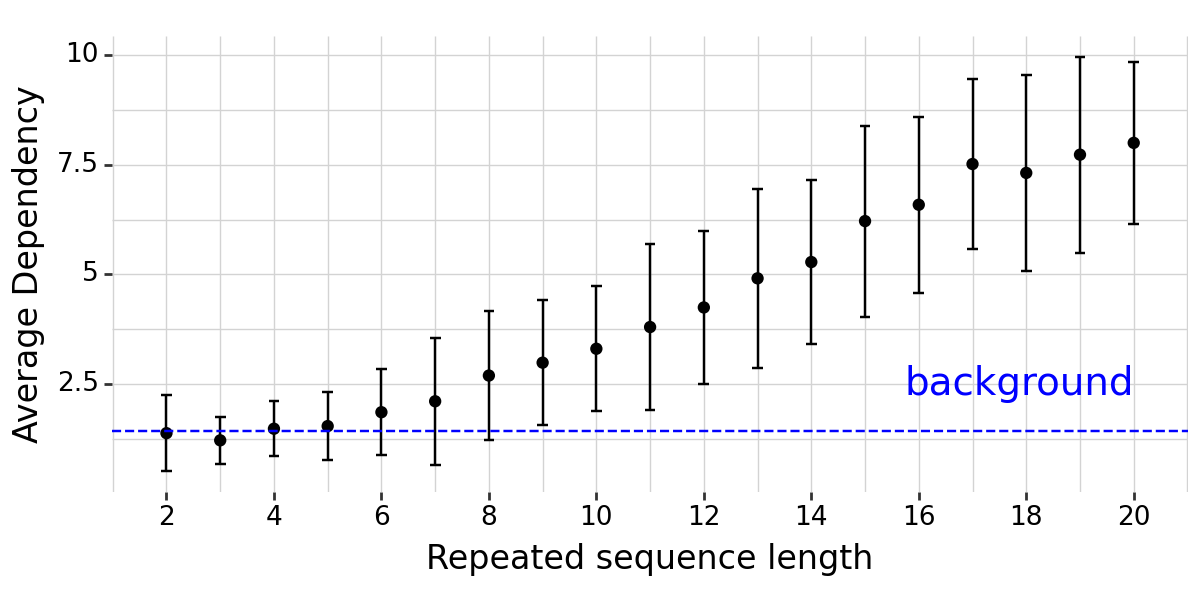

<Figure Size: (600 x 300)>

In [110]:
mean_values = avg_interaction_values_df.mean()
std_values = avg_interaction_values_df.std()

plot_df = pd.DataFrame({
    'k': mean_values.index.astype(int),
    'mean': mean_values.values,
    'std': std_values.values
})
mean_dependency = 1.44 # basepair notebook analysis provided this value as background_dependency
p = (
    ggplot(plot_df, aes(x='k', y='mean'))
    + geom_point()
    + geom_errorbar(aes(ymin='mean-std', ymax='mean+std'), width=0.2)
    + scale_x_continuous(breaks=list(range(2, 21, 2)))
    + labs(x='Repeated sequence length', y='Average Dependency')
    +geom_hline(yintercept=mean_dependency, linetype="dashed", color="blue")
    + annotate('text', x=20, y=mean_dependency+1.5, label='background', ha='right', va='top', color='blue', size=14)
    + cowplot_theme((6, 3), 12)
)
p

In [35]:
revcomp_df = pd.read_csv(os.path.join(data_path, 'avg_dependency_vs_revcomp_repeat_length_all_sims.tsv'), sep='\t')
revcomp_df['type'] = 'Inverted\nduplication'
revcomp_df

2         3         4         5         6         7         8  \
0   1.722519  1.291030  2.117786  0.915530  1.327380  1.619039  2.262984   
1   1.172115  3.516274  2.097752  0.906373  3.115925  1.307191  1.552360   
2   1.275788  0.964044  1.406271  0.754906  1.705138  2.408390  3.552665   
3   1.098235  0.909494  1.459831  0.668806  1.467932  2.352404  4.143651   
4   1.662266  0.992497  0.546114  1.117166  2.134413  1.945663  1.512806   
..       ...       ...       ...       ...       ...       ...       ...   
95  0.866131  1.226338  1.966877  1.189208  1.949942  5.691111  4.124378   
96  1.032364  0.688609  1.663250  1.785860  1.640336  2.935274  3.372568   
97  1.138017  1.824802  1.086052  1.021321  2.035827  1.448207  3.881218   
98  0.771994  0.749371  0.973555  1.196363  0.776086  0.907664  1.497210   
99  0.474205  1.595821  0.769440  1.518974  1.401642  0.892550  1.669932   

           9        10        11        12        13        14        15  \
0   4.456310  4.716319  2.940939  4.248519  5.987659  4.941097  6.991610   
1   6.447309  3.608654  7.024693  6.780746  3.690278  5.524987  7.613335   
2   1.482481  3.815901  5.187861  6.151552  4.070304  4.657865  8.389236   
3   2.907290  1.767250  5.101863  9.212496  3.505959  5.582578  7.027212   
4   3.820429  5.939575  2.896973  5.204085  4.341557  4.863073  6.603554   
..       ...       ...       ...       ...       ...       ...       ...   
95  5.900083  3.363943  6.767784  3.033891  4.749861  6.480331  4.465023   
96  3.063739  2.131907  1.404902  5.755428  6.982783  6.730222  4.351110   
97  2.471336  4.583380  2.270982  9.445681  5.588371  3.465269  5.161538   
98  2.104542  2.745503  3.212307  4.946601  6.454554  5.918839  9.388673   
99  2.520694  1.976934  3.433517  3.930456  6.016445  6.829399  6.134960   

          16         17         18        19         20                   type  
0   4.617537   4.539569  10.565178  9.149392   7.526243  Inverted\nduplication  
1   8.879550   6.466881   7.390843  7.463959   9.944187  Inverted\nduplication  
2   6.936475   9.240372   7.870777  7.956816   8.536524  Inverted\nduplication  
3   7.555647   7.990251   8.379143  6.062604   9.585476  Inverted\nduplication  
4   7.985245   7.946776   5.180141  8.388500   6.744212  Inverted\nduplication  
..       ...        ...        ...       ...        ...                    ...  
95  7.646875   6.946665   6.382630  6.498563   8.389770  Inverted\nduplication  
96  6.217852  10.406703   6.654349  8.184025  10.139683  Inverted\nduplication  
97  7.185549   7.276102   8.455939  7.857227   8.083749  Inverted\nduplication  
98  6.903180   8.106952   9.116546  6.457622   9.713408  Inverted\nduplication  
99  7.470872  10.225095   9.153306  8.058785   9.852668  Inverted\nduplication  

[100 rows x 20 columns]

In [36]:
repeat_df = pd.read_csv(os.path.join(data_path, 'avg_dependency_vs_repeat_length_all_sims.tsv'), sep='\t')
repeat_df['type'] = 'Forward\nduplication'
repeat_df

2         3         4          5         6          7         8  \
0   2.656159  0.889912  3.959960   1.357983  6.652759   4.238054  9.659501   
1   2.939831  0.716473  0.720887   1.045141  2.616855   1.530371  5.655966   
2   1.978428  2.068575  1.625790   1.724291  1.417524  10.102644  6.842008   
3   1.253967  1.072005  1.702850   2.317178  8.656348   4.793569  9.107312   
4   1.924679  2.739055  1.183164   2.802141  2.593442   7.392558  8.466797   
..       ...       ...       ...        ...       ...        ...       ...   
95  1.869228  6.395230  1.411465   0.916816  2.523683   1.053205  2.684464   
96  0.853934  1.991716  5.379865   2.007354  2.158749   8.095456  2.907112   
97  1.228007  0.847559  0.734931   2.652900  1.317934   3.588588  2.097185   
98  1.218847  3.568251  1.864151  10.483507  8.463715   2.017855  6.654315   
99  1.070611  1.399356  2.958211   2.220147  1.706996   6.196772  6.894301   

           9         10         11         12         13         14  \
0   1.199023   9.599604  11.003560   9.265668  10.643506  10.917227   
1   3.969943  10.390435   6.466344  10.097454  11.368637   6.589693   
2   4.766947   9.333169   8.742289  10.426528   8.091978  10.540802   
3   6.901052   6.246693   3.807257  13.150765   8.950605  11.566750   
4   4.212441   8.755085   8.774476   8.639724  13.315724   9.331572   
..       ...        ...        ...        ...        ...        ...   
95  8.643931  10.801097  10.769955  10.044274  11.411877  10.724532   
96  8.028773   9.164279  10.200894  10.964803   8.754931  10.719755   
97  3.234229   4.946362   9.597939  10.148060   6.962854  10.164168   
98  3.058904   2.660254   7.284526   4.898771  10.251309  11.080216   
99  3.323150   3.939566   8.914488   9.496095  10.575491  11.126195   

           15         16         17         18         19         20  \
0    9.750363   8.202930  13.598939  14.270947  10.560545  11.799243   
1    9.180584   7.521862  10.138775  10.664535   9.787251  11.577391   
2    7.784415  11.296328  12.586530   8.696265  10.333922  11.505779   
3   12.938888   8.577188  12.831504  10.733344   7.364037  11.480105   
4   11.359202  12.663648   9.395725  11.028963   8.549128  11.206994   
..        ...        ...        ...        ...        ...        ...   
95  12.282458  10.164058  10.933709  10.839208  11.754190  11.309859   
96  12.790431  13.218183  11.317641  11.736431  12.872205  10.563328   
97   5.220517  10.764691  10.752143  11.816413  11.506591  11.913875   
98  10.313658   8.352657  10.000377  13.154095   8.887051  11.406535   
99  10.122117  11.993975  12.184683  12.493087  10.112767   9.940777   

                    type  
0   Forward\nduplication  
1   Forward\nduplication  
2   Forward\nduplication  
3   Forward\nduplication  
4   Forward\nduplication  
..                   ...  
95  Forward\nduplication  
96  Forward\nduplication  
97  Forward\nduplication  
98  Forward\nduplication  
99  Forward\nduplication  

[100 rows x 20 columns]

In [37]:
repeat_revcomp_df = pd.concat([repeat_df, revcomp_df], axis=0).reset_index(drop=True)
repeat_revcomp_df

2         3         4         5         6          7         8  \
0    2.656159  0.889912  3.959960  1.357983  6.652759   4.238054  9.659501   
1    2.939831  0.716473  0.720887  1.045141  2.616855   1.530371  5.655966   
2    1.978428  2.068575  1.625790  1.724291  1.417524  10.102644  6.842008   
3    1.253967  1.072005  1.702850  2.317178  8.656348   4.793569  9.107312   
4    1.924679  2.739055  1.183164  2.802141  2.593442   7.392558  8.466797   
..        ...       ...       ...       ...       ...        ...       ...   
195  0.866131  1.226338  1.966877  1.189208  1.949942   5.691111  4.124378   
196  1.032364  0.688609  1.663250  1.785860  1.640336   2.935274  3.372568   
197  1.138017  1.824802  1.086052  1.021321  2.035827   1.448207  3.881218   
198  0.771994  0.749371  0.973555  1.196363  0.776086   0.907664  1.497210   
199  0.474205  1.595821  0.769440  1.518974  1.401642   0.892550  1.669932   

            9         10         11         12         13         14  \
0    1.199023   9.599604  11.003560   9.265668  10.643506  10.917227   
1    3.969943  10.390435   6.466344  10.097454  11.368637   6.589693   
2    4.766947   9.333169   8.742289  10.426528   8.091978  10.540802   
3    6.901052   6.246693   3.807257  13.150765   8.950605  11.566750   
4    4.212441   8.755085   8.774476   8.639724  13.315724   9.331572   
..        ...        ...        ...        ...        ...        ...   
195  5.900083   3.363943   6.767784   3.033891   4.749861   6.480331   
196  3.063739   2.131907   1.404902   5.755428   6.982783   6.730222   
197  2.471336   4.583380   2.270982   9.445681   5.588371   3.465269   
198  2.104542   2.745503   3.212307   4.946601   6.454554   5.918839   
199  2.520694   1.976934   3.433517   3.930456   6.016445   6.829399   

            15         16         17         18         19         20  \
0     9.750363   8.202930  13.598939  14.270947  10.560545  11.799243   
1     9.180584   7.521862  10.138775  10.664535   9.787251  11.577391   
2     7.784415  11.296328  12.586530   8.696265  10.333922  11.505779   
3    12.938888   8.577188  12.831504  10.733344   7.364037  11.480105   
4    11.359202  12.663648   9.395725  11.028963   8.549128  11.206994   
..         ...        ...        ...        ...        ...        ...   
195   4.465023   7.646875   6.946665   6.382630   6.498563   8.389770   
196   4.351110   6.217852  10.406703   6.654349   8.184025  10.139683   
197   5.161538   7.185549   7.276102   8.455939   7.857227   8.083749   
198   9.388673   6.903180   8.106952   9.116546   6.457622   9.713408   
199   6.134960   7.470872  10.225095   9.153306   8.058785   9.852668   

                      type  
0     Forward\nduplication  
1     Forward\nduplication  
2     Forward\nduplication  
3     Forward\nduplication  
4     Forward\nduplication  
..                     ...  
195  Inverted\nduplication  
196  Inverted\nduplication  
197  Inverted\nduplication  
198  Inverted\nduplication  
199  Inverted\nduplication  

[200 rows x 20 columns]

In [38]:
repeat_revcomp_melted_df = repeat_revcomp_df.melt(id_vars='type', var_name='length', value_name='average_dependency')
repeat_revcomp_melted_df

type length  average_dependency
0      Forward\nduplication      2            2.656159
1      Forward\nduplication      2            2.939831
2      Forward\nduplication      2            1.978428
3      Forward\nduplication      2            1.253967
4      Forward\nduplication      2            1.924679
...                     ...    ...                 ...
3795  Inverted\nduplication     20            8.389770
3796  Inverted\nduplication     20           10.139683
3797  Inverted\nduplication     20            8.083749
3798  Inverted\nduplication     20            9.713408
3799  Inverted\nduplication     20            9.852668

[3800 rows x 3 columns]

In [39]:
mean_df = repeat_revcomp_melted_df.groupby(['type','length']).mean().reset_index().rename({'average_dependency':'mean'},axis=1)
std_df = repeat_revcomp_melted_df.groupby(['type','length']).std().reset_index().rename({'average_dependency':'std'},axis=1)
std_mean_df = mean_df.merge(std_df, on=['type','length'])
std_mean_df['length'] = std_mean_df['length'].astype(int)
std_mean_df

type  length       mean       std
0    Forward\nduplication      10   7.284286  2.686286
1    Forward\nduplication      11   7.998481  2.482777
2    Forward\nduplication      12   8.758236  2.267256
3    Forward\nduplication      13   9.924411  2.166369
4    Forward\nduplication      14   9.976015  1.642168
5    Forward\nduplication      15  10.729031  1.466157
6    Forward\nduplication      16  10.818059  1.929606
7    Forward\nduplication      17  11.063880  1.388996
8    Forward\nduplication      18  11.110359  1.719974
9    Forward\nduplication      19  11.437939  1.378419
10   Forward\nduplication       2   1.539949  0.738822
11   Forward\nduplication      20  11.734457  1.138289
12   Forward\nduplication       3   1.632843  1.040722
13   Forward\nduplication       4   1.663549  0.948485
14   Forward\nduplication       5   2.701862  2.361603
15   Forward\nduplication       6   3.094962  2.247879
16   Forward\nduplication       7   4.468778  2.389169
17   Forward\nduplication       8   5.854484  2.696768
18   Forward\nduplication       9   6.491724  2.508464
19  Inverted\nduplication      10   3.823733  1.741637
20  Inverted\nduplication      11   4.128860  1.548231
21  Inverted\nduplication      12   5.133263  1.984197
22  Inverted\nduplication      13   5.481799  1.590709
23  Inverted\nduplication      14   6.095692  1.600380
24  Inverted\nduplication      15   6.619006  1.919284
25  Inverted\nduplication      16   6.961874  1.590599
26  Inverted\nduplication      17   7.532190  1.617864
27  Inverted\nduplication      18   7.450416  1.807029
28  Inverted\nduplication      19   8.090122  1.966247
29  Inverted\nduplication       2   1.248830  0.561537
30  Inverted\nduplication      20   8.600002  1.543261
31  Inverted\nduplication       3   1.238367  0.576135
32  Inverted\nduplication       4   1.576105  0.644874
33  Inverted\nduplication       5   1.693297  0.830963
34  Inverted\nduplication       6   1.935254  0.902886
35  Inverted\nduplication       7   2.461534  1.222650
36  Inverted\nduplication       8   2.519811  1.169899
37  Inverted\nduplication       9   3.267761  1.524783

In [ ]:
mean_dependency = 1.44 # basepair notebook analysis provided this value as background_dependency
p = (
    ggplot(std_mean_df, aes(x='length', y='mean', color='type'))
    + geom_point()
    + geom_errorbar(aes(ymin='mean-std', ymax='mean+std'), width=0.3)
    + scale_x_continuous(breaks=list(range(2, 21, 2)))
    + scale_y_continuous(expand=(0, 0), limits=(0, None))
    + labs(x='Repeated sequence length', y='Average Dependency')
    +geom_hline(yintercept=mean_dependency, linetype="dashed", color="blue")
    + annotate('text', x=20, y=mean_dependency+1.0, label='background', ha='right', va='top', color='blue', size=12)
    + cowplot_theme((6, 3), 12)
    + theme(legend_title=element_blank())
)
p

In [170]:
ggsave(p, 'fig6_repeat_revcomp_length_dep.png', dpi=500)

/opt/modules/i12g/anaconda/envs/flash2/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6 x 3 in image.
/opt/modules/i12g/anaconda/envs/flash2/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /s/project/multispecies/fungi_code/ci_matrices/dna-lm-interactions-paper/figures/fig6_repeat_revcomp_length_dep.png


### Compute background dependency

In [75]:
from tqdm import tqdm

seq_length = median_tRNA_length
n_natural_seqs_to_sample = 5
n_windows_to_sample = 1
mean_interaction_values_list = []
natural_seqs = list(s_cer_seqs_df['five_prime_seq'].dropna().sample(n_natural_seqs_to_sample).values)

for n in n_antidiags_to_check:
    print(n)
    for l in range(n_natural_seqs_to_sample):
        
        for k in range(n_windows_to_sample):

            window_seq, _, _ = shuffle_sequence_sample_window(natural_seqs[l], window_size=median_tRNA_length)
            p1, p2, window_seq_w_revcomp = insert_random_revcomp(window_seq, random_seq_length=n, allow_wobble=True)
            ci_matrix = compute_ci_matrix(window_seq_w_revcomp, proxy_species=proxy_species)
            ci_matrix[np.arange(ci_matrix.shape[0]),np.arange(ci_matrix.shape[0])] =0
            mean_interaction_values_list.append(np.mean(ci_matrix.flatten()))

2


Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

3


Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

4


Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

5


Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

6


Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

7


Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

8


Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

9


Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

10


Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

11


Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

12


Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

13


Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

14


Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

15


Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

16


Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

17


Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

18


Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

19


Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

20


Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/220 [00:00<?, ? examples/s]

In [77]:
mean_interaction_values_list

[1.1646364055564153,
 1.7024489683916117,
 1.5378575072092329,
 1.5615677917052846,
 1.4280436776199537,
 1.401308723575605,
 1.5401228344877793,
 1.5816181090646937,
 1.6221388993880208,
 1.1524108171485383,
 1.671648307119196,
 1.2973062468639882,
 1.6194590993112328,
 1.446725846024789,
 1.3036696364137375,
 1.596591283264382,
 1.1599856949105318,
 1.1258757162323967,
 1.3964509092429316,
 1.2299740483907804,
 1.1718861591843353,
 1.3012205126289356,
 1.6254836601563614,
 1.0793063082674763,
 1.3347238439330467,
 1.4163911105919162,
 1.3538540135974686,
 1.7562933258221551,
 1.3065443765767006,
 1.376375490174237,
 1.4776367750092236,
 1.4531767024183435,
 1.0346669912293518,
 1.449549327739566,
 0.9664311306318661,
 1.5126567309385708,
 1.1659236395950723,
 1.3474994945322556,
 1.3970374490798,
 1.0791450006361973,
 1.3209241796896591,
 1.4894066417551686,
 1.4775832964837563,
 1.9457351313867226,
 1.2773854062590329,
 1.888125699274221,
 1.511010518276931,
 1.532141995703465,
 1.3

In [90]:
mean_dependency = np.mean(mean_interaction_values_list)
mean_dependency

1.4441749024492987

In [43]:
tRNA_avg_dep_df = pd.read_parquet(os.path.join(data_path, 'trna_dependencies.pq'))
tRNA_avg_dep_df

len  dependency
0      3    5.011914
1      5    9.618275
2      5    8.321322
3      1   10.508091
4      5    8.341891
..   ...         ...
255    1    1.480487
256    2    0.887341
257    5    7.402276
258    3    8.441176
259    3    9.446297

[260 rows x 2 columns]

In [44]:
trna_avg_df = tRNA_avg_dep_df.groupby('len').median().reset_index()
trna_avg_df.rename(columns={'len':'n', 'dependency':'tRNA_avg_dependency'}, inplace=True)
trna_avg_df

n  tRNA_avg_dependency
0  1            10.435438
1  2             8.257657
2  3             6.998090
3  4             5.489268
4  5             8.317037
5  7             9.020315

In [45]:
n_anti_occ_df = pd.read_csv(os.path.join(data_path, 'avg_occurrences_rev_complement_no_wobble_trna_shuffled.tsv'), sep='\t')
n_anti_occ_df

n  avg_occurrences
0    2       573.303293
1    3       218.298693
2    4        82.838157
3    5        31.301357
4    6        11.787800
5    7         4.428136
6    8         1.654943
7    9         0.619850
8   10         0.229714
9   11         0.085450
10  12         0.030443
11  13         0.011993
12  14         0.004514
13  15         0.002000
14  16         0.000600
15  17         0.000279
16  18         0.000129
17  19         0.000000
18  20         0.000014

In [46]:
cowplot_theme = lambda figure_size, font_size : theme(
    # Set the background to white and remove panel border
    panel_background=element_blank(),
    panel_border=element_blank(),

    # Light grey grid lines
    panel_grid_major=element_line(color='lightgrey', size=0.5),
    panel_grid_minor=element_blank(),

    # Minimize axis ticks
    axis_ticks=element_blank(),
    #axis_text_x=element_text(rotation=45, hjust=1),

    # Simple font
    text=element_text(color='black'),
    #change x and y labels font size
    axis_text_x=element_text(size=font_size-2.5),
    axis_text_y=element_text(size=font_size-2.5),
    axis_title_x=element_text(size=font_size),
    axis_title_y=element_text(size=font_size),
    #change x and y axis ticks labels size
    figure_size = figure_size
)

In [47]:
avg_interaction_values_df = pd.read_csv(os.path.join(data_path, 'avg_dependency_vs_revcomp_repeat_trna_shuffles.tsv'), sep='\t')
avg_interaction_values_df

2         3         4         5         6         7         8  \
0   2.400019  0.720126  3.104632  1.986376  0.924627  1.241126  1.030114   
1   0.853090  0.871850  2.391878  1.643956  1.677179  2.403376  2.561341   
2   1.190402  0.792999  1.473360  1.773293  1.163839  2.496498  1.671480   
3   0.471039  1.957500  1.462464  1.190138  4.727439  1.582102  2.999564   
4   2.430602  0.646800  0.927774  1.770621  1.082748  1.119419  1.573544   
..       ...       ...       ...       ...       ...       ...       ...   
65  0.691139  0.476797  1.239958  1.512906  1.570274  8.179519  4.784019   
66  4.280664  1.539929  2.504858  3.106308  0.779856  1.586887  1.259955   
67  1.028004  0.826443  2.937493  1.224604  1.678026  3.323899  2.073211   
68  1.719609  1.175212  1.340461  1.777277  1.545576  2.854822  1.521375   
69  1.507742  1.158174  1.160850  2.238616  4.394385  0.815576  1.822506   

           9        10        11        12        13        14         15  \
0   2.008701  4.349918  2.028392  5.364879  6.404391  5.274672   5.227148   
1   1.890776  1.976963  1.317837  4.182969  3.428850  2.405839   6.961593   
2   1.415730  3.586039  2.529158  1.992208  2.190224  6.577518   7.435340   
3   1.608031  3.200691  1.602693  6.618078  4.577532  9.098422   8.871318   
4   2.483095  4.542718  2.335523  1.538118  4.094982  6.849145   5.042552   
..       ...       ...       ...       ...       ...       ...        ...   
65  1.991939  5.216555  3.617014  1.577755  6.447778  5.937804  12.119892   
66  3.204906  4.697552  2.221909  1.989758  1.483040  3.802141   9.249722   
67  2.974000  3.863930  1.066616  3.808369  7.702848  6.311897   5.371252   
68  3.682730  1.916979  1.156161  4.615157  4.093505  7.010830   1.176499   
69  2.386866  2.729428  1.890450  4.710838  3.731340  4.050550   6.325258   

          16         17         18         19         20  
0   6.971506   7.804050   8.625813   9.784318   5.475265  
1   6.139925   7.892898   8.383163   9.498646   9.026370  
2   6.388795  12.218436   6.288264   8.507567   6.256155  
3   3.176230   8.893842   2.575127   5.518572   9.548558  
4   5.055650   2.678072   7.678024   6.730679  10.572943  
..       ...        ...        ...        ...        ...  
65  8.690960   8.128706   2.179349   6.557165   5.517569  
66  7.616878   6.290938   6.689244   5.770410   8.204069  
67  7.059744   6.148582  10.333472  10.061448   9.244457  
68  7.026979   9.675545   5.657610   8.290470   8.634958  
69  7.528101   5.056329   8.203094   5.250695   7.960961  

[70 rows x 19 columns]

In [48]:
tRNA_mean_df = tRNA_avg_dep_df.groupby('len').mean().reset_index().rename({'dependency':'trna_mean'},axis=1)
tRNA_std_df = tRNA_avg_dep_df.groupby('len').std().reset_index().rename({'dependency':'trna_std'},axis=1)
tRNA_std_mean_df = tRNA_mean_df.merge(tRNA_std_df, on='len')
tRNA_std_mean_df

len  trna_mean  trna_std
0    1   8.556248  3.510066
1    2   7.464686  3.058629
2    3   6.486587  2.196114
3    4   5.337036  2.133859
4    5   8.159497  1.049269
5    7   8.963026  0.608294

In [49]:
mean_values = avg_interaction_values_df.mean()
std_values = avg_interaction_values_df.std()

plot_df = pd.DataFrame({
    'k': mean_values.index.astype(int),
    'mean': mean_values.values,
    'std': std_values.values
})
plot_df = plot_df.merge(tRNA_std_mean_df, left_on='k', right_on='len', how='left')
plot_df

k      mean       std  len  trna_mean  trna_std
0    2  1.382889  0.864214  2.0   7.464686  3.058629
1    3  1.219328  0.529895  3.0   6.486587  2.196114
2    4  1.483775  0.622627  4.0   5.337036  2.133859
3    5  1.543685  0.773948  5.0   8.159497  1.049269
4    6  1.860094  0.978103  NaN        NaN       NaN
5    7  2.109319  1.452195  7.0   8.963026  0.608294
6    8  2.695219  1.465954  NaN        NaN       NaN
7    9  2.988935  1.429118  NaN        NaN       NaN
8   10  3.305840  1.421690  NaN        NaN       NaN
9   11  3.800521  1.888260  NaN        NaN       NaN
10  12  4.246901  1.749358  NaN        NaN       NaN
11  13  4.910166  2.037144  NaN        NaN       NaN
12  14  5.281499  1.878771  NaN        NaN       NaN
13  15  6.214324  2.177638  NaN        NaN       NaN
14  16  6.586550  2.001304  NaN        NaN       NaN
15  17  7.514567  1.935730  NaN        NaN       NaN
16  18  7.312115  2.226040  NaN        NaN       NaN
17  19  7.727519  2.231686  NaN        NaN       NaN
18  20  7.996390  1.850438  NaN        NaN       NaN

/opt/modules/i12g/anaconda/envs/fungi_code/lib/python3.8/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 14 rows containing missing values.
/opt/modules/i12g/anaconda/envs/fungi_code/lib/python3.8/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_errorbar : Removed 14 rows containing missing values.


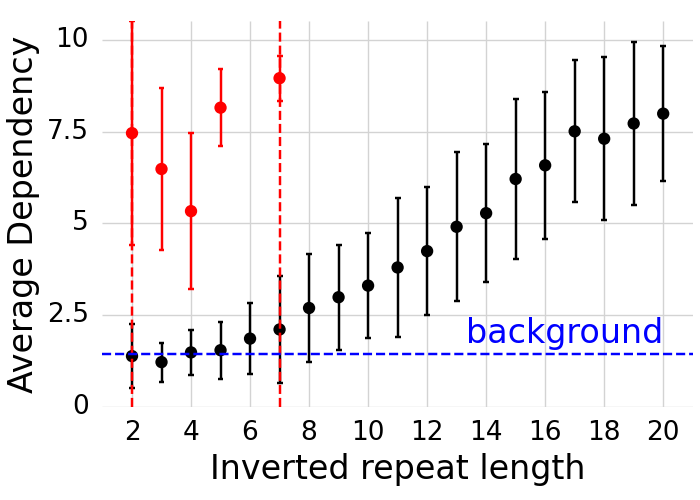

<Figure Size: (350 x 250)>

In [68]:
mean_dependency = 1.44 # basepair notebook analysis provided this value as background_dependency
p1 = (
    ggplot(plot_df, aes(x='k', y='mean'))
    + geom_point()
    + geom_point(aes('k', 'trna_mean'), color='red')
    + geom_errorbar(aes(ymin='trna_mean-trna_std', ymax='trna_mean+trna_std'), width=0.2,color='red')
    + geom_errorbar(aes(ymin='mean-std', ymax='mean+std'), width=0.2)
    + geom_vline(xintercept=7, linetype="dashed", color="red")
    + geom_vline(xintercept=2, linetype="dashed", color="red")
    + scale_x_continuous(breaks=list(range(2, 21, 2)))
    + scale_y_continuous(expand=(0, 0), limits=(0, None))
    + labs(x='Inverted repeat length', y='Average Dependency')
    +geom_hline(yintercept=mean_dependency, linetype="dashed", color="blue")
    + annotate('text', x=20, y=mean_dependency+1, label='background', ha='right', va='top', color='blue', size=12)
    + cowplot_theme((3.5, 2.5), 12)
)
p1

In [ ]:
ggsave(p1, "fig6_trna_inv_repeat_length_dep_p1.png", dpi=500)

In [70]:
n_anti_occ_df

n  avg_occurrences
0    2       573.303293
1    3       218.298693
2    4        82.838157
3    5        31.301357
4    6        11.787800
5    7         4.428136
6    8         1.654943
7    9         0.619850
8   10         0.229714
9   11         0.085450
10  12         0.030443
11  13         0.011993
12  14         0.004514
13  15         0.002000
14  16         0.000600
15  17         0.000279
16  18         0.000129
17  19         0.000000
18  20         0.000014

/opt/modules/i12g/anaconda/envs/fungi_code/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10


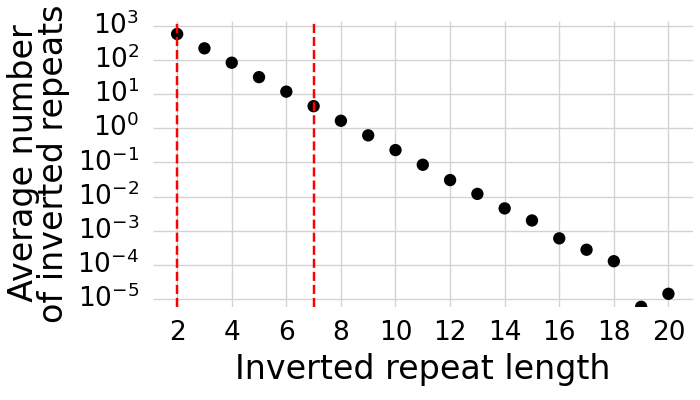

<Figure Size: (350 x 200)>

In [78]:
log_breaks = [10**x for x in range(-5, 4)]  # This creates [1, 10, 100, 1000]. Adjust range as needed.
def log10_formatter(x):
    return [f'$10^{{{int(np.log10(val))}}}$' for val in x]
p2 = (
    ggplot(n_anti_occ_df, aes(x='n', y='avg_occurrences'))
    + geom_point()
    + geom_vline(xintercept=7, linetype="dashed", color="red")
    + geom_vline(xintercept=2, linetype="dashed", color="red")
    + scale_x_continuous(breaks=list(range(2, 21, 2)))
      + scale_y_log10(breaks=log_breaks, labels=log10_formatter)
    + labs(x='Inverted repeat length', y='  Average number\nof inverted repeats')
    + cowplot_theme((3.5, 2), 12)
)
p2

In [ ]:
ggsave(p2, "fig6_trna_inv_repeat_length_dep_p2.png", dpi=500)